In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import normaltest
from scipy.stats import norm
import scipy.stats as stats
import pylab
from datetime import *
import gc
from subprocess import check_output
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as mdate

# Static data definition
input2017 = "../input/Parking_Violations_Issued_-_Fiscal_Year_2017.csv"
input2016 = "../input/Parking_Violations_Issued_-_Fiscal_Year_2016.csv"
input2015 = "../input/Parking_Violations_Issued_-_Fiscal_Year_2015.csv"
input2014 = "../input/Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv"
inputDict = {"2017":input2017, "2016":input2016, "2015":input2015, "2014":input2014}
gc.enable()

**1. Sampling**

Before Stratified sampling, I define a function to clean the target label "Vehicle Color" by using regex. I set 12 target color labels, including "BLUE", "RED", "TAN", "ORANGE", "WHITE", "SILVER", "BLACK", "GREEN", "YELLOW", "GOLD", "PURPLE" and "BROWN".  

In [2]:
# Deal with inconsistencies of color
colorLabel = ["BLUE","RED","TAN","ORANGE","WHITE","SILVER","BLACK","GREEN","YELLOW",\
              "GOLD","PURPLE","BROWN"]
def colorCombine(data):
    data['Vehicle Color'] = data['Vehicle Color'].replace(".*B.*K.*","BLACK",regex=True)
    data['Vehicle Color'] = data['Vehicle Color'].replace(".*B.*[U|E]","BLUE",regex=True)
    data['Vehicle Color'] = data['Vehicle Color'].replace(".*R.*D.*","RED",regex=True)
    data['Vehicle Color'] = data['Vehicle Color'].replace(".*T.*N","TAN",regex=True)
    data['Vehicle Color'] = data['Vehicle Color'].replace(".*OR.*","ORANGE",regex=True)
    data['Vehicle Color'] = data['Vehicle Color'].replace(".*W.*[T|H].*","WHITE",regex=True)
    data['Vehicle Color'] = data['Vehicle Color'].replace(".*S.*[L|V].*","SILVER",regex=True)
    data['Vehicle Color'] = data['Vehicle Color'].replace(".*G.*[R|N].*","GREEN",regex=True)
    data['Vehicle Color'] = data['Vehicle Color'].replace(".*[Y|E].*[L|O|W].*","YELLOW",regex=True)
    data['Vehicle Color'] = data['Vehicle Color'].replace(".*G.*[L|D].*","GOLD",regex=True)
    data['Vehicle Color'] = data['Vehicle Color'].replace(".*P.*[P|L].*","PURPLE",regex=True)
    data['Vehicle Color'] = data['Vehicle Color'].replace(".*B.*[W|N].*","BROWN",regex=True)
    return data[data['Vehicle Color'].isin(colorLabel)]

Iteratively read each data file and group the data by 'Vehicle Color' attribute, then randomly choose 0.03% samples of each group, totally around 9500 records.  Save data as DataFrame data type, and it is named as 'data'.

In [3]:
# Stratified sample data
data = None
for key, inputData in inputDict.items():
    tmp = pd.read_csv(inputData, sep=',', header=0, dtype='str')
    tmp = colorCombine(tmp)
    if data is None:
        data = tmp.groupby(['Vehicle Color']).apply(lambda x: x.sample(frac=.0003))
    else:
        data = data.append(tmp.groupby(['Vehicle Color']).apply(lambda x: x.sample(frac=.0003)))
    tmp = None
data = pd.DataFrame(data.values, columns=data.columns)

After sampling, I find that the number of each class are bias. So I group some classes with few records into the same class so as to balance the number of each class. From the grouping result below, the color of 'BLACK', 'GREEN', 'WHITE' are over 1000, rest are below 1000. I group 'GREEN','BLUE','PURPLE','BROWN' and 'TAN' into one color named 'DARK', and group 'GOLD','ORANGE','RED', 'SILVER' and 'YELLOW' into one group named 'LIGHT'.

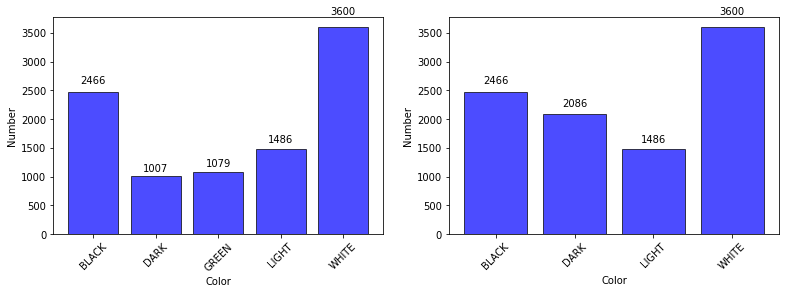

In [4]:
plt.figure(1,figsize=(13,4))
plt.subplot(121)
colorCount = data.groupby(['Vehicle Color'])['Vehicle Color'].count()
x = np.array(colorCount.index)
rects = plt.bar(x, colorCount, color='b', alpha=0.7, edgecolor='black')
for rect in rects:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,'%d' % int(height),ha='center', va='bottom')
plt.ylabel('Number')
plt.xlabel('Color')
plt.xticks(rotation=45)

# Group classes
data['Vehicle Color'] = data['Vehicle Color'].replace('GREEN|BLUE|PURPLE|BROWN|TAN', 'DARK', regex=True)\
                                             .replace('GOLD|ORANGE|RED|SILVER|YELLOW', 'LIGHT', regex=True)

plt.figure(1,figsize=(13,4))
plt.subplot(122)
colorCount = data.groupby(['Vehicle Color'])['Vehicle Color'].count()
x = np.array(colorCount.index)
rects = plt.bar(x, colorCount, color='b', alpha=0.7, edgecolor='black')
for rect in rects:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,'%d' % int(height),ha='center', va='bottom')
plt.ylabel('Number')
plt.xlabel('Color')
plt.xticks(rotation=45)

plt.show()

**2. Data Preprocessing**

**2.1 Eliminate NaN attributes**

I take a look into the sample data and group data by each attribute to see the categories of features. I find that there are some features containing only NaN values, which are ["BBL","BIN","Census Tract", "Community Board", "Community Council ","Double Parking Violation", "Hydrant Violation", "Latitude", "Longitude", "NTA", "No Standing or Stopping Violation"]. So I drop these attributes to minimize noise.

In [4]:
dropLabels = ["BBL","BIN","Census Tract", "Community Board", "Community Council ",
              "Double Parking Violation", "Hydrant Violation", "Latitude", "Longitude", 
              "NTA", "No Standing or Stopping Violation"]
data = data.drop(dropLabels, axis=1)

**2.2 Clean each attributes**  
This section starts clean data of each attribute. My steps are:
* Group data of the attribute to see the outliers and error values;
* If the value is date or time, then use pandas.to_datetime() function to convert values into standard format, and replace errors as NaT.
* If the value is nominal data, then use regex to clean inconsistencies, and replace errors as NaN.

**2.2.1 Clean 'Date First Observed'**  
After grouping the data of 'Date First Observed', I find that it contains data '0'. So I replace illegal date as NaT by using pandas.to_datetime(), and convert data format from 'YYYYMMDD' to 'YYYY-MM-DD'.

**2.2.2 Clean columns name 'Days Parking In Effect              ' and 'Unregistered Vehicles?**  
The name of these two attributes contain meaningless ' ' and '?'.  So I rename these columns.

**2.2.3 Clean 'Feet From Curb'**  
The data type of 'Feet From Curb' is numeric data. Based on the sample data, it range from 0 to 9. I discretize the data into 3 groups by using pandas.cut() function, the new values of  'Feet From Curb'  will be [0, 1, 2].  

**2.2.3 Clean 'From Hours In Effect'**  
The type of 'From Hours In Effect' data is date type, which are 12 hour format '%I%M%p'. After grouping data, I find that the data contains 'ALL' value which represents all day. So I look at it as nominal data instead of date data. Besides, there are some errors including '1100' without 'A' or 'P', and '0 :P' without time value. I replace these errors as NaN.

**2.2.4 Clean 'Intersecting Street'**  
'Intersecting Street' means the name of the street. After grouping data, I find that it uses some characters to seperate the street name, including '@',  '/'. '-', and 'of'. So I delete extra infomation of street name according to these characters and only keep the information of 'XXXX ST' and 'XXXX AVE', and also since some values only contain 'ST' without names, I replace these data as NaN.

**2.2.5 Clean 'Issue Date'**  
The data of 'Issue Date' is date type, with format 'MMDDYYYY'. I use pandas.to_datetime(), and convert data format from  'MMDDYYYY' to 'MM-DD-YYYY'.

**2.2.6 Clean 'Issuer Code'**  
'Issuer Code' is nominal data. After grouping data, there are lots of '0'. I replace '0' as NaN.

**2.2.7 Clean 'Street Code1', 'Street Code2', 'Street Code3'**  
'Street Code' is nominal data with error data '0'. I replace '0' as NaN.

**2.2.8 Clean 'Street Name'**  
'Street Name' is similar to 'Intersecting Street'. I also use the grouping method to find the inconsistencies and noise data, including 'ST' and 'St', 'AVE' and 'Ave', 'EAST' and 'E', 'WEST' and 'W', and some characters '@'. I only keep the information of 'XXXX ST' and 'XXXX AVE'.

**2.2.9 Clean 'Sub Division'**  
There are inconsistencies of uppercase and lowecase. I convert all data into uppercase.

**2.2.10 Clean 'Time First Observed'**  
'Time First Observed' is date type data with 12 hour format '%I%M%p'. According to standard 12 hour format which is ''%I%M %p' with a blank between time and %p, I insert blank into data and then convert it to 24 hour format withou second unit. And another error of data is that the time of hour starts from '00' to '12', while the standard 12 hour format starts from '01' to '12'. So I replace all '00' hour as '12'.

**2.2.11 Clean 'To Hours In Effect'**  
After grouping data, there are some errors including '1101' without 'P' or 'A', and unexpected blank among the characters. So I use regex to replace these errors as NaN.

**2.2.12 Clean 'Vehicle Expiration Date' **
It is same as the data of 'Date First Observed', which is date data. I use pandas.to_datetime(), and convert data format from 'YYYYMMDD' to 'YYYY-MM-DD'.

**2.2.13 Clean 'Vehicle Make'**  
The data of 'Vehicle Make' is nominal data. After grouping, I find that values are various, and only find some inconsistencies, including 'F/L' and 'FT/LI', 'HIN' and 'HINO', 'VAN H' and 'VANHO', and 'UTIL' and 'UTILI'. So I combine these data to make it consistent.

**2.2.14 Clean 'Vehicle Year'**
The data of 'Vehicle Year' represents the year data with format 'YYYY'. After grouping the data, I find that it contains ourliers including '0' and the year after 2018. So I use regex to replace these data as NaN.

**2.2.15 Clean 'Violation County'**
The data of 'Violation County' is nomimal data representing the name of county. After grouping the data, there are problems of inconsistencies and outliers or errors, including '00000' and '103', 'BX' and 'BRONX', 'K' or 'KG' and 'KINGS', 'N' and 'NEWYC', 'Q' and ''QUEEN', 'R' and 'RICH', 'MN' and "MAN'. I use regex to make them consistent.

**2.2.1.6 Clean 'Violation Time'**
'Violation Time' is date data with 12 hour format '%I%m%p'. I use the similar operation of  'Time First Observed', which is inserting a blank between time and 'A' or 'P',  and then converting it to 24 hour format withou second unit, and also replacing all '00' hour as '12'.

Following process is all cleaning operations.


In [5]:
# Clean 'Date First Observed'
data['Date First Observed'] = pd.to_datetime(data['Date First Observed'], \
                                             format="%Y%m%d",errors='coerce')

#Clean 'Days Parking In Effect    '
data = data.rename(columns={'Days Parking In Effect    ':'Days Parking In Effect',
                            'Unregistered Vehicle?':'Unregistered Vehicle'})

#Clean 'Feet From Curb', convert string type to numeric data
data['Feet From Curb'] = pd.cut(data['Feet From Curb'].astype(np.float64).values, 3, labels=False)

#Clean 'From Hours In Effect'
#Outliers: '1100', '0800', '0  :', '0  :P', '     '
data['From Hours In Effect'] = data['From Hours In Effect'].replace('1100',np.nan)\
                                                           .replace('0800',np.nan)\
                                                           .replace('0  :',np.nan)\
                                                           .replace('0  :P',np.nan).astype('str')
            
#Clean 'Intersecting Street'
data['Intersecting Street'] = data['Intersecting Street'].replace('.*[@|\-|of|/|]','',regex=True)\
                                                         .replace('ST',np.nan).astype('str')
    
#Clean 'Issue Date'
data['Issue Date'] = pd.to_datetime(data['Issue Date'],format="%m/%d/%Y",errors='coerce')

#Clean 'Issuer Code'
data['Issuer Code'] = data['Issuer Code'].replace('0',np.nan)

#Clean 'Street Code1', 'Street Code2', 'Street Code3'
data['Street Code1'] = data['Street Code1'].replace('0',np.nan).astype(str)
data['Street Code2'] = data['Street Code2'].replace('0',np.nan).astype(str)
data['Street Code3'] = data['Street Code3'].replace('0',np.nan).astype(str)

#Clean 'Street Name'
data['Street Name'] = data['Street Name'].replace('ST.*','St',regex=True)\
                                         .replace('AVE.*','Ave',regex=True)\
                                         .replace(' @.*','',regex=True)\
                                         .replace('EAST','E',regex=True)\
                                         .replace('WEST','W',regex=True)
                
#Clean 'Sub Division'
data['Sub Division'] = data['Sub Division'].str.upper()

#Clean 'Time First Observed'
tmp = data['Time First Observed'].replace("A.*"," AM",regex=True)\
                                 .replace("P.*"," PM",regex=True)\
                                 .replace("^00","12",regex=True,limit=1)
data['Time First Observed'] = pd.to_datetime(tmp, format="%I%M %p", errors='coerce')\
                                .dt.strftime("%H:%M")
    
# Clean 'To Hours In Effect'
data['To Hours In Effect'] = data['To Hours In Effect'].replace('[0-9]{1,4}$|.* .*', \
                                                                np.nan,regex=True)

#Clean 'Vehicle Expiration Date' 
data['Vehicle Expiration Date'] = pd.to_datetime(data['Vehicle Expiration Date'], \
                                                 format="%Y%m%d", errors='coerce')

#Clean 'Vehicle Make'  
#F/L == FT/LI, HIN == HINO, VAN H == VANHO, UTIL == UTILI
data['Vehicle Make'] = data['Vehicle Make'].replace('F/L','FT/LI')\
                                           .replace('HIN','HINO')\
                                           .replace('VAN H','VANHO')\
                                           .replace('UTIL','UTILI')
            
#Clean 'Vehicle Year'
data['Vehicle Year'] = data['Vehicle Year'].replace('0',np.nan)\
                            .replace('[2-9][0-9](1[89]|[2-9][0-9])', np.nan, regex=True)\
                            .astype(np.float64)
    
#Clean 'Violation County'
data['Violation County'] = data['Violation County'].replace('00000|103',np.nan,regex=True)\
                                                   .replace("BX", "BRONX")\
                                                   .replace("K.*","KINGS",regex=True)\
                                                   .replace("N.*Y","NEWYC",regex=True)\
                                                   .replace("Q.*","QUEEN",regex=True)\
                                                   .replace("R|RC","RICH",regex=True)\
                                                   .replace("MN|MH","MAN",regex=True)
                        
#Clean 'Violation Time'
tmp = data['Violation Time'].replace("A.*"," AM",regex=True)\
                            .replace("P.*"," PM",regex=True)\
                            .replace("^00","12",regex=True,limit=1)
data['Violation Time'] = pd.to_datetime(tmp, format="%I%M %p", errors='coerce')\
                                .dt.strftime("%H:%M")

#Clean 'House Number'
data['House Number']=data['House Number'].replace('-','',regex=True)\
                                         .replace('[A-Za-z]','',regex=True).astype(str)
    
data['Issuer Squad'] = data['Issuer Squad'].replace('0000','')
data['Issuer Command'] = data['Issuer Command'].replace(' ','',regex=True)


**a. calculate the mean value of the violation time attribute**  
Get mean value of violations time by alculating the mean value of difference betwen all time data with minimum time data, and then add minimum time data.

In [7]:
# a. calculate the mean value of the violation time attribute
timeSeries = pd.to_datetime(data['Violation Time'],format="%H:%M")
pd.to_datetime((timeSeries - timeSeries.min()).mean()\
               + timeSeries.min(), format="%H:%M").strftime("%H:%M")

'12:01'

**b. determine whether the violation time attribute follows the normal distribution**  
I convert violation time to minutes and draw histgram to show the distribution of the time. And use Kolmogorov-Smirnov and D’Agostino and Pearson to test the nomal distribution. The p-value of Kolmogorov-Smirnov equals to 0 and the p-value of D’Agostino and Pearson equals to 6.6818851878005736e-16 which is close to 0 as well. So the violation time attribute do not follow the normal distribution.

Kolmogorov-Smirnov test: KstestResult(statistic=0.99976079529339568, pvalue=0.0)
D’Agostino and Pearson’s: NormaltestResult(statistic=69.883922652856768, pvalue=6.6818851878005736e-16)


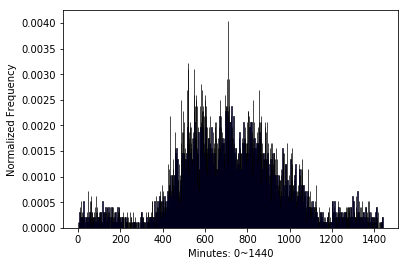

In [8]:
# b. determine whether the violation time attribute follows the normal distribution
timeSeries = pd.to_datetime(data['Violation Time'],format="%H:%M")
timeSeries = timeSeries - datetime(1900,1,1)
minSeries = timeSeries.dropna().apply(lambda x: int(x.seconds/60))
print('Kolmogorov-Smirnov test:',stats.kstest(minSeries,'norm'))
print('D’Agostino and Pearson’s:',normaltest(minSeries,nan_policy='omit'))
plt.hist(minSeries.dropna(), bins=int((minSeries.max()-minSeries.min())), normed=True, color='b', \
         alpha=0.7, edgecolor='black')
plt.ylabel('Normalized Frequency')
plt.xlabel('Minutes: 0~1440')
plt.show()

**c. provide a histogram for the violation county attribute**  
I group the data by violation county data and count the total number of each group. The histogram is below.

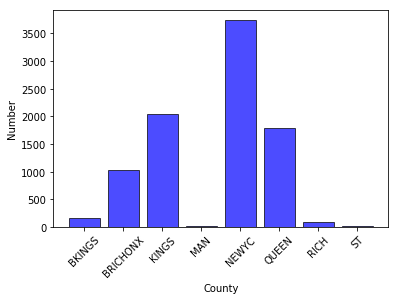

In [9]:
# c. provide a histogram for the violation county attribute
countyBar = data.groupby(['Violation County'])['Violation County'].count()
x = np.array(countyBar.index)
plt.bar(x, countyBar, color='b', alpha=0.7, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('County')
plt.xticks(rotation=45)
plt.show()

**d. provide a boxplot for the vehicle expiration date attribute** 
Get the time of column 'Vehicle Expiration Date' and convert it to years. From the boxplot result, the minimun value is 2011, fist quartile is 2014, mean value is 2016, third quartile is 2016, maximun value is 2019, and outliers are 2010, 2024, 2024, 2051.

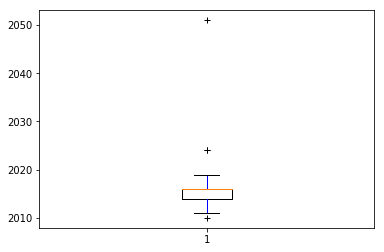

('Minimun value: ', numpy.timedelta64(2011,'Y'))
('Fist quartile value: ', numpy.timedelta64(2014,'Y'))
('Mean value: ', numpy.timedelta64(2016,'Y'))
('Third quartile value: ', numpy.timedelta64(2016,'Y'))
('Maximun value: ', numpy.timedelta64(2019,'Y'))
('Outliers: ', array([2010, 2024, 2024, 2051], dtype='timedelta64[Y]'))


In [220]:
# d. provide a boxplot for the vehicle expiration date attribute
dateSeries = pd.to_datetime(data['Vehicle Expiration Date'],format="%Y-%m-%d")
dateSeries = dateSeries - datetime(1900,1,1)
dateSeries = dateSeries.dropna()
dateSeries = dateSeries.get_values().astype('timedelta64[Y]') + np.timedelta64('1900')
bp = plt.boxplot(dateSeries,autorange=True)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='blue')
plt.setp(bp['fliers'], color='red', marker='+')
plt.show()

print( 'Minimun value: ', bp['whiskers'][0].get_ydata()[1] )
print( 'Fist quartile value: ', bp['whiskers'][0].get_ydata()[0] )
print( 'Mean value: ', bp['medians'][0].get_ydata()[0] )
print( 'Third quartile value: ', bp['whiskers'][1].get_ydata()[0] )
print( 'Maximun value: ', bp['whiskers'][1].get_ydata()[1] )
print( 'Outliers: ', bp['fliers'][0].get_ydata())

**e. determine whether there is a correlation between the violation time and vehicle year attributes**  
I use Pearson, Kendall and Spearman to calculate the correlation between 'Violation Time' and 'Vehicle Year'. The p-value of three methods are Pearson: 0.00952599874026, Kendall: 0.00945003479726, Spearman: 0.0138771343028. The p-Values are positive and close to 0, which means 'Violation Time' and 'Vehicle Year' have slight positive correlation, or have no correlation. Besides, I plot the scatter figure showed below, from the figure, I find that the number of violation was increasing from 1980 to 2018, and the range of distribution was also expanding. 

Pearson: 0.00952599874026
Kendall: 0.00945003479726
Spearman: 0.0138771343028


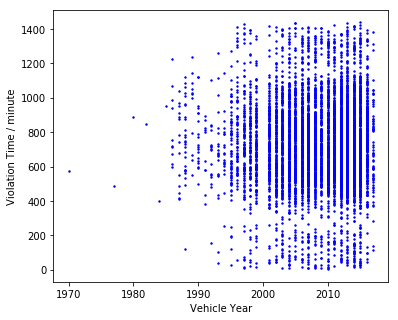

In [11]:
# e. determine whether there is a correlation between the violation time and 
# vehicle year attributes
timeSeries = pd.to_datetime(data['Violation Time'],format="%H:%M")
timeSeries = timeSeries - datetime(1900,1,1)
minSeries = timeSeries.apply(lambda x: x.seconds/60 )

print('Pearson: ',end='')
print(data['Vehicle Year'].astype(np.float64).corr(minSeries, method='pearson'))
print('Kendall: ',end='')
print(data['Vehicle Year'].astype(np.float64).corr(minSeries, method='kendall'))
print('Spearman: ',end='')
print(data['Vehicle Year'].astype(np.float64).corr(minSeries, method='spearman'))

# Scatter plot
fig = plt.figure(figsize=(6,5)) 
plt.scatter(x=data['Vehicle Year'], y=minSeries, s=2, c='b')
plt.ylabel('Violation Time / minute')
plt.xlabel('Vehicle Year')
plt.show()

**f. determine whether there is a correlation between the issuer (the person who issued the ticket) and the vehicle make attributes**  
I use Pearson, Kendall and Spearman to calculate the correlation between 'Issuer Code' (issuer) and 'Vehicle Make'. The p-value of three methods are Pearson:0.01094589525432323, Kendall:-0.009888567263195343, Spearman:-0.014545156851012573. The p-Values are positive and close to 0, which means 'Issuer Code' and 'Vehicle Make' have no correlation. Besides, I plot the scatter figure showed below, from the figure, I find that the the issuer code mainly focuses on 350000 to 400000 and 900000 to 1000000.

Pearson:  0.01094589525432323
Kendall:  -0.009888567263195343
Spearman:  -0.014545156851012573


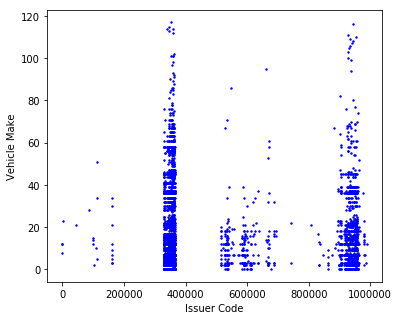

In [228]:
# f. determine whether there is a correlation between the issuer (the person who issued the ticket) 
# and the vehicle make attributes

# Rank vehicle make from 0 to size
x = np.arange(0,(data['Vehicle Make'].drop_duplicates()).size)
encoders = pd.DataFrame(data=x, index=data['Vehicle Make'].drop_duplicates().values, \
                        columns=['Vehicle Make'])
rankVehicleMake = data['Vehicle Make'].apply(lambda x : encoders.loc[x])

print 'Pearson: ',
print rankVehicleMake['Vehicle Make'].corr(data['Issuer Code'].astype(np.float64), method='pearson')
print 'Kendall: ',
print(rankVehicleMake['Vehicle Make'].corr(data['Issuer Code'].astype(np.float64), method='kendall'))
print 'Spearman: ',
print(rankVehicleMake['Vehicle Make'].corr(data['Issuer Code'].astype(np.float64), method='spearman'))

# Scatter plot
fig = plt.figure(figsize=(6,5)) 
plt.scatter(x=data['Issuer Code'].astype(np.float64), y=rankVehicleMake['Vehicle Make'], s=2, c='b')
plt.ylabel('Vehicle Make')
plt.xlabel('Issuer Code')
plt.show()

**g. explain how you would determine whether there are noise in this dataset**  
Noise data is meaningless data, caused by faulty data collection instruments, data entry problems, data transmission problems, technology limitation, inconsistency in naming convention, etc.
* I print some data to check type of the data is nominal or numeric.  
* If it is nominal data, I will group data to check NaN value, error spelling and inconsistencies data, and then use boxplot and scatter plot to view data distribution and check whether there are noise data. If it is numeric data, I will to use boxplot to determine outliers and noise data.  
* I will use domain knowledge to check noise. For example, for time attribute, the range of the time should be from 00:00:00 to 23:59:59, other values are noise or errors.

**h. explain what feature selection is apply two feature selection approaches, as found in WEKA, to this dataset**  
Feature selection is a process to eliminate irrelevant attributes which may be detrimental, causing confusion for the mining algorithm employed. It not only can reduce the data set size, but also find a minimum set of attributes such that the probability distribution of subset data is as close as possible to the original distribution. There are two types of feature selection approaches: filter and wrapper. Filter type methods select variables regardless of the model, they use statistical methods to analyze the correlation between attributes and target and then choose the most important attributes. The wrapper methods conducts a search for a good subset using the induction algorithm itself as part of the evaluation function.   

WEKA provides filter and wrapper types feature selection methods. I choose ClassifierAttributeEval and InfoGainAttributeEval evaluator and Ranker search method. ClassifierAttributeEval evaluates the worth of an attribute by using user-specified classifier, which is J48 decision tree here. InfoGainAttributeEval evaluates the worth of an attribute by measuring the information gain with respect to the class.

In ClassifierAttributeEval configuration, I choose J48 as classifier, folds as 10, in the configuration of Ranker, I set numToSelect as 20 which means I select top 20 attributes.

**i. contrast the results you obtained from the two feature selection methods**  
The result of two selection methods are below. ClassifierAttributeEval evaluates the worth of an attribute by using J48 decision tree classifier. The selected attributes are [2, 3, 8, 10, 11, 12, 13, 16, 17, 18, 22, 23, 27, 30, 31, 32, 33, 34, 37, 39]. For InfoGainAttributeEval, the results are [3, 5, 6, 7, 9, 10, 15, 16, 17, 21, 22, 24, 27, 29, 30, 32, 34, 38, 39, 40]  

1) The intersection of these two methods' results are [32, 34, 3, 39, 10, 16, 17, 22, 27, 30], which means the attributes of the intersection are the most important attributes and best represent the original attributes.

2) Choose the attributes selected by ClassifierAttributeEval, the correctly classified instances rate is 52.376%, the precision is 0.537, racall rate is 0.524, ROC area is 0.748. while using the attributes selected by InfoGainAttributeEval, the correctly classified instances rate is 43.9303%, the precision is 0.615, racall rate is 0.439, ROC area is 0.662. So using the ClassifierAttributeEval's attributes would get better result than the attributes selected by InfoGainAttributeEval when using J48 as Classifier.  

3) Choose the intersecting attributes of two methods, which are also the subset of the ClassifierAttributeEval attributes, the correctly classified instances rate is 51.2762%, precision is 0.563, recall rate is 0.513, and ROC area is 0.726. The result is better than the result of InfoGainAttributeEval, but worse than the result of ClassifierAttributeEval. 

    * The result of ClassifierAttributeEval:      	    
        Ranked attributes:                                
            average merit      average rank  attribute  
            0.116 +- 0.001      1   +- 0       27 Vehicle Body Type  
            0.089 +- 0.003      2   +- 0       30 Vehicle Make  
            0.048 +- 0.001      3   +- 0       16 Plate Type  
            0.029 +- 0.001      4   +- 0       34 Violation Description  
            0.025 +- 0.002      5   +- 0       32 Violation Code  
            0.016 +- 0.003      6.4 +- 0.66    22 Sub Division  
            0.014 +- 0.001      7.1 +- 0.54    12 Issuing Agency  
            0.013 +- 0.002      8.5 +- 1.28    10 Issuer Precinct  
            0.012 +- 0.002      9.5 +- 1.57    31 Vehicle Year  
            0.012 +- 0.002      9.9 +- 1.14    39 Violation Precinct  
            0.012 +- 0.002      9.9 +- 1.37    17 Registration State  
            0.01  +- 0.001     11.7 +- 0.46    13 Law Section  
            0.007 +- 0.001     13.1 +- 0.3     23 Summons Number  
            0.003 +- 0         16   +- 1        3 Feet From Curb  
            0.003 +- 0.001     16.1 +- 1.3     37 Violation Location  
            0.002 +- 0         16.5 +- 1.36     8 Issuer Code  
            0.004 +- 0.003     18   +- 7.46    33 Violation County  
            0.002 +- 0.001     19.8 +- 6.66    18 Street Code1  
            0.001 +- 0.001     20.6 +- 5.82     2 Days Parking In Effect  
            0     +- 0         22.1 +- 1.3     11 Issuer Squad   
    * The result of InfoGainAttributeEval:     	    
        Ranked attributes:           
            average merit      average rank  attribute
             1.921 +- 0.001      1   +- 0       15 Plate ID  
             0.725 +- 0.003      2   +- 0       21 Street Name  
             0.483 +- 0.003      3   +- 0        5 House Number  
             0.409 +- 0.002      4   +- 0        7 Issue Date  
             0.332 +- 0.002      5   +- 0       40 Violation Time  
             0.258 +- 0.001      6   +- 0       27 Vehicle Body Type  
             0.215 +- 0.003      7   +- 0       30 Vehicle Make  
             0.197 +- 0.002      8   +- 0       38 Violation Post Code  
             0.165 +- 0.002      9   +- 0       16 Plate Type  
             0.133 +- 0.002     10   +- 0       29 Vehicle Expiration Date  
             0.113 +- 0.001     11   +- 0       24 Time First Observed  
             0.093 +- 0.001     12   +- 0        9 Issuer Command  
             0.089 +- 0.002     13   +- 0       34 Violation Description  
             0.081 +- 0.002     14   +- 0       32 Violation Code  
             0.07  +- 0.002     15   +- 0       22 Sub Division  
             0.054 +- 0.001     16   +- 0        6 Intersecting Street  
             0.045 +- 0.001     17.1 +- 0.3     17 Registration State  
             0.043 +- 0.001     17.9 +- 0.3     39 Violation Precinct  
             0.037 +- 0.001     19   +- 0       10 Issuer Precinct  
             0.033 +- 0.001     20   +- 0       33 Violation County  


**j. explain what discretization is and give an example of an attribute in this dataset that could potentially be discretized**  
Discretization is using interval labels or conceptual labels to represent numeric attributes. In this dataset, the attributes 'Feet From Curb' can be disretized. Based on the sample data, it range from 0 to 9, so I cut the data into 3 group represented by {0:0-3, 1:4-6,2:7-9}.

**2. Initial data mining. Run the J48 Decision Tree algorithm (which is the WEKA implementation of C4.5 by Ross Quinlan) against the data, with when using vehicle color as the target attribute. Evaluate the resultant model using cross validation. Determine what happens when you vary (i) the parameters of J48 and/or (ii) the number of folds used during training (default value 10). Submit the “best” decision tree together with the WEKA evaluation metrics obtained and write a 200 word summary discussion the knowledge nuggets you discovered.**  

The target classes are 'BLACK', 'DARK', 'LIGHT', and 'WHITE'.   

    (1) Keep the configuration unchanged, the result of classifier is: 
        Correctly Classified Instances        5030               52.1893 %  
        Total Number of Instances             9638       

        === Detailed Accuracy By Class ===  
                         TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area   
        Weighted Avg.    0.522    0.174    0.527      0.522    0.510      0.350    0.723     0.486       

        === Confusion Matrix ===  
            a    b    c    d   <-- classified as  
         1680  439  128  219 |    a = BLACK  
          664  858  156  408 |    b = DARK  
          556  378  236  316 |    c = LIGHT  
          903  326  115 2256 |    d = WHITE  
          
    (2) Change the folds of Cross-validation from 6 to 16 with 2 increasing units. The results of correctly classified instances rates are [51.8884%, 51.7742%, 52.1893%, 51.8157%, 51.8054%, 51.9091%]. It shows the best folds number is 10.  
    
    (3) J48	algorithm has two important parameters: confidenceFactor denoted as C (default value: 0.25) and minNumObj denoted as M (default value: 2). I vary the these two parameters, and the correctly classified instances rates are showed below. From the table below, the best result of configuration is M=2 and C=0.2.
|      |M=2|M=10|M=50|M=100|
|:---:|:-:|:-:|:-:|:-:|
|C=0.40|50.2179%|51.7950%|52.2100%|50.8404%
|C=0.25|52.1893%|52.3241%|52.0129%|50.4462%
|C=0.20|52.3449%|52.1996%|51.8365%|50.4462%
|C=0.05|51.4007%|51.4318%|51.1621%|49.4501%  

    (4) The “best” decision tree is in appendix 1. 
    (5) Summary:
        * The majority colors of cars are BLACK and WHITE, and WHITE is the easitest color to get vilolation as the number of violation whose cars' color is WHITE is about 3600 out of 9600.
        * The most of violations were happened around noon, or day time. Midnight also has a small peak.
        * The majority violations were happened in New York City, which is 3745 out of 9600.
        * From the model, Plate Type, Vehicle Body Type and Registration State have greate impact on cars' color as they are top 3 nodes of the decision tree.
        * If Plate Type = [TOW, OMV, NYC, PHS], the color of cars would be BLACK, if Plate Type = [RGL, AGR, CMH, ORC], the color of cars would be WHITE, if Plate Type = [DLR, TRA, NYA], the color of cars would be DARK.
        * The color of LIGHT, which includes [GOLD,ORANGE,RED,SILVER,YELLOW], is much more difficult to be classified, the recall value of the LIGHT is really low (0.143), and also, LIGHT color needs more attributes to make decision which means it is easier to be overfitting.

**Appendix 1**  

    === Stratified cross-validation ===  
    === Summary ===  

    Correctly Classified Instances        5045               52.3449 %  
    Incorrectly Classified Instances      4593               47.6551 %  
    Kappa statistic                          0.3381  
    Mean absolute error                      0.2865  
    Root mean squared error                  0.3972  
    Relative absolute error                 79.0864 %  
    Root relative squared error             93.345  %  
    Total Number of Instances             9638       

    === Detailed Accuracy By Class ===  

                     TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class  
                     0.673    0.284    0.449      0.673    0.539      0.349    0.745     0.449     BLACK  
                     0.438    0.172    0.412      0.438    0.425      0.260    0.690     0.396     DARK  
                     0.143    0.040    0.393      0.143    0.209      0.161    0.645     0.287     LIGHT  
                     0.628    0.153    0.709      0.628    0.666      0.488    0.784     0.676     WHITE  
    Weighted Avg.    0.523    0.173    0.530      0.523    0.511      0.353    0.732     0.497       

    === Confusion Matrix ===  

        a    b    c    d   <-- classified as  
     1660  506   93  207 |    a = BLACK  
      625  914  134  413 |    b = DARK  
      539  429  212  306 |    c = LIGHT  
      873  367  101 2259 |    d = WHITE  
    ======================================================================================================
    Model:  
    Plate Type = PAS  
    |   Vehicle Body Type = SUBN  
    |   |   Registration State = NY  
    |   |   |   Vehicle Year <= 2008  
    |   |   |   |   Vehicle Make = CHEVR: WHITE (109.04/73.02)  
    |   |   |   |   Vehicle Make = KAWAS: BLACK (0.0)  
    |   |   |   |   Vehicle Make = NISSA: BLACK (67.55/42.55)  
    |   |   |   |   Vehicle Make = HONDA: DARK (94.22/54.22)  
    |   |   |   |   Vehicle Make = INFIN  
    |   |   |   |   |   Vehicle Year <= 2002: WHITE (3.02/0.02)  
    |   |   |   |   |   Vehicle Year > 2002: BLACK (6.0/3.0)  
    |   |   |   |   Vehicle Make = DODGE  
    |   |   |   |   |   Sub Division = D  
    |   |   |   |   |   |   Issuing Agency = V: BLACK (7.0/4.0)  
    |   |   |   |   |   |   Issuing Agency = T: LIGHT (3.5/1.5)  
    |   |   |   |   |   |   Issuing Agency = S: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = P: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = X: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = C: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = K: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = H: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = U: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = R: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = F: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = D: BLACK (0.0)  
    |   |   |   |   |   Sub Division = E2: DARK (2.39/1.0)  
    |   |   |   |   |   Sub Division = B: LIGHT (8.5/3.5)  
    |   |   |   |   |   Sub Division = E5: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = J6  
    |   |   |   |   |   |   Issuer Precinct <= 105: BLACK (2.0)  
    |   |   |   |   |   |   Issuer Precinct > 105: LIGHT (2.0/1.0)  
    |   |   |   |   |   Sub Division = D1  
    |   |   |   |   |   |   Issuer Code <= 359633: DARK (6.0/2.0)  
    |   |   |   |   |   |   Issuer Code > 359633  
    |   |   |   |   |   |   |   Issuer Precinct <= 20: LIGHT (2.11)  
    |   |   |   |   |   |   |   Issuer Precinct > 20: WHITE (3.01/1.0)  
    |   |   |   |   |   Sub Division = C  
    |   |   |   |   |   |   Issuer Precinct <= 20: LIGHT (2.0)  
    |   |   |   |   |   |   Issuer Precinct > 20: BLACK (2.0)  
    |   |   |   |   |   Sub Division = H1  
    |   |   |   |   |   |   Summons Number <= 7971991587: LIGHT (6.0)  
    |   |   |   |   |   |   Summons Number > 7971991587: DARK (2.0/1.0)  
    |   |   |   |   |   Sub Division = 5: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = J3: LIGHT (1.0)  
    |   |   |   |   |   Sub Division = C8: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = C3: BLACK (1.0)  
    |   |   |   |   |   Sub Division = L3: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = F2: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = A1: DARK (1.0)  
    |   |   |   |   |   Sub Division = F1: DARK (3.0)  
    |   |   |   |   |   Sub Division = F7: BLACK (1.0)  
    |   |   |   |   |   Sub Division = E3: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = J2: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = D5: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = K6: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = F6: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = K4: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = K2: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = E1: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = 99: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = C5: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = E7: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = C4: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = J5: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = K7: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = F4: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = L2: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = I4: DARK (1.0)  
    |   |   |   |   |   Sub Division = K1: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = E9: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = D4: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = C2: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = D2: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = J7: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = J4: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = M5: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = J1: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = M1: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = H8: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = D3: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = K5: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = I3: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = L4: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = P: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = D7: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = F3: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = E4: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = M2: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = E8: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = N8: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = H2: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = K3: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = C1: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = N1: LIGHT (0.0)  
    |   |   |   |   |   Sub Division = E6: LIGHT (0.0)  
    |   |   |   |   Vehicle Make = LEXUS: WHITE (27.06/15.56)  
    |   |   |   |   Vehicle Make = FORD  
    |   |   |   |   |   Violation Description = FAILURE TO STOP AT RED LIGHT  
    |   |   |   |   |   |   Vehicle Year <= 2001: WHITE (2.91/1.49)  
    |   |   |   |   |   |   Vehicle Year > 2001: BLACK (5.12/2.41)  
    |   |   |   |   |   Violation Description = 40-Fire Hydrant  
    |   |   |   |   |   |   Feet From Curb <= 0: WHITE (6.47/2.58)  
    |   |   |   |   |   |   Feet From Curb > 0  
    |   |   |   |   |   |   |   Street Code1 <= 32140: BLACK (2.5/0.5)  
    |   |   |   |   |   |   |   Street Code1 > 32140: DARK (2.0/0.0)  
    |   |   |   |   |   Violation Description = PHTO SCHOOL ZN SPEED VIOLATION: BLACK (10.97/6.54)  
    |   |   |   |   |   Violation Description = 50-Crosswalk: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 71A-Insp Sticker Expired (NYS)  
    |   |   |   |   |   |   Issuer Code <= 353015: LIGHT (5.6/1.1)  
    |   |   |   |   |   |   Issuer Code > 353015: WHITE (9.04/4.0)  
    |   |   |   |   |   Violation Description = 21-No Parking (street clean)  
    |   |   |   |   |   |   Issuer Squad = K: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = M: BLACK (1.22/0.17)  
    |   |   |   |   |   |   Issuer Squad = N: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = I: LIGHT (0.61/0.09)  
    |   |   |   |   |   |   Issuer Squad = D: DARK (2.44/1.27)  
    |   |   |   |   |   |   Issuer Squad = A: DARK (3.66/2.41)  
    |   |   |   |   |   |   Issuer Squad = C: DARK (1.22/0.14)  
    |   |   |   |   |   |   Issuer Squad = R: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = E: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = G: DARK (2.44/1.27)  
    |   |   |   |   |   |   Issuer Squad = F: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = O: LIGHT (1.22/0.18)  
    |   |   |   |   |   |   Issuer Squad = B1: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = Q: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = BB: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = P: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = B: BLACK (4.88/1.68)  
    |   |   |   |   |   |   Issuer Squad = J: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = L  
    |   |   |   |   |   |   |   Summons Number <= 8017190141: DARK (2.27/0.47)  
    |   |   |   |   |   |   |   Summons Number > 8017190141: WHITE (2.0)  
    |   |   |   |   |   |   Issuer Squad = H: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = B2: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = X: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = S: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = Y: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = U: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = AA: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = V: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = T: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = CC: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = FF: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = GG: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = D1: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = A2: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = A1: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = Z: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = E1: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = GP: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = EE: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = W: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = X1: DARK (0.0)  
    |   |   |   |   |   |   Issuer Squad = C2: DARK (0.0)  
    |   |   |   |   |   Violation Description = 14-No Standing: LIGHT (6.1/1.88)  
    |   |   |   |   |   Violation Description = 37-Expired Muni Meter  
    |   |   |   |   |   |   Violation County = QUEEN: BLACK (3.91/1.32)  
    |   |   |   |   |   |   Violation County = NEWYC: DARK (2.1/1.1)  
    |   |   |   |   |   |   Violation County = BRICHONX: LIGHT (2.58/1.41)  
    |   |   |   |   |   |   Violation County = KINGS: DARK (2.31/1.17)  
    |   |   |   |   |   |   Violation County = BKINGS: BLACK (0.0)  
    |   |   |   |   |   |   Violation County = ST: BLACK (0.0)  
    |   |   |   |   |   |   Violation County = MAN: BLACK (0.0)  
    |   |   |   |   |   |   Violation County = RICH: BLACK (0.07/0.0)  
    |   |   |   |   |   Violation Description = Field Release Agreement: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 70B-Impropr Dsply of Reg (NYS): DARK (1.22/0.14)  
    |   |   |   |   |   Violation Description = 81-No STD Ex C,A&D Dec, 30 Mn: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 19-No Stand (bus stop): LIGHT (2.44/0.35)  
    |   |   |   |   |   Violation Description = 70A-Reg. Sticker Expired (NYS)  
    |   |   |   |   |   |   Summons Number <= 7517948155: LIGHT (2.1/0.88)  
    |   |   |   |   |   |   Summons Number > 7517948155: DARK (4.0)  
    |   |   |   |   |   Violation Description = 31-No Stand (Com. Mtr. Zone): LIGHT (1.22/0.18)  
    |   |   |   |   |   Violation Description = BUS LANE VIOLATION: DARK (4.27/1.97)  
    |   |   |   |   |   Violation Description = 20A-No Parking (Non-COM)  
    |   |   |   |   |   |   Violation County = QUEEN: WHITE (2.39/0.36)  
    |   |   |   |   |   |   Violation County = NEWYC: BLACK (3.12/1.52)  
    |   |   |   |   |   |   Violation County = BRICHONX: LIGHT (2.58/0.41)  
    |   |   |   |   |   |   Violation County = KINGS: WHITE (1.81/0.48)  
    |   |   |   |   |   |   Violation County = BKINGS: LIGHT (0.0)  
    |   |   |   |   |   |   Violation County = ST: LIGHT (0.0)  
    |   |   |   |   |   |   Violation County = MAN: LIGHT (0.0)  
    |   |   |   |   |   |   Violation County = RICH: BLACK (1.09/0.01)  
    |   |   |   |   |   Violation Description = 68-Not Pkg. Comp. w Psted Sign: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 38-Failure to Display Muni Rec: LIGHT (18.9/11.24)  
    |   |   |   |   |   Violation Description = 51-Sidewalk: DARK (1.22/0.14)  
    |   |   |   |   |   Violation Description = 74B-Covered Plate: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 24-No Parking (exc auth veh): BLACK (3.66/1.51)  
    |   |   |   |   |   Violation Description = 46A-Double Parking (Non-COM)  
    |   |   |   |   |   |   Summons Number <= 7461950113: BLACK (2.88/0.68)  
    |   |   |   |   |   |   Summons Number > 7461950113: WHITE (2.0)  
    |   |   |   |   |   Violation Description = 53-Safety Zone: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 16A-No Std (Com Veh) Non-COM: WHITE (2.44/1.35)  
    |   |   |   |   |   Violation Description = 09-Blocking the Box: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 42-Exp. Muni-Mtr (Com. Mtr. Z): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 70-Reg. Sticker Missing (NYS): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 71-Insp. Sticker Missing (NYS: BLACK (2.44/1.34)  
    |   |   |   |   |   Violation Description = 11-No Stand (exc hotel load): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 55-Tunnel/Elevated Roadway: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 74-Missing Display Plate: WHITE (1.22/0.17)  
    |   |   |   |   |   Violation Description = 17-No Stand (exc auth veh): DARK (2.44/1.27)  
    |   |   |   |   |   Violation Description = 46B-Double Parking (Com-100Ft): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 75-No Match-Plate/Reg. Sticker: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 84-Platform lifts in low posit: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 64-No STD Ex Con/DPL, D/S Dec: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 10-No Stopping: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 18-No Stand (bus lane): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 66-Detached Trailer: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 47-Double PKG-Midtown: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 16-No Std (Com Veh) Com Plate: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 20-No Parking (Com Plate): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 82-Unaltered Commerc Vehicle: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 69-Failure to Disp Muni Recpt: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 48-Bike Lane: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 39-Overtime PKG-Time Limt Post: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 98-Obstructing Driveway: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 62-Beyond Marked Space: DARK (1.22/0.14)  
    |   |   |   |   |   Violation Description = 13-No Stand (taxi stand): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 23-No Parking (taxi stand): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 72-Insp Stkr Mutilated: DARK (1.22/0.14)  
    |   |   |   |   |   Violation Description = 79-Bus Layover (No Pass): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 73A-Reg Stkr Counterfeit: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 77-Parked Bus (exc desig area): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 78-Nighttime PKG on Res Street: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 83-Improper Registration: WHITE (1.22/0.17)  
    |   |   |   |   |   Violation Description = 61-Wrong Way: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 35-Selling/Offer Merchandise: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 47A-Angle PKG - Midtown: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 85-Storage-3 hour Commercial: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 74A-Improperly Displayed Plate: DARK (1.22/0.14)  
    |   |   |   |   |   Violation Description = 89-No Stand Exc Com Plate: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 08-Engine Idling: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 30-No stopping/standing: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 52-Intersection: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 72A-Insp Stkr Counterfeit: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 60-Angle Parking: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 46-Double Parking (Com Plate): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 56-Divided Highway: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 03-Unauth passenger pick-up: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 43-Exp. Mtr. (Com. Mtr. Zone): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 01-No Intercity Pmt Displ: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 45-Traffic Lane: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 67-Blocking Ped. Ramp: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 73-Reg Stkr Mutilated: BLACK (0.0)  
    |   |   |   |   |   Violation Description = 91-Veh for Sale (Dealer Only): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 49-Excavation (obstruct traff): BLACK (0.0)  
    |   |   |   |   |   Violation Description = 27-No Parking (exc handicap): BLACK (0.0)  
    |   |   |   |   Vehicle Make = VOLVO: BLACK (10.02/6.02)  
    |   |   |   |   Vehicle Make = ME/BE  
    |   |   |   |   |   Sub Division = D: BLACK (6.39/0.39)  
    |   |   |   |   |   Sub Division = E2: BLACK (1.0)  
    |   |   |   |   |   Sub Division = B: BLACK (1.0)  
    |   |   |   |   |   Sub Division = E5: BLACK (0.0)  
    |   |   |   |   |   Sub Division = J6: WHITE (2.0)  
    |   |   |   |   |   Sub Division = D1  
    |   |   |   |   |   |   Issuing Agency = V: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = T: BLACK (5.5)  
    |   |   |   |   |   |   Issuing Agency = S  
    |   |   |   |   |   |   |   Violation Location <= 45: DARK (2.0)  
    |   |   |   |   |   |   |   Violation Location > 45: LIGHT (2.06)  
    |   |   |   |   |   |   Issuing Agency = P: WHITE (0.01)  
    |   |   |   |   |   |   Issuing Agency = X: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = C: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = K: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = H: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = U: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = R: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = F: BLACK (0.0)  
    |   |   |   |   |   |   Issuing Agency = D: BLACK (0.0)  
    |   |   |   |   |   Sub Division = C: WHITE (1.0)  
    |   |   |   |   |   Sub Division = H1  
    |   |   |   |   |   |   Issuer Precinct <= 102: DARK (2.0/1.0)  
    |   |   |   |   |   |   Issuer Precinct > 102  
    |   |   |   |   |   |   |   Issuer Precinct <= 108: BLACK (2.0)  
    |   |   |   |   |   |   |   Issuer Precinct > 108: LIGHT (3.0/1.0)  
    |   |   |   |   |   Sub Division = 5: BLACK (0.0)  
    |   |   |   |   |   Sub Division = J3: BLACK (0.0)  
    |   |   |   |   |   Sub Division = C8: BLACK (0.0)  
    |   |   |   |   |   Sub Division = C3: BLACK (0.0)  
    |   |   |   |   |   Sub Division = L3: BLACK (0.0)  
    |   |   |   |   |   Sub Division = F2: BLACK (0.0)  
    |   |   |   |   |   Sub Division = A1: BLACK (0.0)  
    |   |   |   |   |   Sub Division = F1: DARK (2.0)  
    |   |   |   |   |   Sub Division = F7: BLACK (0.0)  
    |   |   |   |   |   Sub Division = E3: BLACK (0.0)  
    |   |   |   |   |   Sub Division = J2: DARK (1.0)  
    |   |   |   |   |   Sub Division = D5: BLACK (0.0)  
    |   |   |   |   |   Sub Division = K6: BLACK (0.0)  
    |   |   |   |   |   Sub Division = F6: BLACK (0.0)  
    |   |   |   |   |   Sub Division = K4: BLACK (0.0)  
    |   |   |   |   |   Sub Division = K2: BLACK (0.5)  
    |   |   |   |   |   Sub Division = E1: BLACK (0.0)  
    |   |   |   |   |   Sub Division = 99: BLACK (0.0)  
    |   |   |   |   |   Sub Division = C5: BLACK (0.0)  
    |   |   |   |   |   Sub Division = E7: BLACK (0.0)  
    |   |   |   |   |   Sub Division = C4: BLACK (0.0)  
    |   |   |   |   |   Sub Division = J5: BLACK (0.0)  
    |   |   |   |   |   Sub Division = K7: BLACK (0.0)  
    |   |   |   |   |   Sub Division = F4: BLACK (0.0)  
    |   |   |   |   |   Sub Division = L2: BLACK (0.0)  
    |   |   |   |   |   Sub Division = I4: BLACK (0.0)  
    |   |   |   |   |   Sub Division = K1: BLACK (0.0)  
    |   |   |   |   |   Sub Division = E9: BLACK (0.0)  
    |   |   |   |   |   Sub Division = D4: BLACK (0.0)  
    |   |   |   |   |   Sub Division = C2: BLACK (0.0)  
    |   |   |   |   |   Sub Division = D2: WHITE (1.0)  
    |   |   |   |   |   Sub Division = J7: BLACK (0.0)  
    |   |   |   |   |   Sub Division = J4: BLACK (0.0)  
    |   |   |   |   |   Sub Division = M5: BLACK (0.0)  
    |   |   |   |   |   Sub Division = J1: BLACK (0.0)  
    |   |   |   |   |   Sub Division = M1: BLACK (0.0)  
    |   |   |   |   |   Sub Division = H8: BLACK (0.0)  
    |   |   |   |   |   Sub Division = D3: BLACK (0.0)  
    |   |   |   |   |   Sub Division = K5: BLACK (0.0)  
    |   |   |   |   |   Sub Division = I3: BLACK (0.0)  
    |   |   |   |   |   Sub Division = L4: BLACK (0.0)  
    |   |   |   |   |   Sub Division = P: BLACK (0.0)  
    |   |   |   |   |   Sub Division = D7: BLACK (0.0)  
    |   |   |   |   |   Sub Division = F3: BLACK (0.0)  
    |   |   |   |   |   Sub Division = E4: BLACK (0.0)  
    |   |   |   |   |   Sub Division = M2: BLACK (0.0)  
    |   |   |   |   |   Sub Division = E8: BLACK (0.0)  
    |   |   |   |   |   Sub Division = N8: BLACK (0.0)  
    |   |   |   |   |   Sub Division = H2: BLACK (0.0)  
    |   |   |   |   |   Sub Division = K3: BLACK (0.0)  
    |   |   |   |   |   Sub Division = C1: BLACK (0.0)  
    |   |   |   |   |   Sub Division = N1: BLACK (0.0)  
    |   |   |   |   |   Sub Division = E6: BLACK (0.0)  
    |   |   |   |   Vehicle Make = HYUND  
    |   |   |   |   |   Sub Division = D: WHITE (1.39/0.39)  
    |   |   |   |   |   Sub Division = E2: DARK (0.0)  
    |   |   |   |   |   Sub Division = B: BLACK (2.0/1.0)  
    |   |   |   |   |   Sub Division = E5: DARK (0.0)  
    |   |   |   |   |   Sub Division = J6: BLACK (2.5/0.5)  
    |   |   |   |   |   Sub Division = D1: DARK (3.03/0.03)  
    |   |   |   |   |   Sub Division = C: LIGHT (1.0)  
    |   |   |   |   |   Sub Division = H1: BLACK (2.0/1.0)  
    |   |   |   |   |   Sub Division = 5: DARK (0.0)  
    |   |   |   |   |   Sub Division = J3: DARK (0.0)  
    |   |   |   |   |   Sub Division = C8: DARK (0.0)  
    |   |   |   |   |   Sub Division = C3: LIGHT (0.5)  
    |   |   |   |   |   Sub Division = L3: WHITE (1.0)  
    |   |   |   |   |   Sub Division = F2: DARK (0.0)  
    |   |   |   |   |   Sub Division = A1: DARK (0.0)  
    |   |   |   |   |   Sub Division = F1: DARK (0.0)  
    |   |   |   |   |   Sub Division = F7: DARK (0.0)  
    |   |   |   |   |   Sub Division = E3: DARK (0.0)  
    |   |   |   |   |   Sub Division = J2: DARK (0.0)  
    |   |   |   |   |   Sub Division = D5: DARK (0.0)  
    |   |   |   |   |   Sub Division = K6: DARK (0.0)  
    |   |   |   |   |   Sub Division = F6: DARK (0.0)  
    |   |   |   |   |   Sub Division = K4: DARK (0.0)  
    |   |   |   |   |   Sub Division = K2: WHITE (1.0)  
    |   |   |   |   |   Sub Division = E1: DARK (0.0)  
    |   |   |   |   |   Sub Division = 99: DARK (0.0)  
    |   |   |   |   |   Sub Division = C5: DARK (0.0)  
    |   |   |   |   |   Sub Division = E7: DARK (0.0)  
    |   |   |   |   |   Sub Division = C4: DARK (0.0)  
    |   |   |   |   |   Sub Division = J5: DARK (0.0)  
    |   |   |   |   |   Sub Division = K7: DARK (0.0)  
    |   |   |   |   |   Sub Division = F4: DARK (0.0)  
    |   |   |   |   |   Sub Division = L2: DARK (0.0)  
    |   |   |   |   |   Sub Division = I4: DARK (0.0)  
    |   |   |   |   |   Sub Division = K1: DARK (0.0)  
    |   |   |   |   |   Sub Division = E9: DARK (0.0)  
    |   |   |   |   |   Sub Division = D4: DARK (0.0)  
    |   |   |   |   |   Sub Division = C2: DARK (0.0)  
    |   |   |   |   |   Sub Division = D2: DARK (0.0)  
    |   |   |   |   |   Sub Division = J7: DARK (0.0)  
    |   |   |   |   |   Sub Division = J4: DARK (0.0)  
    |   |   |   |   |   Sub Division = M5: DARK (0.0)  
    |   |   |   |   |   Sub Division = J1: DARK (0.0)  
    |   |   |   |   |   Sub Division = M1: DARK (0.0)  
    |   |   |   |   |   Sub Division = H8: DARK (0.0)  
    |   |   |   |   |   Sub Division = D3: DARK (0.0)  
    |   |   |   |   |   Sub Division = K5: DARK (0.0)  
    |   |   |   |   |   Sub Division = I3: DARK (0.0)  
    |   |   |   |   |   Sub Division = L4: DARK (0.0)  
    |   |   |   |   |   Sub Division = P: DARK (0.0)  
    |   |   |   |   |   Sub Division = D7: DARK (0.0)  
    |   |   |   |   |   Sub Division = F3: DARK (0.0)  
    |   |   |   |   |   Sub Division = E4: DARK (0.0)  
    |   |   |   |   |   Sub Division = M2: DARK (0.0)  
    |   |   |   |   |   Sub Division = E8: DARK (0.0)  
    |   |   |   |   |   Sub Division = N8: DARK (0.0)  
    |   |   |   |   |   Sub Division = H2: DARK (0.0)  
    |   |   |   |   |   Sub Division = K3: DARK (0.0)  
    |   |   |   |   |   Sub Division = C1: DARK (0.0)  
    |   |   |   |   |   Sub Division = N1: DARK (0.0)  
    |   |   |   |   |   Sub Division = E6: DARK (0.0)  
    |   |   |   |   Vehicle Make = PORSC: WHITE (2.51/1.0)  
    |   |   |   |   Vehicle Make = TOYOT  
    |   |   |   |   |   Issuing Agency = V  
    |   |   |   |   |   |   Vehicle Year <= 2006  
    |   |   |   |   |   |   |   Vehicle Year <= 2005: DARK (8.94/4.55)  
    |   |   |   |   |   |   |   Vehicle Year > 2005: LIGHT (3.2/0.1)  
    |   |   |   |   |   |   Vehicle Year > 2006: WHITE (4.26/0.13)  
    |   |   |   |   |   Issuing Agency = T: LIGHT (64.01/43.01)  
    |   |   |   |   |   Issuing Agency = S  
    |   |   |   |   |   |   Violation Location <= 68: DARK (2.09/0.09)  
    |   |   |   |   |   |   Violation Location > 68: LIGHT (2.09/1.0)  
    |   |   |   |   |   Issuing Agency = P: WHITE (2.52)  
    |   |   |   |   |   Issuing Agency = X: DARK (1.39)  
    |   |   |   |   |   Issuing Agency = C: LIGHT (0.0)  
    |   |   |   |   |   Issuing Agency = K: LIGHT (0.0)  
    |   |   |   |   |   Issuing Agency = H: LIGHT (0.0)  
    |   |   |   |   |   Issuing Agency = U: DARK (1.0)  
    |   |   |   |   |   Issuing Agency = R: LIGHT (0.0)  
    |   |   |   |   |   Issuing Agency = F: LIGHT (0.0)  
    |   |   |   |   |   Issuing Agency = D: LIGHT (0.0)  
    |   |   |   |   Vehicle Make = LINCO: BLACK (14.03/6.03)  
    |   |   |   |   Vehicle Make = ACURA  
    |   |   |   |   |   Issuer Code <= 361906: BLACK (14.53/6.0)  
    |   |   |   |   |   Issuer Code > 361906: LIGHT (4.52/0.48)  
    |   |   |   |   Vehicle Make = JEEP: BLACK (76.67/47.67)  
    |   |   |   |   Vehicle Make = BMW: BLACK (23.95/12.94)  
    |   |   |   |   Vehicle Make = VOLKS: BLACK (3.4/0.9)  
    |   |   |   |   Vehicle Make = CADIL: BLACK (10.52/2.02)  
    |   |   |   |   Vehicle Make = CHRYS: LIGHT (36.08/23.01)  
    |   |   |   |   Vehicle Make = GMC: BLACK (34.08/18.08)  
    |   |   |   |   Vehicle Make = AUDI: BLACK (3.01/1.01)  
    |   |   |   |   Vehicle Make = MITSU  
    |   |   |   |   |   Summons Number <= 7386697855: BLACK (4.52/2.02)  
    |   |   |   |   |   Summons Number > 7386697855: LIGHT (3.5/0.5)  
    |   |   |   |   Vehicle Make = ROVER: BLACK (15.04/8.53)  
    |   |   |   |   Vehicle Make = PONTI: LIGHT (2.0/1.0)  
    |   |   |   |   Vehicle Make = JAGUA: BLACK (0.0)  
    |   |   |   |   Vehicle Make = BENTL: BLACK (0.0)  
    |   |   |   |   Vehicle Make = SATUR: LIGHT (7.02/4.0)  
    |   |   |   |   Vehicle Make = BUICK  
    |   |   |   |   |   Vehicle Year <= 2004: LIGHT (2.01/1.0)  
    |   |   |   |   |   Vehicle Year > 2004: DARK (4.0/1.0)  
    |   |   |   |   Vehicle Make = MAZDA: DARK (13.53/6.03)  
    |   |   |   |   Vehicle Make = HUMME: WHITE (3.01/1.01)  
    |   |   |   |   Vehicle Make = KIA  
    |   |   |   |   |   Law Section <= 408: DARK (7.02/3.02)  
    |   |   |   |   |   Law Section > 408: BLACK (2.0)  
    |   |   |   |   Vehicle Make = TESLA: BLACK (0.0)  
    |   |   |   |   Vehicle Make = SUBAR  
    |   |   |   |   |   Issuer Code <= 355627: DARK (7.6/4.6)  
    |   |   |   |   |   Issuer Code > 355627: LIGHT (11.45/5.81)  
    |   |   |   |   Vehicle Make = U/W: BLACK (0.0)  
    |   |   |   |   Vehicle Make = FRUEH: BLACK (0.0)  
    |   |   |   |   Vehicle Make = ISUZU  
    |   |   |   |   |   Vehicle Year <= 2005: LIGHT (3.01/1.0)  
    |   |   |   |   |   Vehicle Year > 2005: WHITE (2.0)  
    |   |   |   |   Vehicle Make = TRIUM: BLACK (0.0)  
    |   |   |   |   Vehicle Make = MERCU: LIGHT (23.55/14.51)  
    |   |   |   |   Vehicle Make = FONTA: BLACK (0.0)  
    |   |   |   |   Vehicle Make = NS/OT: DARK (4.51/2.01)  
    |   |   |   |   Vehicle Make = SAAB: LIGHT (2.0/1.0)  
    |   |   |   |   Vehicle Make = SMART: BLACK (0.0)  
    |   |   |   |   Vehicle Make = PETER: BLACK (0.0)  
    |   |   |   |   Vehicle Make = INTER: BLACK (0.0)  
    |   |   |   |   Vehicle Make = WORKH: BLACK (0.0)  
    |   |   |   |   Vehicle Make = UTILI: BLACK (0.0)  
    |   |   |   |   Vehicle Make = FR: BLACK (0.0)  
    |   |   |   |   Vehicle Make = FERRA: BLACK (0.0)  
    |   |   |   |   Vehicle Make = OLDSM: BLACK (2.51/1.51)  
    |   |   |   |   Vehicle Make = SUZUK: BLACK (0.0)  
    |   |   |   |   Vehicle Make = SCION: BLACK (0.0)  
    |   |   |   |   Vehicle Make = PLYMO: DARK (2.0/0.0)  
    |   |   |   |   Vehicle Make = VESPA: BLACK (0.0)  
    |   |   |   |   Vehicle Make = MINI: BLACK (0.0)  
    |   |   |   |   Vehicle Make = KENWO: BLACK (0.0)  
    |   |   |   |   Vehicle Make = MI/F: BLACK (0.0)  
    |   |   |   |   Vehicle Make = HINO: BLACK (0.0)  
    |   |   |   |   Vehicle Make = KW: BLACK (0.0)  
    |   |   |   |   Vehicle Make = KENS: BLACK (0.0)  
    |   |   |   |   Vehicle Make = MACK: BLACK (0.0)  
    |   |   |   |   Vehicle Make = MCI: BLACK (0.0)  
    |   |   |   |   Vehicle Make = STERL: BLACK (0.0)  
    |   |   |   |   Vehicle Make = MICK: BLACK (0.0)  
    |   |   |   |   Vehicle Make = WORK: BLACK (0.0)  
    |   |   |   |   Vehicle Make = MEME: BLACK (0.0)  
    |   |   |   |   Vehicle Make = UD: BLACK (0.0)  
    |   |   |   |   Vehicle Make = FIAT: BLACK (0.0)  
    |   |   |   |   Vehicle Make = VANHO: BLACK (0.0)  
    |   |   |   |   Vehicle Make = GREAT: BLACK (0.0)  
    |   |   |   |   Vehicle Make = TRAIL: BLACK (0.0)  
    |   |   |   |   Vehicle Make = STARC: BLACK (0.0)  
    |   |   |   |   Vehicle Make = THOMA: BLACK (0.0)  
    |   |   |   |   Vehicle Make = HARLE: BLACK (0.0)  
    |   |   |   |   Vehicle Make = MASSA: BLACK (0.0)  
    |   |   |   |   Vehicle Make = YAMAH: BLACK (0.0)  
    |   |   |   |   Vehicle Make = SURU: BLACK (0.0)  
    |   |   |   |   Vehicle Make = NAVIS: BLACK (0.0)  
    |   |   |   |   Vehicle Make = ROLLS: BLACK (0.0)  
    |   |   |   |   Vehicle Make = HVT: BLACK (0.0)  
    |   |   |   |   Vehicle Make = SUNBE: BLACK (0.0)  
    |   |   |   |   Vehicle Make = FRLN: BLACK (0.0)  
    |   |   |   |   Vehicle Make = IMPE: BLACK (0.0)  
    |   |   |   |   Vehicle Make = KRYS: BLACK (0.0)  
    |   |   |   |   Vehicle Make = SPRI: BLACK (0.0)  
    |   |   |   |   Vehicle Make = GEO: BLACK (0.0)  
    |   |   |   |   Vehicle Make = MER: BLACK (0.0)  
    |   |   |   |   Vehicle Make = ANCIA: BLACK (0.0)  
    |   |   |   |   Vehicle Make = UT/M: BLACK (0.0)  
    |   |   |   |   Vehicle Make = IC: BLACK (0.0)  
    |   |   |   |   Vehicle Make = JENSE: BLACK (0.0)  
    |   |   |   |   Vehicle Make = UPS: BLACK (0.0)  
    |   |   |   |   Vehicle Make = DUCAT: BLACK (0.0)  
    |   |   |   |   Vehicle Make = STRI: BLACK (0.0)  
    |   |   |   |   Vehicle Make = CHYR: BLACK (0.0)  
    |   |   |   |   Vehicle Make = UTI: BLACK (0.0)  
    |   |   |   |   Vehicle Make = TEMS: BLACK (0.0)  
    |   |   |   |   Vehicle Make = FRD: BLACK (0.0)  
    |   |   |   |   Vehicle Make = EAST: BLACK (0.0)  
    |   |   |   |   Vehicle Make = FR/LI: BLACK (0.0)  
    |   |   |   |   Vehicle Make = SMITH: BLACK (0.0)  
    |   |   |   |   Vehicle Make = UNIV: BLACK (0.0)  
    |   |   |   |   Vehicle Make = KNO: BLACK (0.0)  
    |   |   |   |   Vehicle Make = PET: BLACK (0.0)  
    |   |   |   |   Vehicle Make = WHITE: BLACK (0.0)  
    |   |   |   |   Vehicle Make = FRIEG: BLACK (0.0)  
    |   |   |   |   Vehicle Make = LARA: BLACK (0.0)  
    |   |   |   |   Vehicle Make = HYADI: BLACK (0.0)  
    |   |   |   |   Vehicle Make = GRUME: BLACK (0.0)  
    |   |   |   |   Vehicle Make = ALEXA: BLACK (0.0)  
    |   |   |   |   Vehicle Make = B/B: BLACK (0.0)  
    |   |   |   |   Vehicle Make = DIAMO: BLACK (0.0)  
    |   |   |   |   Vehicle Make = GRUMM: BLACK (0.0)  
    |   |   |   |   Vehicle Make = FRGH: BLACK (0.0)  
    |   |   |   |   Vehicle Make = STAR: BLACK (0.0)  
    |   |   |   |   Vehicle Make = FREGH: BLACK (0.0)  
    |   |   |   |   Vehicle Make = FHTL: BLACK (0.0)  
    |   |   |   Vehicle Year > 2008: BLACK (1000.86/500.03)  
    |   |   Registration State = NC: DARK (8.0/5.0)  
    |   |   Registration State = FL  
    |   |   |   Sub Division = D: LIGHT (2.39/0.39)  
    |   |   |   Sub Division = E2  
    |   |   |   |   Issuer Code <= 355712: DARK (3.0)  
    |   |   |   |   Issuer Code > 355712: BLACK (3.0/1.0)  
    |   |   |   Sub Division = B: DARK (0.0)  
    |   |   |   Sub Division = E5: DARK (0.0)  
    |   |   |   Sub Division = J6: DARK (1.0)  
    |   |   |   Sub Division = D1: DARK (17.0/10.0)  
    |   |   |   Sub Division = C: WHITE (1.0)  
    |   |   |   Sub Division = H1: BLACK (14.0/7.0)  
    |   |   |   Sub Division = 5: DARK (0.0)  
    |   |   |   Sub Division = J3: DARK (0.0)  
    |   |   |   Sub Division = C8: DARK (0.0)  
    |   |   |   Sub Division = C3: DARK (0.39)  
    |   |   |   Sub Division = L3: BLACK (1.0)  
    |   |   |   Sub Division = F2: DARK (0.0)  
    |   |   |   Sub Division = A1: DARK (0.0)  
    |   |   |   Sub Division = F1: WHITE (1.0)  
    |   |   |   Sub Division = F7: DARK (0.0)  
    |   |   |   Sub Division = E3: DARK (0.0)  
    |   |   |   Sub Division = J2: DARK (0.0)  
    |   |   |   Sub Division = D5: WHITE (1.0)  
    |   |   |   Sub Division = K6: DARK (0.0)  
    |   |   |   Sub Division = F6: BLACK (1.0)  
    |   |   |   Sub Division = K4: DARK (0.0)  
    |   |   |   Sub Division = K2: DARK (0.0)  
    |   |   |   Sub Division = E1: DARK (0.0)  
    |   |   |   Sub Division = 99: DARK (0.0)  
    |   |   |   Sub Division = C5: BLACK (1.0)  
    |   |   |   Sub Division = E7: DARK (0.0)  
    |   |   |   Sub Division = C4: WHITE (1.0)  
    |   |   |   Sub Division = J5: DARK (0.0)  
    |   |   |   Sub Division = K7: DARK (0.0)  
    |   |   |   Sub Division = F4: DARK (0.0)  
    |   |   |   Sub Division = L2: DARK (0.0)  
    |   |   |   Sub Division = I4: DARK (0.0)  
    |   |   |   Sub Division = K1: DARK (0.0)  
    |   |   |   Sub Division = E9: DARK (0.0)  
    |   |   |   Sub Division = D4: DARK (0.0)  
    |   |   |   Sub Division = C2: DARK (0.0)  
    |   |   |   Sub Division = D2: DARK (0.0)  
    |   |   |   Sub Division = J7: DARK (0.0)  
    |   |   |   Sub Division = J4: DARK (0.0)  
    |   |   |   Sub Division = M5: DARK (0.0)  
    |   |   |   Sub Division = J1: DARK (0.0)  
    |   |   |   Sub Division = M1: DARK (0.0)  
    |   |   |   Sub Division = H8: DARK (0.0)  
    |   |   |   Sub Division = D3: DARK (0.0)  
    |   |   |   Sub Division = K5: DARK (0.0)  
    |   |   |   Sub Division = I3: DARK (0.0)  
    |   |   |   Sub Division = L4: DARK (0.0)  
    |   |   |   Sub Division = P: DARK (0.0)  
    |   |   |   Sub Division = D7: DARK (0.0)  
    |   |   |   Sub Division = F3: DARK (0.0)  
    |   |   |   Sub Division = E4: DARK (0.0)  
    |   |   |   Sub Division = M2: DARK (0.0)  
    |   |   |   Sub Division = E8: DARK (0.0)  
    |   |   |   Sub Division = N8: DARK (0.0)  
    |   |   |   Sub Division = H2: DARK (0.0)  
    |   |   |   Sub Division = K3: DARK (0.0)  
    |   |   |   Sub Division = C1: DARK (0.0)  
    |   |   |   Sub Division = N1: DARK (0.0)  
    |   |   |   Sub Division = E6: DARK (0.0)  
    |   |   Registration State = CA: BLACK (12.0/4.0)  
    |   |   Registration State = DP: BLACK (3.0)  
    |   |   Registration State = NJ: DARK (192.13/127.35)  
    |   |   Registration State = PA: DARK (63.39/36.0)  
    |   |   Registration State = 99  
    |   |   |   Issuer Code <= 940989: DARK (2.0/1.0)  
    |   |   |   Issuer Code > 940989: BLACK (3.0)  
    |   |   Registration State = GA  
    |   |   |   Violation County = QUEEN: DARK (3.17/1.17)  
    |   |   |   Violation County = NEWYC: LIGHT (2.11/0.11)  
    |   |   |   Violation County = BRICHONX: DARK (0.0)  
    |   |   |   Violation County = KINGS: DARK (2.11/1.11)  
    |   |   |   Violation County = BKINGS: DARK (0.0)  
    |   |   |   Violation County = ST: DARK (0.0)  
    |   |   |   Violation County = MAN: DARK (0.0)  
    |   |   |   Violation County = RICH: DARK (0.0)  
    |   |   Registration State = MD: DARK (24.0/13.0)  
    |   |   Registration State = AL: BLACK (2.0/1.0)  
    |   |   Registration State = MA: DARK (35.0/21.0)  
    |   |   Registration State = VA  
    |   |   |   Issuer Squad = K: LIGHT (0.0)  
    |   |   |   Issuer Squad = M: LIGHT (0.0)  
    |   |   |   Issuer Squad = N: LIGHT (3.38/0.38)  
    |   |   |   Issuer Squad = I: LIGHT (0.0)  
    |   |   |   Issuer Squad = D: BLACK (1.13/0.07)  
    |   |   |   Issuer Squad = A: WHITE (1.13/0.13)  
    |   |   |   Issuer Squad = C: DARK (2.25/1.11)  
    |   |   |   Issuer Squad = R: LIGHT (0.0)  
    |   |   |   Issuer Squad = E: BLACK (2.25/1.15)  
    |   |   |   Issuer Squad = G: WHITE (1.13/0.13)  
    |   |   |   Issuer Squad = F: DARK (1.13/0.05)  
    |   |   |   Issuer Squad = O: WHITE (1.13/0.13)  
    |   |   |   Issuer Squad = B1: LIGHT (0.0)  
    |   |   |   Issuer Squad = Q: DARK (2.25/1.11)  
    |   |   |   Issuer Squad = BB: LIGHT (0.0)  
    |   |   |   Issuer Squad = P: LIGHT (0.0)  
    |   |   |   Issuer Squad = B: LIGHT (2.25/0.25)  
    |   |   |   Issuer Squad = J: LIGHT (0.0)  
    |   |   |   Issuer Squad = L: LIGHT (0.0)  
    |   |   |   Issuer Squad = H: BLACK (1.13/0.07)  
    |   |   |   Issuer Squad = B2: LIGHT (0.0)  
    |   |   |   Issuer Squad = X: LIGHT (0.0)  
    |   |   |   Issuer Squad = S: LIGHT (1.13/0.13)  
    |   |   |   Issuer Squad = Y: LIGHT (0.0)  
    |   |   |   Issuer Squad = U: LIGHT (0.0)  
    |   |   |   Issuer Squad = AA: WHITE (1.13/0.13)  
    |   |   |   Issuer Squad = V: LIGHT (0.0)  
    |   |   |   Issuer Squad = T: LIGHT (0.0)  
    |   |   |   Issuer Squad = CC: LIGHT (0.0)  
    |   |   |   Issuer Squad = FF: LIGHT (0.0)  
    |   |   |   Issuer Squad = GG: LIGHT (0.0)  
    |   |   |   Issuer Squad = D1: LIGHT (0.0)  
    |   |   |   Issuer Squad = A2: LIGHT (0.0)  
    |   |   |   Issuer Squad = A1: LIGHT (0.0)  
    |   |   |   Issuer Squad = Z: LIGHT (0.0)  
    |   |   |   Issuer Squad = E1: LIGHT (0.0)  
    |   |   |   Issuer Squad = GP: LIGHT (0.0)  
    |   |   |   Issuer Squad = EE: LIGHT (0.0)  
    |   |   |   Issuer Squad = W: LIGHT (0.0)  
    |   |   |   Issuer Squad = X1: LIGHT (0.0)  
    |   |   |   Issuer Squad = C2: LIGHT (0.0)  
    |   |   Registration State = CT: DARK (45.0/27.0)  
    |   |   Registration State = KY: BLACK (2.0/1.0)  
    |   |   Registration State = IN: BLACK (0.0)  
    |   |   Registration State = ON  
    |   |   |   Street Code1 <= 24290: BLACK (2.0/1.0)  
    |   |   |   Street Code1 > 24290: WHITE (3.0/1.0)  
    |   |   Registration State = OH: BLACK (8.0/4.0)  
    |   |   Registration State = TX  
    |   |   |   Summons Number <= 7931936309: BLACK (11.39/5.39)  
    |   |   |   Summons Number > 7931936309: DARK (4.0/1.0)  
    |   |   Registration State = SC  
    |   |   |   Sub Division = D: DARK (0.0)  
    |   |   |   Sub Division = E2: DARK (0.0)  
    |   |   |   Sub Division = B: DARK (0.0)  
    |   |   |   Sub Division = E5: DARK (0.0)  
    |   |   |   Sub Division = J6: DARK (0.0)  
    |   |   |   Sub Division = D1: DARK (3.0)  
    |   |   |   Sub Division = C: DARK (0.0)  
    |   |   |   Sub Division = H1: DARK (0.0)  
    |   |   |   Sub Division = 5: DARK (0.0)  
    |   |   |   Sub Division = J3: DARK (0.0)  
    |   |   |   Sub Division = C8: DARK (0.0)  
    |   |   |   Sub Division = C3: DARK (0.0)  
    |   |   |   Sub Division = L3: DARK (0.0)  
    |   |   |   Sub Division = F2: DARK (0.0)  
    |   |   |   Sub Division = A1: DARK (0.0)  
    |   |   |   Sub Division = F1: LIGHT (2.0)  
    |   |   |   Sub Division = F7: DARK (0.0)  
    |   |   |   Sub Division = E3: DARK (0.0)  
    |   |   |   Sub Division = J2: DARK (0.0)  
    |   |   |   Sub Division = D5: DARK (0.0)  
    |   |   |   Sub Division = K6: DARK (0.0)  
    |   |   |   Sub Division = F6: DARK (0.0)  
    |   |   |   Sub Division = K4: DARK (0.0)  
    |   |   |   Sub Division = K2: DARK (0.0)  
    |   |   |   Sub Division = E1: DARK (0.0)  
    |   |   |   Sub Division = 99: DARK (0.0)  
    |   |   |   Sub Division = C5: DARK (0.0)  
    |   |   |   Sub Division = E7: DARK (0.0)  
    |   |   |   Sub Division = C4: DARK (0.0)  
    |   |   |   Sub Division = J5: DARK (0.0)  
    |   |   |   Sub Division = K7: DARK (0.0)  
    |   |   |   Sub Division = F4: DARK (0.0)  
    |   |   |   Sub Division = L2: DARK (0.0)  
    |   |   |   Sub Division = I4: DARK (0.0)  
    |   |   |   Sub Division = K1: DARK (0.0)  
    |   |   |   Sub Division = E9: DARK (0.0)  
    |   |   |   Sub Division = D4: DARK (0.0)  
    |   |   |   Sub Division = C2: DARK (0.0)  
    |   |   |   Sub Division = D2: DARK (0.0)  
    |   |   |   Sub Division = J7: DARK (0.0)  
    |   |   |   Sub Division = J4: DARK (0.0)  
    |   |   |   Sub Division = M5: DARK (0.0)  
    |   |   |   Sub Division = J1: DARK (0.0)  
    |   |   |   Sub Division = M1: DARK (0.0)  
    |   |   |   Sub Division = H8: DARK (0.0)  
    |   |   |   Sub Division = D3: DARK (0.0)  
    |   |   |   Sub Division = K5: DARK (0.0)  
    |   |   |   Sub Division = I3: DARK (0.0)  
    |   |   |   Sub Division = L4: DARK (0.0)  
    |   |   |   Sub Division = P: DARK (0.0)  
    |   |   |   Sub Division = D7: DARK (0.0)  
    |   |   |   Sub Division = F3: DARK (0.0)  
    |   |   |   Sub Division = E4: DARK (0.0)  
    |   |   |   Sub Division = M2: DARK (0.0)  
    |   |   |   Sub Division = E8: DARK (0.0)  
    |   |   |   Sub Division = N8: DARK (0.0)  
    |   |   |   Sub Division = H2: DARK (0.0)  
    |   |   |   Sub Division = K3: DARK (0.0)  
    |   |   |   Sub Division = C1: DARK (0.0)  
    |   |   |   Sub Division = N1: DARK (0.0)  
    |   |   |   Sub Division = E6: DARK (0.0)  
    |   |   Registration State = ME: BLACK (3.0/2.0)  
    |   |   Registration State = DE: DARK (3.0/1.0)  
    |   |   Registration State = TN  
    |   |   |   Issuer Code <= 357808: DARK (3.0)  
    |   |   |   Issuer Code > 357808: LIGHT (2.0)  
    |   |   Registration State = MI  
    |   |   |   Summons Number <= 7469880197: LIGHT (3.0/1.0)  
    |   |   |   Summons Number > 7469880197: BLACK (3.0)  
    |   |   Registration State = ID: DARK (1.0)  
    |   |   Registration State = AZ: LIGHT (2.0/1.0)  
    |   |   Registration State = IL: DARK (12.78/7.78)  
    |   |   Registration State = WA: DARK (9.0/3.0)  
    |   |   Registration State = RI: DARK (3.17/1.17)  
    |   |   Registration State = OK: LIGHT (1.0)  
    |   |   Registration State = AR: LIGHT (1.0)  
    |   |   Registration State = IA: BLACK (0.0)  
    |   |   Registration State = MN: BLACK (0.0)  
    |   |   Registration State = NM: BLACK (0.0)  
    |   |   Registration State = NV: DARK (2.0)  
    |   |   Registration State = WI: BLACK (1.39/0.39)  
    |   |   Registration State = OR: BLACK (1.0)  
    |   |   Registration State = NH: BLACK (2.0/1.0)  
    |   |   Registration State = AK: BLACK (0.0)  
    |   |   Registration State = DC: BLACK (0.0)  
    |   |   Registration State = CO: DARK (1.0)  
    |   |   Registration State = VT: DARK (1.0)  
    |   |   Registration State = MS: BLACK (1.0)  
    |   |   Registration State = QB: BLACK (2.0/1.0)  
    |   |   Registration State = GV: BLACK (0.0)  
    |   |   Registration State = NS: WHITE (1.0)  
    |   |   Registration State = WV: BLACK (1.0)  
    |   |   Registration State = MT: BLACK (1.0)  
    |   |   Registration State = KS: DARK (1.0)  
    |   |   Registration State = NE: BLACK (0.0)  
    |   |   Registration State = LA: BLACK (0.0)  
    |   |   Registration State = MO: BLACK (0.0)  
    |   Vehicle Body Type = MCY  
    |   |   Issuer Code <= 355556: BLACK (2.01/0.01)  
    |   |   Issuer Code > 355556: DARK (2.02/1.01)  
    |   Vehicle Body Type = 4DSD  
    |   |   Registration State = NY  
    |   |   |   Vehicle Year <= 2004: DARK (385.95/234.76)  
    |   |   |   Vehicle Year > 2004: BLACK (1102.93/594.12)  
    |   |   Registration State = NC  
    |   |   |   Vehicle Make = CHEVR: WHITE (1.0)  
    |   |   |   Vehicle Make = KAWAS: DARK (0.0)  
    |   |   |   Vehicle Make = NISSA: LIGHT (2.0/1.0)  
    |   |   |   Vehicle Make = HONDA: DARK (6.0/1.0)  
    |   |   |   Vehicle Make = INFIN: DARK (0.0)  
    |   |   |   Vehicle Make = DODGE: BLACK (1.0)  
    |   |   |   Vehicle Make = LEXUS: DARK (0.0)  
    |   |   |   Vehicle Make = FORD: DARK (1.0)  
    |   |   |   Vehicle Make = VOLVO: DARK (0.0)  
    |   |   |   Vehicle Make = ME/BE: BLACK (1.0)  
    |   |   |   Vehicle Make = HYUND: WHITE (1.0)  
    |   |   |   Vehicle Make = PORSC: DARK (0.0)  
    |   |   |   Vehicle Make = TOYOT: DARK (0.0)  
    |   |   |   Vehicle Make = LINCO: DARK (0.0)  
    |   |   |   Vehicle Make = ACURA: DARK (0.0)  
    |   |   |   Vehicle Make = JEEP: DARK (1.0)  
    |   |   |   Vehicle Make = BMW: BLACK (2.0)  
    |   |   |   Vehicle Make = VOLKS: BLACK (1.0)  
    |   |   |   Vehicle Make = CADIL: DARK (0.0)  
    |   |   |   Vehicle Make = CHRYS: DARK (0.0)  
    |   |   |   Vehicle Make = GMC: DARK (0.0)  
    |   |   |   Vehicle Make = AUDI: LIGHT (1.0)  
    |   |   |   Vehicle Make = MITSU: DARK (0.0)  
    |   |   |   Vehicle Make = ROVER: DARK (0.0)  
    |   |   |   Vehicle Make = PONTI: DARK (0.0)  
    |   |   |   Vehicle Make = JAGUA: DARK (0.0)  
    |   |   |   Vehicle Make = BENTL: DARK (0.0)  
    |   |   |   Vehicle Make = SATUR: DARK (0.0)  
    |   |   |   Vehicle Make = BUICK: DARK (0.0)  
    |   |   |   Vehicle Make = MAZDA: DARK (0.0)  
    |   |   |   Vehicle Make = HUMME: DARK (0.0)  
    |   |   |   Vehicle Make = KIA: WHITE (1.0)  
    |   |   |   Vehicle Make = TESLA: DARK (0.0)  
    |   |   |   Vehicle Make = SUBAR: DARK (0.0)  
    |   |   |   Vehicle Make = U/W: DARK (0.0)  
    |   |   |   Vehicle Make = FRUEH: DARK (0.0)  
    |   |   |   Vehicle Make = ISUZU: DARK (0.0)  
    |   |   |   Vehicle Make = TRIUM: DARK (0.0)  
    |   |   |   Vehicle Make = MERCU: DARK (0.0)  
    |   |   |   Vehicle Make = FONTA: DARK (0.0)  
    |   |   |   Vehicle Make = NS/OT: DARK (0.0)  
    |   |   |   Vehicle Make = SAAB: DARK (0.0)  
    |   |   |   Vehicle Make = SMART: DARK (0.0)  
    |   |   |   Vehicle Make = PETER: DARK (0.0)  
    |   |   |   Vehicle Make = INTER: DARK (0.0)  
    |   |   |   Vehicle Make = WORKH: DARK (0.0)  
    |   |   |   Vehicle Make = UTILI: DARK (0.0)  
    |   |   |   Vehicle Make = FR: DARK (0.0)  
    |   |   |   Vehicle Make = FERRA: DARK (0.0)  
    |   |   |   Vehicle Make = OLDSM: DARK (0.0)  
    |   |   |   Vehicle Make = SUZUK: DARK (0.0)  
    |   |   |   Vehicle Make = SCION: DARK (0.0)  
    |   |   |   Vehicle Make = PLYMO: DARK (0.0)  
    |   |   |   Vehicle Make = VESPA: DARK (0.0)  
    |   |   |   Vehicle Make = MINI: DARK (0.0)  
    |   |   |   Vehicle Make = KENWO: DARK (0.0)  
    |   |   |   Vehicle Make = MI/F: DARK (0.0)  
    |   |   |   Vehicle Make = HINO: DARK (0.0)  
    |   |   |   Vehicle Make = KW: DARK (0.0)  
    |   |   |   Vehicle Make = KENS: DARK (0.0)  
    |   |   |   Vehicle Make = MACK: DARK (0.0)  
    |   |   |   Vehicle Make = MCI: DARK (0.0)  
    |   |   |   Vehicle Make = STERL: DARK (0.0)  
    |   |   |   Vehicle Make = MICK: DARK (0.0)  
    |   |   |   Vehicle Make = WORK: DARK (0.0)  
    |   |   |   Vehicle Make = MEME: DARK (0.0)  
    |   |   |   Vehicle Make = UD: DARK (0.0)  
    |   |   |   Vehicle Make = FIAT: DARK (0.0)  
    |   |   |   Vehicle Make = VANHO: DARK (0.0)  
    |   |   |   Vehicle Make = GREAT: DARK (0.0)  
    |   |   |   Vehicle Make = TRAIL: DARK (0.0)  
    |   |   |   Vehicle Make = STARC: DARK (0.0)  
    |   |   |   Vehicle Make = THOMA: DARK (0.0)  
    |   |   |   Vehicle Make = HARLE: DARK (0.0)  
    |   |   |   Vehicle Make = MASSA: DARK (0.0)  
    |   |   |   Vehicle Make = YAMAH: DARK (0.0)  
    |   |   |   Vehicle Make = SURU: DARK (0.0)  
    |   |   |   Vehicle Make = NAVIS: DARK (0.0)  
    |   |   |   Vehicle Make = ROLLS: DARK (0.0)  
    |   |   |   Vehicle Make = HVT: DARK (0.0)  
    |   |   |   Vehicle Make = SUNBE: DARK (0.0)  
    |   |   |   Vehicle Make = FRLN: DARK (0.0)  
    |   |   |   Vehicle Make = IMPE: DARK (0.0)  
    |   |   |   Vehicle Make = KRYS: DARK (0.0)  
    |   |   |   Vehicle Make = SPRI: DARK (0.0)  
    |   |   |   Vehicle Make = GEO: DARK (0.0)  
    |   |   |   Vehicle Make = MER: DARK (0.0)  
    |   |   |   Vehicle Make = ANCIA: DARK (0.0)  
    |   |   |   Vehicle Make = UT/M: DARK (0.0)  
    |   |   |   Vehicle Make = IC: DARK (0.0)  
    |   |   |   Vehicle Make = JENSE: DARK (0.0)  
    |   |   |   Vehicle Make = UPS: DARK (0.0)  
    |   |   |   Vehicle Make = DUCAT: DARK (0.0)  
    |   |   |   Vehicle Make = STRI: DARK (0.0)  
    |   |   |   Vehicle Make = CHYR: DARK (0.0)  
    |   |   |   Vehicle Make = UTI: DARK (0.0)  
    |   |   |   Vehicle Make = TEMS: DARK (0.0)  
    |   |   |   Vehicle Make = FRD: DARK (0.0)  
    |   |   |   Vehicle Make = EAST: DARK (0.0)  
    |   |   |   Vehicle Make = FR/LI: DARK (0.0)  
    |   |   |   Vehicle Make = SMITH: DARK (0.0)  
    |   |   |   Vehicle Make = UNIV: DARK (0.0)  
    |   |   |   Vehicle Make = KNO: DARK (0.0)  
    |   |   |   Vehicle Make = PET: DARK (0.0)  
    |   |   |   Vehicle Make = WHITE: DARK (0.0)  
    |   |   |   Vehicle Make = FRIEG: DARK (0.0)  
    |   |   |   Vehicle Make = LARA: DARK (0.0)  
    |   |   |   Vehicle Make = HYADI: DARK (0.0)  
    |   |   |   Vehicle Make = GRUME: DARK (0.0)  
    |   |   |   Vehicle Make = ALEXA: DARK (0.0)  
    |   |   |   Vehicle Make = B/B: DARK (0.0)  
    |   |   |   Vehicle Make = DIAMO: DARK (0.0)  
    |   |   |   Vehicle Make = GRUMM: DARK (0.0)  
    |   |   |   Vehicle Make = FRGH: DARK (0.0)  
    |   |   |   Vehicle Make = STAR: DARK (0.0)  
    |   |   |   Vehicle Make = FREGH: DARK (0.0)  
    |   |   |   Vehicle Make = FHTL: DARK (0.0)  
    |   |   Registration State = FL  
    |   |   |   Vehicle Make = CHEVR: BLACK (3.0/1.0)  
    |   |   |   Vehicle Make = KAWAS: DARK (0.0)  
    |   |   |   Vehicle Make = NISSA  
    |   |   |   |   Street Code1 <= 33390: WHITE (3.0/1.0)  
    |   |   |   |   Street Code1 > 33390: DARK (3.0/1.0)  
    |   |   |   Vehicle Make = HONDA  
    |   |   |   |   Violation Code <= 27: WHITE (2.0)  
    |   |   |   |   Violation Code > 27: DARK (3.33)  
    |   |   |   Vehicle Make = INFIN: DARK (0.0)  
    |   |   |   Vehicle Make = DODGE: BLACK (1.0)  
    |   |   |   Vehicle Make = LEXUS: LIGHT (2.0/1.0)  
    |   |   |   Vehicle Make = FORD  
    |   |   |   |   Issuer Code <= 356335: DARK (2.16/0.16)  
    |   |   |   |   Issuer Code > 356335: WHITE (2.16/1.0)  
    |   |   |   Vehicle Make = VOLVO: DARK (0.0)  
    |   |   |   Vehicle Make = ME/BE  
    |   |   |   |   Issuer Precinct <= 63: BLACK (3.0)  
    |   |   |   |   Issuer Precinct > 63: DARK (2.0/1.0)  
    |   |   |   Vehicle Make = HYUND: BLACK (2.0/1.0)  
    |   |   |   Vehicle Make = PORSC: DARK (1.0)  
    |   |   |   Vehicle Make = TOYOT: LIGHT (8.0/3.0)  
    |   |   |   Vehicle Make = LINCO: DARK (0.0)  
    |   |   |   Vehicle Make = ACURA: LIGHT (1.0)  
    |   |   |   Vehicle Make = JEEP: DARK (0.0)  
    |   |   |   Vehicle Make = BMW: BLACK (5.0/2.0)  
    |   |   |   Vehicle Make = VOLKS: WHITE (1.0)  
    |   |   |   Vehicle Make = CADIL: BLACK (1.0)  
    |   |   |   Vehicle Make = CHRYS: DARK (2.0/1.0)  
    |   |   |   Vehicle Make = GMC: DARK (0.0)  
    |   |   |   Vehicle Make = AUDI: DARK (1.0)  
    |   |   |   Vehicle Make = MITSU: DARK (2.0/1.0)  
    |   |   |   Vehicle Make = ROVER: DARK (0.0)  
    |   |   |   Vehicle Make = PONTI: DARK (0.0)  
    |   |   |   Vehicle Make = JAGUA: DARK (0.0)  
    |   |   |   Vehicle Make = BENTL: DARK (0.0)  
    |   |   |   Vehicle Make = SATUR: LIGHT (1.0)  
    |   |   |   Vehicle Make = BUICK: DARK (0.0)  
    |   |   |   Vehicle Make = MAZDA: BLACK (1.0)  
    |   |   |   Vehicle Make = HUMME: DARK (0.0)  
    |   |   |   Vehicle Make = KIA: LIGHT (1.0)  
    |   |   |   Vehicle Make = TESLA: DARK (0.0)  
    |   |   |   Vehicle Make = SUBAR: DARK (0.0)  
    |   |   |   Vehicle Make = U/W: DARK (0.0)  
    |   |   |   Vehicle Make = FRUEH: DARK (0.0)  
    |   |   |   Vehicle Make = ISUZU: DARK (0.0)  
    |   |   |   Vehicle Make = TRIUM: DARK (0.0)  
    |   |   |   Vehicle Make = MERCU: DARK (0.0)  
    |   |   |   Vehicle Make = FONTA: DARK (0.0)  
    |   |   |   Vehicle Make = NS/OT: DARK (1.0)  
    |   |   |   Vehicle Make = SAAB: DARK (0.0)  
    |   |   |   Vehicle Make = SMART: DARK (0.0)  
    |   |   |   Vehicle Make = PETER: DARK (0.0)  
    |   |   |   Vehicle Make = INTER: DARK (0.0)  
    |   |   |   Vehicle Make = WORKH: DARK (0.0)  
    |   |   |   Vehicle Make = UTILI: DARK (0.0)  
    |   |   |   Vehicle Make = FR: DARK (0.0)  
    |   |   |   Vehicle Make = FERRA: DARK (0.0)  
    |   |   |   Vehicle Make = OLDSM: DARK (0.0)  
    |   |   |   Vehicle Make = SUZUK: DARK (0.0)  
    |   |   |   Vehicle Make = SCION: BLACK (1.0)  
    |   |   |   Vehicle Make = PLYMO: DARK (0.0)  
    |   |   |   Vehicle Make = VESPA: DARK (0.0)  
    |   |   |   Vehicle Make = MINI: DARK (0.0)  
    |   |   |   Vehicle Make = KENWO: DARK (0.0)  
    |   |   |   Vehicle Make = MI/F: DARK (0.0)  
    |   |   |   Vehicle Make = HINO: LIGHT (1.0)  
    |   |   |   Vehicle Make = KW: DARK (0.0)  
    |   |   |   Vehicle Make = KENS: DARK (0.0)  
    |   |   |   Vehicle Make = MACK: DARK (0.0)  
    |   |   |   Vehicle Make = MCI: DARK (0.0)  
    |   |   |   Vehicle Make = STERL: DARK (0.0)  
    |   |   |   Vehicle Make = MICK: DARK (0.0)  
    |   |   |   Vehicle Make = WORK: DARK (0.0)  
    |   |   |   Vehicle Make = MEME: DARK (0.0)  
    |   |   |   Vehicle Make = UD: DARK (0.0)  
    |   |   |   Vehicle Make = FIAT: DARK (0.0)  
    |   |   |   Vehicle Make = VANHO: DARK (0.0)  
    |   |   |   Vehicle Make = GREAT: DARK (0.0)  
    |   |   |   Vehicle Make = TRAIL: DARK (0.0)  
    |   |   |   Vehicle Make = STARC: DARK (0.0)  
    |   |   |   Vehicle Make = THOMA: DARK (0.0)  
    |   |   |   Vehicle Make = HARLE: DARK (0.0)  
    |   |   |   Vehicle Make = MASSA: BLACK (1.0)  
    |   |   |   Vehicle Make = YAMAH: DARK (0.0)  
    |   |   |   Vehicle Make = SURU: DARK (0.0)  
    |   |   |   Vehicle Make = NAVIS: DARK (0.0)  
    |   |   |   Vehicle Make = ROLLS: DARK (0.0)  
    |   |   |   Vehicle Make = HVT: DARK (0.0)  
    |   |   |   Vehicle Make = SUNBE: DARK (0.0)  
    |   |   |   Vehicle Make = FRLN: DARK (0.0)  
    |   |   |   Vehicle Make = IMPE: DARK (0.0)  
    |   |   |   Vehicle Make = KRYS: DARK (0.0)  
    |   |   |   Vehicle Make = SPRI: DARK (0.0)  
    |   |   |   Vehicle Make = GEO: DARK (0.0)  
    |   |   |   Vehicle Make = MER: DARK (0.0)  
    |   |   |   Vehicle Make = ANCIA: DARK (0.0)  
    |   |   |   Vehicle Make = UT/M: DARK (0.0)  
    |   |   |   Vehicle Make = IC: DARK (0.0)  
    |   |   |   Vehicle Make = JENSE: DARK (0.0)  
    |   |   |   Vehicle Make = UPS: DARK (0.0)  
    |   |   |   Vehicle Make = DUCAT: DARK (0.0)  
    |   |   |   Vehicle Make = STRI: DARK (0.0)  
    |   |   |   Vehicle Make = CHYR: DARK (0.0)  
    |   |   |   Vehicle Make = UTI: DARK (0.0)  
    |   |   |   Vehicle Make = TEMS: DARK (0.0)  
    |   |   |   Vehicle Make = FRD: DARK (0.0)  
    |   |   |   Vehicle Make = EAST: DARK (0.0)  
    |   |   |   Vehicle Make = FR/LI: DARK (0.0)  
    |   |   |   Vehicle Make = SMITH: DARK (0.0)  
    |   |   |   Vehicle Make = UNIV: DARK (0.0)  
    |   |   |   Vehicle Make = KNO: DARK (0.0)  
    |   |   |   Vehicle Make = PET: DARK (0.0)  
    |   |   |   Vehicle Make = WHITE: DARK (0.0)  
    |   |   |   Vehicle Make = FRIEG: DARK (0.0)  
    |   |   |   Vehicle Make = LARA: DARK (0.0)  
    |   |   |   Vehicle Make = HYADI: DARK (0.0)  
    |   |   |   Vehicle Make = GRUME: DARK (0.0)  
    |   |   |   Vehicle Make = ALEXA: DARK (0.0)  
    |   |   |   Vehicle Make = B/B: DARK (0.0)  
    |   |   |   Vehicle Make = DIAMO: DARK (0.0)  
    |   |   |   Vehicle Make = GRUMM: DARK (0.0)  
    |   |   |   Vehicle Make = FRGH: DARK (0.0)  
    |   |   |   Vehicle Make = STAR: DARK (0.0)  
    |   |   |   Vehicle Make = FREGH: DARK (0.0)  
    |   |   |   Vehicle Make = FHTL: DARK (0.0)  
    |   |   Registration State = CA: LIGHT (10.0/5.0)  
    |   |   Registration State = DP: BLACK (2.0)  
    |   |   Registration State = NJ  
    |   |   |   Vehicle Make = CHEVR: LIGHT (3.33/1.33)  
    |   |   |   Vehicle Make = KAWAS: DARK (0.0)  
    |   |   |   Vehicle Make = NISSA: DARK (23.0/10.0)  
    |   |   |   Vehicle Make = HONDA: DARK (26.0/11.0)  
    |   |   |   Vehicle Make = INFIN: DARK (5.0/2.0)  
    |   |   |   Vehicle Make = DODGE: BLACK (6.0/2.0)  
    |   |   |   Vehicle Make = LEXUS  
    |   |   |   |   Issuer Code <= 357377: DARK (3.0)  
    |   |   |   |   Issuer Code > 357377: LIGHT (7.0/2.0)  
    |   |   |   Vehicle Make = FORD: DARK (14.33/8.33)  
    |   |   |   Vehicle Make = VOLVO  
    |   |   |   |   Days Parking In Effect = YYYYYYY: WHITE (2.0)  
    |   |   |   |   Days Parking In Effect = Y: BLACK (2.0/1.0)  
    |   |   |   |   Days Parking In Effect = Y  Y: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BBBBBBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YYYYYYB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YYYYY: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YBBYBBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BBBBYBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BBBYBBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BYBBYBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YYYYYY: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YBBBBBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YYYYYBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BBYYBBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YY YY: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = Y Y Y: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YBBBYBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YYYY: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BYBBBBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BBYBBBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YBYBYBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YBBYYBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BBBBBBY: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BYYBBBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BYYYYYB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = Y   Y: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BBBBBYB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YYYYBBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YYBYYBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = Y  YY: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YY YY Y: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YYYBYYY: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YYY: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = Y Y: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BBBBBYY: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BYBYBBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = Y YY YY: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YYBYBBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = Y YY: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = Y     Y: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BYYYYBB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BBBYYYY: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = YYBYYYB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = BYBYBYB: WHITE (0.0)  
    |   |   |   |   Days Parking In Effect = Y    YY: WHITE (0.0)  
    |   |   |   Vehicle Make = ME/BE: BLACK (14.0/9.0)  
    |   |   |   Vehicle Make = HYUND  
    |   |   |   |   Issuer Code <= 358247: DARK (8.0/2.0)  
    |   |   |   |   Issuer Code > 358247: LIGHT (5.0/2.0)  
    |   |   |   Vehicle Make = PORSC: DARK (0.0)  
    |   |   |   Vehicle Make = TOYOT  
    |   |   |   |   Sub Division = D: DARK (2.0)  
    |   |   |   |   Sub Division = E2: LIGHT (7.0/3.0)  
    |   |   |   |   Sub Division = B: LIGHT (0.0)  
    |   |   |   |   Sub Division = E5: LIGHT (0.0)  
    |   |   |   |   Sub Division = J6: LIGHT (0.0)  
    |   |   |   |   Sub Division = D1: BLACK (3.0/1.0)  
    |   |   |   |   Sub Division = C: BLACK (2.0/1.0)  
    |   |   |   |   Sub Division = H1: LIGHT (15.0/8.0)  
    |   |   |   |   Sub Division = 5: LIGHT (0.0)  
    |   |   |   |   Sub Division = J3: LIGHT (0.0)  
    |   |   |   |   Sub Division = C8: LIGHT (0.0)  
    |   |   |   |   Sub Division = C3: LIGHT (1.0)  
    |   |   |   |   Sub Division = L3: WHITE (2.0)  
    |   |   |   |   Sub Division = F2: LIGHT (0.0)  
    |   |   |   |   Sub Division = A1: LIGHT (0.0)  
    |   |   |   |   Sub Division = F1: DARK (2.0/1.0)  
    |   |   |   |   Sub Division = F7: LIGHT (0.0)  
    |   |   |   |   Sub Division = E3: LIGHT (0.0)  
    |   |   |   |   Sub Division = J2: LIGHT (0.0)  
    |   |   |   |   Sub Division = D5: LIGHT (0.0)  
    |   |   |   |   Sub Division = K6: LIGHT (0.0)  
    |   |   |   |   Sub Division = F6: LIGHT (0.0)  
    |   |   |   |   Sub Division = K4: LIGHT (0.0)  
    |   |   |   |   Sub Division = K2: LIGHT (0.0)  
    |   |   |   |   Sub Division = E1: LIGHT (0.0)  
    |   |   |   |   Sub Division = 99: LIGHT (0.0)  
    |   |   |   |   Sub Division = C5: LIGHT (0.0)  
    |   |   |   |   Sub Division = E7: LIGHT (0.0)  
    |   |   |   |   Sub Division = C4: DARK (1.0)  
    |   |   |   |   Sub Division = J5: LIGHT (0.0)  
    |   |   |   |   Sub Division = K7: LIGHT (0.0)  
    |   |   |   |   Sub Division = F4: LIGHT (0.0)  
    |   |   |   |   Sub Division = L2: LIGHT (0.0)  
    |   |   |   |   Sub Division = I4: LIGHT (0.0)  
    |   |   |   |   Sub Division = K1: LIGHT (0.0)  
    |   |   |   |   Sub Division = E9: LIGHT (0.0)  
    |   |   |   |   Sub Division = D4: LIGHT (0.0)  
    |   |   |   |   Sub Division = C2: LIGHT (0.0)  
    |   |   |   |   Sub Division = D2: LIGHT (0.0)  
    |   |   |   |   Sub Division = J7: LIGHT (0.0)  
    |   |   |   |   Sub Division = J4: LIGHT (0.0)  
    |   |   |   |   Sub Division = M5: LIGHT (0.0)  
    |   |   |   |   Sub Division = J1: LIGHT (0.0)  
    |   |   |   |   Sub Division = M1: LIGHT (0.0)  
    |   |   |   |   Sub Division = H8: LIGHT (0.0)  
    |   |   |   |   Sub Division = D3: LIGHT (0.0)  
    |   |   |   |   Sub Division = K5: LIGHT (0.0)  
    |   |   |   |   Sub Division = I3: LIGHT (0.0)  
    |   |   |   |   Sub Division = L4: LIGHT (0.0)  
    |   |   |   |   Sub Division = P: LIGHT (0.0)  
    |   |   |   |   Sub Division = D7: LIGHT (0.0)  
    |   |   |   |   Sub Division = F3: LIGHT (0.0)  
    |   |   |   |   Sub Division = E4: LIGHT (0.0)  
    |   |   |   |   Sub Division = M2: LIGHT (0.0)  
    |   |   |   |   Sub Division = E8: LIGHT (0.0)  
    |   |   |   |   Sub Division = N8: LIGHT (0.0)  
    |   |   |   |   Sub Division = H2: LIGHT (0.0)  
    |   |   |   |   Sub Division = K3: LIGHT (0.0)  
    |   |   |   |   Sub Division = C1: LIGHT (0.0)  
    |   |   |   |   Sub Division = N1: LIGHT (0.0)  
    |   |   |   |   Sub Division = E6: LIGHT (0.0)  
    |   |   |   Vehicle Make = LINCO  
    |   |   |   |   Issuer Precinct <= 42: BLACK (3.0)  
    |   |   |   |   Issuer Precinct > 42: DARK (2.0/1.0)  
    |   |   |   Vehicle Make = ACURA  
    |   |   |   |   Days Parking In Effect = YYYYYYY: LIGHT (2.0)  
    |   |   |   |   Days Parking In Effect = Y: DARK (2.0/1.0)  
    |   |   |   |   Days Parking In Effect = Y  Y: BLACK (2.0/1.0)  
    |   |   |   |   Days Parking In Effect = BBBBBBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YYYYYYB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YYYYY: WHITE (3.0/1.0)  
    |   |   |   |   Days Parking In Effect = YBBYBBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BBBBYBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BBBYBBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BYBBYBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YYYYYY: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YBBBBBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YYYYYBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BBYYBBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YY YY: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = Y Y Y: LIGHT (1.0)  
    |   |   |   |   Days Parking In Effect = YBBBYBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YYYY: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BYBBBBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BBYBBBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YBYBYBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YBBYYBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BBBBBBY: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BYYBBBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BYYYYYB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = Y   Y: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BBBBBYB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YYYYBBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YYBYYBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = Y  YY: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YY YY Y: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YYYBYYY: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YYY: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = Y Y: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BBBBBYY: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BYBYBBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = Y YY YY: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YYBYBBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = Y YY: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = Y     Y: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BYYYYBB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BBBYYYY: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = YYBYYYB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = BYBYBYB: DARK (0.0)  
    |   |   |   |   Days Parking In Effect = Y    YY: DARK (0.0)  
    |   |   |   Vehicle Make = JEEP: DARK (1.0)  
    |   |   |   Vehicle Make = BMW: BLACK (13.66/4.33)  
    |   |   |   Vehicle Make = VOLKS: DARK (8.33/3.33)  
    |   |   |   Vehicle Make = CADIL: BLACK (3.0)  
    |   |   |   Vehicle Make = CHRYS  
    |   |   |   |   Issuer Precinct <= 62: DARK (3.0)  
    |   |   |   |   Issuer Precinct > 62: LIGHT (2.0)  
    |   |   |   Vehicle Make = GMC: DARK (0.0)  
    |   |   |   Vehicle Make = AUDI  
    |   |   |   |   Issuer Code <= 357078: DARK (2.0)  
    |   |   |   |   Issuer Code > 357078: BLACK (7.0/2.0)  
    |   |   |   Vehicle Make = MITSU: DARK (3.0/2.0)  
    |   |   |   Vehicle Make = ROVER: DARK (0.0)  
    |   |   |   Vehicle Make = PONTI: WHITE (2.0)  
    |   |   |   Vehicle Make = JAGUA: WHITE (1.0)  
    |   |   |   Vehicle Make = BENTL: DARK (0.0)  
    |   |   |   Vehicle Make = SATUR: DARK (0.0)  
    |   |   |   Vehicle Make = BUICK: LIGHT (2.0/1.0)  
    |   |   |   Vehicle Make = MAZDA  
    |   |   |   |   Issuer Code <= 356549: DARK (2.0)  
    |   |   |   |   Issuer Code > 356549: BLACK (3.0/1.0)  
    |   |   |   Vehicle Make = HUMME: DARK (0.0)  
    |   |   |   Vehicle Make = KIA: BLACK (3.0)  
    |   |   |   Vehicle Make = TESLA: DARK (0.0)  
    |   |   |   Vehicle Make = SUBAR  
    |   |   |   |   Street Code1 <= 11910: LIGHT (2.0)  
    |   |   |   |   Street Code1 > 11910: DARK (4.0)  
    |   |   |   Vehicle Make = U/W: DARK (0.0)  
    |   |   |   Vehicle Make = FRUEH: WHITE (0.33)  
    |   |   |   Vehicle Make = ISUZU: DARK (0.66/0.33)  
    |   |   |   Vehicle Make = TRIUM: DARK (0.0)  
    |   |   |   Vehicle Make = MERCU: DARK (1.0)  
    |   |   |   Vehicle Make = FONTA: DARK (0.0)  
    |   |   |   Vehicle Make = NS/OT: BLACK (4.0/2.0)  
    |   |   |   Vehicle Make = SAAB: DARK (0.0)  
    |   |   |   Vehicle Make = SMART: DARK (0.0)  
    |   |   |   Vehicle Make = PETER: DARK (0.0)  
    |   |   |   Vehicle Make = INTER: DARK (0.0)  
    |   |   |   Vehicle Make = WORKH: DARK (0.0)  
    |   |   |   Vehicle Make = UTILI: DARK (0.0)  
    |   |   |   Vehicle Make = FR: DARK (0.0)  
    |   |   |   Vehicle Make = FERRA: DARK (0.0)  
    |   |   |   Vehicle Make = OLDSM: DARK (0.0)  
    |   |   |   Vehicle Make = SUZUK: BLACK (1.0)  
    |   |   |   Vehicle Make = SCION: DARK (1.0)  
    |   |   |   Vehicle Make = PLYMO: DARK (0.0)  
    |   |   |   Vehicle Make = VESPA: DARK (0.0)  
    |   |   |   Vehicle Make = MINI: DARK (3.0)  
    |   |   |   Vehicle Make = KENWO: DARK (0.0)  
    |   |   |   Vehicle Make = MI/F: DARK (0.0)  
    |   |   |   Vehicle Make = HINO: BLACK (1.0)  
    |   |   |   Vehicle Make = KW: DARK (0.0)  
    |   |   |   Vehicle Make = KENS: DARK (0.0)  
    |   |   |   Vehicle Make = MACK: DARK (0.0)  
    |   |   |   Vehicle Make = MCI: DARK (0.0)  
    |   |   |   Vehicle Make = STERL: DARK (0.0)  
    |   |   |   Vehicle Make = MICK: DARK (0.0)  
    |   |   |   Vehicle Make = WORK: DARK (0.0)  
    |   |   |   Vehicle Make = MEME: DARK (0.0)  
    |   |   |   Vehicle Make = UD: DARK (0.0)  
    |   |   |   Vehicle Make = FIAT: DARK (0.0)  
    |   |   |   Vehicle Make = VANHO: DARK (0.0)  
    |   |   |   Vehicle Make = GREAT: DARK (0.0)  
    |   |   |   Vehicle Make = TRAIL: DARK (0.0)  
    |   |   |   Vehicle Make = STARC: DARK (0.0)  
    |   |   |   Vehicle Make = THOMA: DARK (0.0)  
    |   |   |   Vehicle Make = HARLE: DARK (0.0)  
    |   |   |   Vehicle Make = MASSA: DARK (0.0)  
    |   |   |   Vehicle Make = YAMAH: DARK (0.0)  
    |   |   |   Vehicle Make = SURU: DARK (0.0)  
    |   |   |   Vehicle Make = NAVIS: DARK (0.0)  
    |   |   |   Vehicle Make = ROLLS: DARK (0.0)  
    |   |   |   Vehicle Make = HVT: DARK (0.0)  
    |   |   |   Vehicle Make = SUNBE: DARK (0.0)  
    |   |   |   Vehicle Make = FRLN: DARK (0.0)  
    |   |   |   Vehicle Make = IMPE: DARK (0.0)  
    |   |   |   Vehicle Make = KRYS: DARK (0.0)  
    |   |   |   Vehicle Make = SPRI: DARK (0.0)  
    |   |   |   Vehicle Make = GEO: DARK (0.0)  
    |   |   |   Vehicle Make = MER: DARK (0.0)  
    |   |   |   Vehicle Make = ANCIA: DARK (0.0)  
    |   |   |   Vehicle Make = UT/M: DARK (0.0)  
    |   |   |   Vehicle Make = IC: DARK (0.0)  
    |   |   |   Vehicle Make = JENSE: DARK (0.0)  
    |   |   |   Vehicle Make = UPS: DARK (0.0)  
    |   |   |   Vehicle Make = DUCAT: DARK (0.0)  
    |   |   |   Vehicle Make = STRI: DARK (0.0)  
    |   |   |   Vehicle Make = CHYR: DARK (0.0)  
    |   |   |   Vehicle Make = UTI: DARK (0.0)  
    |   |   |   Vehicle Make = TEMS: DARK (0.0)  
    |   |   |   Vehicle Make = FRD: DARK (0.0)  
    |   |   |   Vehicle Make = EAST: DARK (0.0)  
    |   |   |   Vehicle Make = FR/LI: DARK (0.0)  
    |   |   |   Vehicle Make = SMITH: DARK (0.0)  
    |   |   |   Vehicle Make = UNIV: DARK (0.0)  
    |   |   |   Vehicle Make = KNO: DARK (0.0)  
    |   |   |   Vehicle Make = PET: DARK (0.0)  
    |   |   |   Vehicle Make = WHITE: DARK (0.0)  
    |   |   |   Vehicle Make = FRIEG: DARK (0.0)  
    |   |   |   Vehicle Make = LARA: DARK (0.0)  
    |   |   |   Vehicle Make = HYADI: DARK (0.0)  
    |   |   |   Vehicle Make = GRUME: DARK (0.0)  
    |   |   |   Vehicle Make = ALEXA: DARK (0.0)  
    |   |   |   Vehicle Make = B/B: DARK (0.0)  
    |   |   |   Vehicle Make = DIAMO: DARK (0.0)  
    |   |   |   Vehicle Make = GRUMM: DARK (0.0)  
    |   |   |   Vehicle Make = FRGH: DARK (0.0)  
    |   |   |   Vehicle Make = STAR: DARK (0.0)  
    |   |   |   Vehicle Make = FREGH: DARK (0.0)  
    |   |   |   Vehicle Make = FHTL: DARK (0.0)  
    |   |   Registration State = PA  
    |   |   |   Vehicle Make = CHEVR: BLACK (2.0/1.0)  
    |   |   |   Vehicle Make = KAWAS: DARK (0.0)  
    |   |   |   Vehicle Make = NISSA: BLACK (12.0/7.0)  
    |   |   |   Vehicle Make = HONDA  
    |   |   |   |   Violation Code <= 21: DARK (3.33/1.0)  
    |   |   |   |   Violation Code > 21: BLACK (2.0/1.0)  
    |   |   |   Vehicle Make = INFIN: DARK (3.0/1.0)  
    |   |   |   Vehicle Make = DODGE: BLACK (3.0/2.0)  
    |   |   |   Vehicle Make = LEXUS: LIGHT (1.0)  
    |   |   |   Vehicle Make = FORD  
    |   |   |   |   Street Code1 <= 18850: BLACK (2.0/1.0)  
    |   |   |   |   Street Code1 > 18850: LIGHT (2.0)  
    |   |   |   Vehicle Make = VOLVO: DARK (0.0)  
    |   |   |   Vehicle Make = ME/BE: WHITE (4.0/1.0)  
    |   |   |   Vehicle Make = HYUND: DARK (6.0/3.0)  
    |   |   |   Vehicle Make = PORSC: DARK (0.0)  
    |   |   |   Vehicle Make = TOYOT: LIGHT (12.0/6.0)  
    |   |   |   Vehicle Make = LINCO: WHITE (1.0)  
    |   |   |   Vehicle Make = ACURA  
    |   |   |   |   Issuer Code <= 354150: WHITE (2.0)  
    |   |   |   |   Issuer Code > 354150: BLACK (2.0/1.0)  
    |   |   |   Vehicle Make = JEEP: DARK (0.0)  
    |   |   |   Vehicle Make = BMW: BLACK (2.0/1.0)  
    |   |   |   Vehicle Make = VOLKS: BLACK (5.0/2.0)  
    |   |   |   Vehicle Make = CADIL: DARK (0.0)  
    |   |   |   Vehicle Make = CHRYS: BLACK (2.0/1.0)  
    |   |   |   Vehicle Make = GMC: DARK (2.0)  
    |   |   |   Vehicle Make = AUDI: DARK (0.0)  
    |   |   |   Vehicle Make = MITSU: DARK (1.0)  
    |   |   |   Vehicle Make = ROVER: DARK (0.0)  
    |   |   |   Vehicle Make = PONTI: DARK (0.0)  
    |   |   |   Vehicle Make = JAGUA: DARK (0.0)  
    |   |   |   Vehicle Make = BENTL: DARK (0.0)  
    |   |   |   Vehicle Make = SATUR: DARK (0.0)  
    |   |   |   Vehicle Make = BUICK: LIGHT (1.0)  
    |   |   |   Vehicle Make = MAZDA: DARK (2.0)  
    |   |   |   Vehicle Make = HUMME: BLACK (1.0)  
    |   |   |   Vehicle Make = KIA: DARK (0.0)  
    |   |   |   Vehicle Make = TESLA: DARK (0.0)  
    |   |   |   Vehicle Make = SUBAR: WHITE (2.0)  
    |   |   |   Vehicle Make = U/W: DARK (0.0)  
    |   |   |   Vehicle Make = FRUEH: DARK (0.0)  
    |   |   |   Vehicle Make = ISUZU: DARK (0.0)  
    |   |   |   Vehicle Make = TRIUM: DARK (0.0)  
    |   |   |   Vehicle Make = MERCU  
    |   |   |   |   Issuer Code <= 356572: DARK (2.0)  
    |   |   |   |   Issuer Code > 356572: LIGHT (2.0/1.0)  
    |   |   |   Vehicle Make = FONTA: DARK (0.0)  
    |   |   |   Vehicle Make = NS/OT: DARK (0.0)  
    |   |   |   Vehicle Make = SAAB: DARK (0.0)  
    |   |   |   Vehicle Make = SMART: DARK (0.0)  
    |   |   |   Vehicle Make = PETER: DARK (0.0)  
    |   |   |   Vehicle Make = INTER: DARK (0.0)  
    |   |   |   Vehicle Make = WORKH: DARK (0.0)  
    |   |   |   Vehicle Make = UTILI: DARK (0.0)  
    |   |   |   Vehicle Make = FR: DARK (0.0)  
    |   |   |   Vehicle Make = FERRA: DARK (0.0)  
    |   |   |   Vehicle Make = OLDSM: DARK (0.0)  
    |   |   |   Vehicle Make = SUZUK: DARK (0.0)  
    |   |   |   Vehicle Make = SCION: DARK (0.0)  
    |   |   |   Vehicle Make = PLYMO: DARK (0.0)  
    |   |   |   Vehicle Make = VESPA: DARK (0.0)  
    |   |   |   Vehicle Make = MINI: DARK (0.0)  
    |   |   |   Vehicle Make = KENWO: DARK (0.0)  
    |   |   |   Vehicle Make = MI/F: DARK (0.0)  
    |   |   |   Vehicle Make = HINO: DARK (0.0)  
    |   |   |   Vehicle Make = KW: DARK (0.0)  
    |   |   |   Vehicle Make = KENS: DARK (0.0)  
    |   |   |   Vehicle Make = MACK: DARK (0.0)  
    |   |   |   Vehicle Make = MCI: DARK (0.0)  
    |   |   |   Vehicle Make = STERL: DARK (0.0)  
    |   |   |   Vehicle Make = MICK: DARK (0.0)  
    |   |   |   Vehicle Make = WORK: DARK (0.0)  
    |   |   |   Vehicle Make = MEME: DARK (0.0)  
    |   |   |   Vehicle Make = UD: DARK (0.0)  
    |   |   |   Vehicle Make = FIAT: DARK (0.0)  
    |   |   |   Vehicle Make = VANHO: DARK (0.0)  
    |   |   |   Vehicle Make = GREAT: DARK (0.0)  
    |   |   |   Vehicle Make = TRAIL: DARK (0.0)  
    |   |   |   Vehicle Make = STARC: DARK (0.0)  
    |   |   |   Vehicle Make = THOMA: DARK (0.0)  
    |   |   |   Vehicle Make = HARLE: DARK (0.0)  
    |   |   |   Vehicle Make = MASSA: DARK (0.0)  
    |   |   |   Vehicle Make = YAMAH: DARK (0.0)  
    |   |   |   Vehicle Make = SURU: DARK (0.0)  
    |   |   |   Vehicle Make = NAVIS: DARK (0.0)  
    |   |   |   Vehicle Make = ROLLS: DARK (0.0)  
    |   |   |   Vehicle Make = HVT: DARK (0.0)  
    |   |   |   Vehicle Make = SUNBE: DARK (0.0)  
    |   |   |   Vehicle Make = FRLN: DARK (0.0)  
    |   |   |   Vehicle Make = IMPE: DARK (0.0)  
    |   |   |   Vehicle Make = KRYS: DARK (0.0)  
    |   |   |   Vehicle Make = SPRI: DARK (0.0)  
    |   |   |   Vehicle Make = GEO: DARK (0.0)  
    |   |   |   Vehicle Make = MER: DARK (0.0)  
    |   |   |   Vehicle Make = ANCIA: DARK (0.0)  
    |   |   |   Vehicle Make = UT/M: DARK (0.0)  
    |   |   |   Vehicle Make = IC: DARK (0.0)  
    |   |   |   Vehicle Make = JENSE: DARK (0.0)  
    |   |   |   Vehicle Make = UPS: DARK (0.0)  
    |   |   |   Vehicle Make = DUCAT: DARK (0.0)  
    |   |   |   Vehicle Make = STRI: DARK (0.0)  
    |   |   |   Vehicle Make = CHYR: DARK (0.0)  
    |   |   |   Vehicle Make = UTI: DARK (0.0)  
    |   |   |   Vehicle Make = TEMS: DARK (0.0)  
    |   |   |   Vehicle Make = FRD: DARK (0.0)  
    |   |   |   Vehicle Make = EAST: DARK (0.0)  
    |   |   |   Vehicle Make = FR/LI: DARK (0.0)  
    |   |   |   Vehicle Make = SMITH: DARK (0.0)  
    |   |   |   Vehicle Make = UNIV: DARK (0.0)  
    |   |   |   Vehicle Make = KNO: DARK (0.0)  
    |   |   |   Vehicle Make = PET: DARK (0.0)  
    |   |   |   Vehicle Make = WHITE: DARK (0.0)  
    |   |   |   Vehicle Make = FRIEG: DARK (0.0)  
    |   |   |   Vehicle Make = LARA: DARK (0.0)  
    |   |   |   Vehicle Make = HYADI: DARK (0.0)  
    |   |   |   Vehicle Make = GRUME: DARK (0.0)  
    |   |   |   Vehicle Make = ALEXA: DARK (0.0)  
    |   |   |   Vehicle Make = B/B: DARK (0.0)  
    |   |   |   Vehicle Make = DIAMO: DARK (0.0)  
    |   |   |   Vehicle Make = GRUMM: DARK (0.0)  
    |   |   |   Vehicle Make = FRGH: DARK (0.0)  
    |   |   |   Vehicle Make = STAR: DARK (0.0)  
    |   |   |   Vehicle Make = FREGH: DARK (0.0)  
    |   |   |   Vehicle Make = FHTL: DARK (0.0)  
    |   |   Registration State = 99: BLACK (0.0)  
    |   |   Registration State = GA: DARK (15.33/10.33)  
    |   |   Registration State = MD  
    |   |   |   Vehicle Make = CHEVR: LIGHT (3.0/1.0)  
    |   |   |   Vehicle Make = KAWAS: BLACK (0.0)  
    |   |   |   Vehicle Make = NISSA: BLACK (7.0/3.0)  
    |   |   |   Vehicle Make = HONDA: LIGHT (1.0)  
    |   |   |   Vehicle Make = INFIN: BLACK (0.0)  
    |   |   |   Vehicle Make = DODGE: BLACK (0.0)  
    |   |   |   Vehicle Make = LEXUS: BLACK (1.0)  
    |   |   |   Vehicle Make = FORD: DARK (2.0)  
    |   |   |   Vehicle Make = VOLVO: BLACK (0.0)  
    |   |   |   Vehicle Make = ME/BE: BLACK (0.0)  
    |   |   |   Vehicle Make = HYUND: WHITE (3.0)  
    |   |   |   Vehicle Make = PORSC: BLACK (0.0)  
    |   |   |   Vehicle Make = TOYOT: DARK (3.0/2.0)  
    |   |   |   Vehicle Make = LINCO: BLACK (1.0)  
    |   |   |   Vehicle Make = ACURA: DARK (1.0)  
    |   |   |   Vehicle Make = JEEP: LIGHT (1.0)  
    |   |   |   Vehicle Make = BMW: BLACK (0.0)  
    |   |   |   Vehicle Make = VOLKS: BLACK (0.0)  
    |   |   |   Vehicle Make = CADIL: BLACK (0.0)  
    |   |   |   Vehicle Make = CHRYS: BLACK (2.0)  
    |   |   |   Vehicle Make = GMC: BLACK (0.0)  
    |   |   |   Vehicle Make = AUDI: BLACK (0.0)  
    |   |   |   Vehicle Make = MITSU: BLACK (0.0)  
    |   |   |   Vehicle Make = ROVER: BLACK (0.0)  
    |   |   |   Vehicle Make = PONTI: BLACK (0.0)  
    |   |   |   Vehicle Make = JAGUA: BLACK (0.0)  
    |   |   |   Vehicle Make = BENTL: BLACK (0.0)  
    |   |   |   Vehicle Make = SATUR: BLACK (0.0)  
    |   |   |   Vehicle Make = BUICK: BLACK (0.0)  
    |   |   |   Vehicle Make = MAZDA: BLACK (0.0)  
    |   |   |   Vehicle Make = HUMME: BLACK (0.0)  
    |   |   |   Vehicle Make = KIA: DARK (1.0)  
    |   |   |   Vehicle Make = TESLA: BLACK (0.0)  
    |   |   |   Vehicle Make = SUBAR: BLACK (0.0)  
    |   |   |   Vehicle Make = U/W: BLACK (0.0)  
    |   |   |   Vehicle Make = FRUEH: BLACK (0.0)  
    |   |   |   Vehicle Make = ISUZU: BLACK (0.0)  
    |   |   |   Vehicle Make = TRIUM: BLACK (0.0)  
    |   |   |   Vehicle Make = MERCU: DARK (1.0)  
    |   |   |   Vehicle Make = FONTA: BLACK (0.0)  
    |   |   |   Vehicle Make = NS/OT: BLACK (0.0)  
    |   |   |   Vehicle Make = SAAB: BLACK (0.0)  
    |   |   |   Vehicle Make = SMART: BLACK (0.0)  
    |   |   |   Vehicle Make = PETER: BLACK (0.0)  
    |   |   |   Vehicle Make = INTER: BLACK (0.0)  
    |   |   |   Vehicle Make = WORKH: BLACK (0.0)  
    |   |   |   Vehicle Make = UTILI: BLACK (0.0)  
    |   |   |   Vehicle Make = FR: BLACK (0.0)  
    |   |   |   Vehicle Make = FERRA: BLACK (0.0)  
    |   |   |   Vehicle Make = OLDSM: BLACK (0.0)  
    |   |   |   Vehicle Make = SUZUK: BLACK (0.0)  
    |   |   |   Vehicle Make = SCION: BLACK (0.0)  
    |   |   |   Vehicle Make = PLYMO: BLACK (0.0)  
    |   |   |   Vehicle Make = VESPA: BLACK (0.0)  
    |   |   |   Vehicle Make = MINI: BLACK (0.0)  
    |   |   |   Vehicle Make = KENWO: BLACK (0.0)  
    |   |   |   Vehicle Make = MI/F: BLACK (0.0)  
    |   |   |   Vehicle Make = HINO: BLACK (0.0)  
    |   |   |   Vehicle Make = KW: BLACK (0.0)  
    |   |   |   Vehicle Make = KENS: BLACK (0.0)  
    |   |   |   Vehicle Make = MACK: BLACK (0.0)  
    |   |   |   Vehicle Make = MCI: BLACK (0.0)  
    |   |   |   Vehicle Make = STERL: BLACK (0.0)  
    |   |   |   Vehicle Make = MICK: BLACK (0.0)  
    |   |   |   Vehicle Make = WORK: BLACK (0.0)  
    |   |   |   Vehicle Make = MEME: BLACK (0.0)  
    |   |   |   Vehicle Make = UD: BLACK (0.0)  
    |   |   |   Vehicle Make = FIAT: BLACK (0.0)  
    |   |   |   Vehicle Make = VANHO: BLACK (0.0)  
    |   |   |   Vehicle Make = GREAT: BLACK (0.0)  
    |   |   |   Vehicle Make = TRAIL: BLACK (0.0)  
    |   |   |   Vehicle Make = STARC: BLACK (0.0)  
    |   |   |   Vehicle Make = THOMA: BLACK (0.0)  
    |   |   |   Vehicle Make = HARLE: BLACK (0.0)  
    |   |   |   Vehicle Make = MASSA: BLACK (0.0)  
    |   |   |   Vehicle Make = YAMAH: BLACK (0.0)  
    |   |   |   Vehicle Make = SURU: BLACK (0.0)  
    |   |   |   Vehicle Make = NAVIS: BLACK (0.0)  
    |   |   |   Vehicle Make = ROLLS: BLACK (0.0)  
    |   |   |   Vehicle Make = HVT: BLACK (0.0)  
    |   |   |   Vehicle Make = SUNBE: BLACK (0.0)  
    |   |   |   Vehicle Make = FRLN: BLACK (0.0)  
    |   |   |   Vehicle Make = IMPE: BLACK (0.0)  
    |   |   |   Vehicle Make = KRYS: BLACK (0.0)  
    |   |   |   Vehicle Make = SPRI: BLACK (0.0)  
    |   |   |   Vehicle Make = GEO: BLACK (0.0)  
    |   |   |   Vehicle Make = MER: BLACK (0.0)  
    |   |   |   Vehicle Make = ANCIA: BLACK (0.0)  
    |   |   |   Vehicle Make = UT/M: BLACK (0.0)  
    |   |   |   Vehicle Make = IC: BLACK (0.0)  
    |   |   |   Vehicle Make = JENSE: BLACK (0.0)  
    |   |   |   Vehicle Make = UPS: BLACK (0.0)  
    |   |   |   Vehicle Make = DUCAT: BLACK (0.0)  
    |   |   |   Vehicle Make = STRI: BLACK (0.0)  
    |   |   |   Vehicle Make = CHYR: BLACK (0.0)  
    |   |   |   Vehicle Make = UTI: BLACK (0.0)  
    |   |   |   Vehicle Make = TEMS: BLACK (0.0)  
    |   |   |   Vehicle Make = FRD: BLACK (0.0)  
    |   |   |   Vehicle Make = EAST: BLACK (0.0)  
    |   |   |   Vehicle Make = FR/LI: BLACK (0.0)  
    |   |   |   Vehicle Make = SMITH: BLACK (0.0)  
    |   |   |   Vehicle Make = UNIV: BLACK (0.0)  
    |   |   |   Vehicle Make = KNO: BLACK (0.0)  
    |   |   |   Vehicle Make = PET: BLACK (0.0)  
    |   |   |   Vehicle Make = WHITE: BLACK (0.0)  
    |   |   |   Vehicle Make = FRIEG: BLACK (0.0)  
    |   |   |   Vehicle Make = LARA: BLACK (0.0)  
    |   |   |   Vehicle Make = HYADI: BLACK (0.0)  
    |   |   |   Vehicle Make = GRUME: BLACK (0.0)  
    |   |   |   Vehicle Make = ALEXA: BLACK (0.0)  
    |   |   |   Vehicle Make = B/B: BLACK (0.0)  
    |   |   |   Vehicle Make = DIAMO: BLACK (0.0)  
    |   |   |   Vehicle Make = GRUMM: BLACK (0.0)  
    |   |   |   Vehicle Make = FRGH: BLACK (0.0)  
    |   |   |   Vehicle Make = STAR: BLACK (0.0)  
    |   |   |   Vehicle Make = FREGH: BLACK (0.0)  
    |   |   |   Vehicle Make = FHTL: BLACK (0.0)  
    |   |   Registration State = AL: BLACK (2.0/1.0)  
    |   |   Registration State = MA: DARK (33.0/20.0)  
    |   |   Registration State = VA  
    |   |   |   Sub Division = D: WHITE (1.0)  
    |   |   |   Sub Division = E2: DARK (2.0/1.0)  
    |   |   |   Sub Division = B: BLACK (0.0)  
    |   |   |   Sub Division = E5: BLACK (0.0)  
    |   |   |   Sub Division = J6: BLACK (0.0)  
    |   |   |   Sub Division = D1: LIGHT (13.33/7.33)  
    |   |   |   Sub Division = C: BLACK (1.0)  
    |   |   |   Sub Division = H1  
    |   |   |   |   Issuer Code <= 357808: WHITE (3.0/1.0)  
    |   |   |   |   Issuer Code > 357808: BLACK (10.0/3.0)  
    |   |   |   Sub Division = 5: BLACK (0.0)  
    |   |   |   Sub Division = J3: BLACK (0.0)  
    |   |   |   Sub Division = C8: BLACK (0.0)  
    |   |   |   Sub Division = C3: BLACK (0.0)  
    |   |   |   Sub Division = L3: BLACK (1.0)  
    |   |   |   Sub Division = F2: BLACK (0.0)  
    |   |   |   Sub Division = A1: BLACK (0.0)  
    |   |   |   Sub Division = F1: WHITE (1.0)  
    |   |   |   Sub Division = F7: BLACK (0.0)  
    |   |   |   Sub Division = E3: BLACK (0.0)  
    |   |   |   Sub Division = J2: BLACK (0.0)  
    |   |   |   Sub Division = D5: BLACK (0.0)  
    |   |   |   Sub Division = K6: BLACK (0.0)  
    |   |   |   Sub Division = F6: BLACK (0.0)  
    |   |   |   Sub Division = K4: BLACK (0.0)  
    |   |   |   Sub Division = K2: BLACK (0.0)  
    |   |   |   Sub Division = E1: BLACK (0.0)  
    |   |   |   Sub Division = 99: BLACK (0.0)  
    |   |   |   Sub Division = C5: BLACK (0.0)  
    |   |   |   Sub Division = E7: BLACK (0.0)  
    |   |   |   Sub Division = C4: BLACK (0.0)  
    |   |   |   Sub Division = J5: BLACK (0.0)  
    |   |   |   Sub Division = K7: BLACK (0.0)  
    |   |   |   Sub Division = F4: BLACK (0.0)  
    |   |   |   Sub Division = L2: BLACK (0.0)  
    |   |   |   Sub Division = I4: BLACK (0.0)  
    |   |   |   Sub Division = K1: BLACK (0.0)  
    |   |   |   Sub Division = E9: BLACK (0.0)  
    |   |   |   Sub Division = D4: BLACK (0.0)  
    |   |   |   Sub Division = C2: BLACK (0.0)  
    |   |   |   Sub Division = D2: BLACK (0.0)  
    |   |   |   Sub Division = J7: BLACK (0.0)  
    |   |   |   Sub Division = J4: BLACK (0.0)  
    |   |   |   Sub Division = M5: BLACK (0.0)  
    |   |   |   Sub Division = J1: BLACK (0.0)  
    |   |   |   Sub Division = M1: BLACK (0.0)  
    |   |   |   Sub Division = H8: BLACK (0.0)  
    |   |   |   Sub Division = D3: BLACK (0.0)  
    |   |   |   Sub Division = K5: BLACK (0.0)  
    |   |   |   Sub Division = I3: BLACK (0.0)  
    |   |   |   Sub Division = L4: BLACK (0.0)  
    |   |   |   Sub Division = P: BLACK (0.0)  
    |   |   |   Sub Division = D7: BLACK (0.0)  
    |   |   |   Sub Division = F3: BLACK (0.0)  
    |   |   |   Sub Division = E4: BLACK (0.0)  
    |   |   |   Sub Division = M2: BLACK (0.0)  
    |   |   |   Sub Division = E8: BLACK (0.0)  
    |   |   |   Sub Division = N8: BLACK (0.0)  
    |   |   |   Sub Division = H2: BLACK (0.0)  
    |   |   |   Sub Division = K3: BLACK (0.0)  
    |   |   |   Sub Division = C1: BLACK (0.0)  
    |   |   |   Sub Division = N1: BLACK (0.0)  
    |   |   |   Sub Division = E6: BLACK (0.0)  
    |   |   Registration State = CT  
    |   |   |   Issuer Precinct <= 61: DARK (35.0/20.0)  
    |   |   |   Issuer Precinct > 61: BLACK (14.0/8.0)  
    |   |   Registration State = KY: DARK (1.0)  
    |   |   Registration State = IN: BLACK (1.0)  
    |   |   Registration State = ON: DARK (4.0/1.0)  
    |   |   Registration State = OH: DARK (8.0/4.0)  
    |   |   Registration State = TX: LIGHT (12.33/8.33)  
    |   |   Registration State = SC: WHITE (6.0/3.0)  
    |   |   Registration State = ME: DARK (3.0/1.0)  
    |   |   Registration State = DE  
    |   |   |   Days Parking In Effect = YYYYYYY: BLACK (2.0)  
    |   |   |   Days Parking In Effect = Y: BLACK (1.0)  
    |   |   |   Days Parking In Effect = Y  Y: LIGHT (2.0)  
    |   |   |   Days Parking In Effect = BBBBBBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YYYYYYB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YYYYY: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YBBYBBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BBBBYBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BBBYBBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BYBBYBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YYYYYY: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YBBBBBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YYYYYBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BBYYBBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YY YY: BLACK (0.0)  
    |   |   |   Days Parking In Effect = Y Y Y: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YBBBYBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YYYY: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BYBBBBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BBYBBBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YBYBYBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YBBYYBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BBBBBBY: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BYYBBBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BYYYYYB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = Y   Y: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BBBBBYB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YYYYBBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YYBYYBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = Y  YY: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YY YY Y: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YYYBYYY: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YYY: DARK (1.0)  
    |   |   |   Days Parking In Effect = Y Y: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BBBBBYY: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BYBYBBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = Y YY YY: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YYBYBBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = Y YY: BLACK (0.0)  
    |   |   |   Days Parking In Effect = Y     Y: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BYYYYBB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BBBYYYY: BLACK (0.0)  
    |   |   |   Days Parking In Effect = YYBYYYB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = BYBYBYB: BLACK (0.0)  
    |   |   |   Days Parking In Effect = Y    YY: BLACK (0.0)  
    |   |   Registration State = TN  
    |   |   |   Street Code1 <= 42120: DARK (2.0)  
    |   |   |   Street Code1 > 42120: BLACK (2.0)  
    |   |   Registration State = MI  
    |   |   |   Issuer Code <= 353104: DARK (2.0)  
    |   |   |   Issuer Code > 353104: LIGHT (3.0/1.0)  
    |   |   Registration State = ID: DARK (1.0)  
    |   |   Registration State = AZ: DARK (2.0/1.0)  
    |   |   Registration State = IL: DARK (9.66/4.66)  
    |   |   Registration State = WA: BLACK (2.0/1.0)  
    |   |   Registration State = RI: DARK (7.98/3.98)  
    |   |   Registration State = OK: BLACK (0.0)  
    |   |   Registration State = AR: LIGHT (1.0)  
    |   |   Registration State = IA: LIGHT (3.0/1.0)  
    |   |   Registration State = MN: DARK (1.0)  
    |   |   Registration State = NM: WHITE (1.0)  
    |   |   Registration State = NV: WHITE (1.0)  
    |   |   Registration State = WI: DARK (1.33)  
    |   |   Registration State = OR: BLACK (1.0)  
    |   |   Registration State = NH: DARK (5.0/2.0)  
    |   |   Registration State = AK: BLACK (1.0)  
    |   |   Registration State = DC: BLACK (2.0/1.0)  
    |   |   Registration State = CO: DARK (1.0)  
    |   |   Registration State = VT: LIGHT (2.0)  
    |   |   Registration State = MS: LIGHT (2.0/1.0)  
    |   |   Registration State = QB: BLACK (1.0)  
    |   |   Registration State = GV: BLACK (0.0)  
    |   |   Registration State = NS: BLACK (0.0)  
    |   |   Registration State = WV: BLACK (0.0)  
    |   |   Registration State = MT: BLACK (0.0)  
    |   |   Registration State = KS: BLACK (0.0)  
    |   |   Registration State = NE: LIGHT (1.0)  
    |   |   Registration State = LA: BLACK (0.0)  
    |   |   Registration State = MO: BLACK (0.0)  
    |   Vehicle Body Type = SUV: BLACK (2.01/0.01)  
    |   Vehicle Body Type = SDN: DARK (426.66/265.43)  
    |   Vehicle Body Type = 2DSD: BLACK (237.48/144.23)  
    |   Vehicle Body Type = PICK  
    |   |   Registration State = NY: BLACK (77.43/40.33)  
    |   |   Registration State = NC: LIGHT (2.0/1.0)  
    |   |   Registration State = FL: LIGHT (3.04/1.04)  
    |   |   Registration State = CA: BLACK (0.0)  
    |   |   Registration State = DP: BLACK (0.0)  
    |   |   Registration State = NJ: DARK (28.16/18.12)  
    |   |   Registration State = PA  
    |   |   |   Issuer Code <= 349906: DARK (3.0)  
    |   |   |   Issuer Code > 349906: LIGHT (7.02/3.02)  
    |   |   Registration State = 99: BLACK (0.0)  
    |   |   Registration State = GA: BLACK (0.02)  
    |   |   Registration State = MD: BLACK (3.0/2.0)  
    |   |   Registration State = AL: DARK (2.0)  
    |   |   Registration State = MA: DARK (2.0/1.0)  
    |   |   Registration State = VA: DARK (3.02/2.0)  
    |   |   Registration State = CT: BLACK (0.0)  
    |   |   Registration State = KY: BLACK (0.0)  
    |   |   Registration State = IN: WHITE (1.0)  
    |   |   Registration State = ON: BLACK (0.0)  
    |   |   Registration State = OH: BLACK (0.0)  
    |   |   Registration State = TX: DARK (0.02)  
    |   |   Registration State = SC: BLACK (0.0)  
    |   |   Registration State = ME: BLACK (0.0)  
    |   |   Registration State = DE: BLACK (0.0)  
    |   |   Registration State = TN: BLACK (0.0)  
    |   |   Registration State = MI: BLACK (0.0)  
    |   |   Registration State = ID: BLACK (0.0)  
    |   |   Registration State = AZ: BLACK (0.0)  
    |   |   Registration State = IL: WHITE (1.04)  
    |   |   Registration State = WA: BLACK (0.0)  
    |   |   Registration State = RI: LIGHT (0.06)  
    |   |   Registration State = OK: BLACK (0.0)  
    |   |   Registration State = AR: WHITE (1.0)  
    |   |   Registration State = IA: BLACK (0.0)  
    |   |   Registration State = MN: BLACK (0.0)  
    |   |   Registration State = NM: BLACK (0.0)  
    |   |   Registration State = NV: BLACK (0.0)  
    |   |   Registration State = WI: DARK (0.02)  
    |   |   Registration State = OR: BLACK (0.0)  
    |   |   Registration State = NH: WHITE (1.0)  
    |   |   Registration State = AK: BLACK (0.0)  
    |   |   Registration State = DC: BLACK (0.0)  
    |   |   Registration State = CO: BLACK (0.0)  
    |   |   Registration State = VT: BLACK (0.0)  
    |   |   Registration State = MS: BLACK (0.0)  
    |   |   Registration State = QB: BLACK (0.0)  
    |   |   Registration State = GV: BLACK (0.0)  
    |   |   Registration State = NS: BLACK (0.0)  
    |   |   Registration State = WV: BLACK (0.0)  
    |   |   Registration State = MT: BLACK (0.0)  
    |   |   Registration State = KS: BLACK (0.0)  
    |   |   Registration State = NE: BLACK (0.0)  
    |   |   Registration State = LA: BLACK (0.0)  
    |   |   Registration State = MO: BLACK (0.0)  
    |   Vehicle Body Type = VAN: WHITE (263.64/71.16)  
    |   Vehicle Body Type = I: BLACK (3.02/1.02)  
    |   Vehicle Body Type = 4 DR: BLACK (45.28/29.23)  
    |   Vehicle Body Type = WAGO: BLACK (14.09/7.07)  
    |   Vehicle Body Type = P-U  
    |   |   Issuing Agency = V: DARK (0.03/0.01)  
    |   |   Issuing Agency = T: WHITE (0.0)  
    |   |   Issuing Agency = S: BLACK (3.02/0.01)  
    |   |   Issuing Agency = P: WHITE (10.02/5.01)  
    |   |   Issuing Agency = X: DARK (0.0)  
    |   |   Issuing Agency = C: WHITE (0.0)  
    |   |   Issuing Agency = K: DARK (0.0)  
    |   |   Issuing Agency = H: WHITE (0.0)  
    |   |   Issuing Agency = U: WHITE (0.0)  
    |   |   Issuing Agency = R: WHITE (0.0)  
    |   |   Issuing Agency = F: WHITE (0.0)  
    |   |   Issuing Agency = D: WHITE (0.0)  
    |   Vehicle Body Type = DELV: WHITE (381.38/88.68)  
    |   Vehicle Body Type = CONV: BLACK (32.2/17.17)  
    |   Vehicle Body Type = UT  
    |   |   Summons Number <= 4623828979: BLACK (2.02/1.01)  
    |   |   Summons Number > 4623828979: DARK (2.01/1.0)  
    |   Vehicle Body Type = 4S  
    |   |   Vehicle Make = CHEVR: BLACK (0.0/0.0)  
    |   |   Vehicle Make = KAWAS: DARK (0.0)  
    |   |   Vehicle Make = NISSA: WHITE (2.0/1.0)  
    |   |   Vehicle Make = HONDA: DARK (0.01/0.0)  
    |   |   Vehicle Make = INFIN: BLACK (1.0/0.0)  
    |   |   Vehicle Make = DODGE: DARK (0.0/0.0)  
    |   |   Vehicle Make = LEXUS: WHITE (0.0)  
    |   |   Vehicle Make = FORD: WHITE (0.0/0.0)  
    |   |   Vehicle Make = VOLVO: DARK (0.0)  
    |   |   Vehicle Make = ME/BE: DARK (0.0)  
    |   |   Vehicle Make = HYUND: DARK (1.0/0.0)  
    |   |   Vehicle Make = PORSC: DARK (0.0)  
    |   |   Vehicle Make = TOYOT: DARK (2.0/1.0)  
    |   |   Vehicle Make = LINCO: DARK (0.0)  
    |   |   Vehicle Make = ACURA: BLACK (0.0)  
    |   |   Vehicle Make = JEEP: DARK (0.0)  
    |   |   Vehicle Make = BMW: WHITE (1.01/0.01)  
    |   |   Vehicle Make = VOLKS: DARK (0.0/0.0)  
    |   |   Vehicle Make = CADIL: DARK (0.0)  
    |   |   Vehicle Make = CHRYS: DARK (0.0)  
    |   |   Vehicle Make = GMC: DARK (0.0)  
    |   |   Vehicle Make = AUDI: DARK (0.0)  
    |   |   Vehicle Make = MITSU: DARK (0.0)  
    |   |   Vehicle Make = ROVER: DARK (0.0)  
    |   |   Vehicle Make = PONTI: DARK (0.0)  
    |   |   Vehicle Make = JAGUA: DARK (0.0)  
    |   |   Vehicle Make = BENTL: DARK (0.0)  
    |   |   Vehicle Make = SATUR: DARK (0.0)  
    |   |   Vehicle Make = BUICK: DARK (0.0)  
    |   |   Vehicle Make = MAZDA: DARK (0.0)  
    |   |   Vehicle Make = HUMME: DARK (0.0)  
    |   |   Vehicle Make = KIA: WHITE (0.0)  
    |   |   Vehicle Make = TESLA: DARK (0.0)  
    |   |   Vehicle Make = SUBAR: DARK (0.0)  
    |   |   Vehicle Make = U/W: DARK (0.0)  
    |   |   Vehicle Make = FRUEH: WHITE (0.0)  
    |   |   Vehicle Make = ISUZU: DARK (0.0/0.0)  
    |   |   Vehicle Make = TRIUM: DARK (0.0)  
    |   |   Vehicle Make = MERCU: DARK (0.0)  
    |   |   Vehicle Make = FONTA: DARK (0.0)  
    |   |   Vehicle Make = NS/OT: DARK (0.0)  
    |   |   Vehicle Make = SAAB: DARK (0.0)  
    |   |   Vehicle Make = SMART: DARK (0.0)  
    |   |   Vehicle Make = PETER: DARK (0.0)  
    |   |   Vehicle Make = INTER: DARK (0.0)  
    |   |   Vehicle Make = WORKH: DARK (0.0)  
    |   |   Vehicle Make = UTILI: DARK (0.0)  
    |   |   Vehicle Make = FR: DARK (0.0)  
    |   |   Vehicle Make = FERRA: DARK (0.0)  
    |   |   Vehicle Make = OLDSM: DARK (0.0)  
    |   |   Vehicle Make = SUZUK: DARK (0.0)  
    |   |   Vehicle Make = SCION: DARK (0.0)  
    |   |   Vehicle Make = PLYMO: DARK (0.0)  
    |   |   Vehicle Make = VESPA: DARK (0.0)  
    |   |   Vehicle Make = MINI: DARK (0.0)  
    |   |   Vehicle Make = KENWO: DARK (0.0)  
    |   |   Vehicle Make = MI/F: DARK (0.0)  
    |   |   Vehicle Make = HINO: DARK (0.0)  
    |   |   Vehicle Make = KW: DARK (0.0)  
    |   |   Vehicle Make = KENS: DARK (0.0)  
    |   |   Vehicle Make = MACK: DARK (0.0)  
    |   |   Vehicle Make = MCI: DARK (0.0)  
    |   |   Vehicle Make = STERL: DARK (0.0)  
    |   |   Vehicle Make = MICK: DARK (0.0)  
    |   |   Vehicle Make = WORK: DARK (0.0)  
    |   |   Vehicle Make = MEME: DARK (0.0)  
    |   |   Vehicle Make = UD: DARK (0.0)  
    |   |   Vehicle Make = FIAT: DARK (0.0)  
    |   |   Vehicle Make = VANHO: DARK (0.0)  
    |   |   Vehicle Make = GREAT: DARK (0.0)  
    |   |   Vehicle Make = TRAIL: DARK (0.0)  
    |   |   Vehicle Make = STARC: DARK (0.0)  
    |   |   Vehicle Make = THOMA: DARK (0.0)  
    |   |   Vehicle Make = HARLE: DARK (0.0)  
    |   |   Vehicle Make = MASSA: DARK (0.0)  
    |   |   Vehicle Make = YAMAH: DARK (0.0)  
    |   |   Vehicle Make = SURU: DARK (0.0)  
    |   |   Vehicle Make = NAVIS: DARK (0.0)  
    |   |   Vehicle Make = ROLLS: DARK (0.0)  
    |   |   Vehicle Make = HVT: DARK (0.0)  
    |   |   Vehicle Make = SUNBE: DARK (0.0)  
    |   |   Vehicle Make = FRLN: DARK (0.0)  
    |   |   Vehicle Make = IMPE: DARK (0.0)  
    |   |   Vehicle Make = KRYS: DARK (0.0)  
    |   |   Vehicle Make = SPRI: DARK (0.0)  
    |   |   Vehicle Make = GEO: DARK (0.0)  
    |   |   Vehicle Make = MER: DARK (0.0)  
    |   |   Vehicle Make = ANCIA: DARK (0.0)  
    |   |   Vehicle Make = UT/M: DARK (0.0)  
    |   |   Vehicle Make = IC: DARK (0.0)  
    |   |   Vehicle Make = JENSE: DARK (0.0)  
    |   |   Vehicle Make = UPS: DARK (0.0)  
    |   |   Vehicle Make = DUCAT: DARK (0.0)  
    |   |   Vehicle Make = STRI: DARK (0.0)  
    |   |   Vehicle Make = CHYR: DARK (0.0)  
    |   |   Vehicle Make = UTI: DARK (0.0)  
    |   |   Vehicle Make = TEMS: DARK (0.0)  
    |   |   Vehicle Make = FRD: DARK (0.0)  
    |   |   Vehicle Make = EAST: DARK (0.0)  
    |   |   Vehicle Make = FR/LI: DARK (0.0)  
    |   |   Vehicle Make = SMITH: DARK (0.0)  
    |   |   Vehicle Make = UNIV: DARK (0.0)  
    |   |   Vehicle Make = KNO: DARK (0.0)  
    |   |   Vehicle Make = PET: DARK (0.0)  
    |   |   Vehicle Make = WHITE: DARK (0.0)  
    |   |   Vehicle Make = FRIEG: DARK (0.0)  
    |   |   Vehicle Make = LARA: DARK (0.0)  
    |   |   Vehicle Make = HYADI: DARK (0.0)  
    |   |   Vehicle Make = GRUME: DARK (0.0)  
    |   |   Vehicle Make = ALEXA: DARK (0.0)  
    |   |   Vehicle Make = B/B: DARK (0.0)  
    |   |   Vehicle Make = DIAMO: DARK (0.0)  
    |   |   Vehicle Make = GRUMM: DARK (0.0)  
    |   |   Vehicle Make = FRGH: DARK (0.0)  
    |   |   Vehicle Make = STAR: DARK (0.0)  
    |   |   Vehicle Make = FREGH: DARK (0.0)  
    |   |   Vehicle Make = FHTL: DARK (0.0)  
    |   Vehicle Body Type = 4W: BLACK (1.01/0.01)  
    |   Vehicle Body Type = REFG  
    |   |   Registration State = NY: DARK (0.09/0.04)  
    |   |   Registration State = NC: WHITE (0.0)  
    |   |   Registration State = FL: DARK (0.01/0.0)  
    |   |   Registration State = CA: WHITE (0.0)  
    |   |   Registration State = DP: WHITE (0.0)  
    |   |   Registration State = NJ: WHITE (14.03/2.01)  
    |   |   Registration State = PA: WHITE (1.0/0.0)  
    |   |   Registration State = 99: WHITE (0.0)  
    |   |   Registration State = GA: BLACK (0.0)  
    |   |   Registration State = MD: WHITE (0.0)  
    |   |   Registration State = AL: WHITE (0.0)  
    |   |   Registration State = MA: WHITE (0.0)  
    |   |   Registration State = VA: DARK (0.0)  
    |   |   Registration State = CT: WHITE (0.0)  
    |   |   Registration State = KY: WHITE (0.0)  
    |   |   Registration State = IN: BLACK (8.0/2.0)  
    |   |   Registration State = ON: WHITE (0.0)  
    |   |   Registration State = OH: WHITE (0.0)  
    |   |   Registration State = TX: DARK (0.0)  
    |   |   Registration State = SC: WHITE (0.0)  
    |   |   Registration State = ME: WHITE (0.0)  
    |   |   Registration State = DE: WHITE (0.0)  
    |   |   Registration State = TN: WHITE (0.0)  
    |   |   Registration State = MI: WHITE (1.0)  
    |   |   Registration State = ID: WHITE (0.0)  
    |   |   Registration State = AZ: WHITE (0.0)  
    |   |   Registration State = IL: WHITE (0.01)  
    |   |   Registration State = WA: WHITE (0.0)  
    |   |   Registration State = RI: LIGHT (0.01)  
    |   |   Registration State = OK: WHITE (0.0)  
    |   |   Registration State = AR: WHITE (0.0)  
    |   |   Registration State = IA: WHITE (0.0)  
    |   |   Registration State = MN: WHITE (4.0)  
    |   |   Registration State = NM: WHITE (0.0)  
    |   |   Registration State = NV: WHITE (0.0)  
    |   |   Registration State = WI: DARK (0.0)  
    |   |   Registration State = OR: WHITE (0.0)  
    |   |   Registration State = NH: WHITE (0.0)  
    |   |   Registration State = AK: WHITE (0.0)  
    |   |   Registration State = DC: WHITE (0.0)  
    |   |   Registration State = CO: WHITE (0.0)  
    |   |   Registration State = VT: WHITE (0.0)  
    |   |   Registration State = MS: WHITE (0.0)  
    |   |   Registration State = QB: WHITE (0.0)  
    |   |   Registration State = GV: WHITE (0.0)  
    |   |   Registration State = NS: WHITE (0.0)  
    |   |   Registration State = WV: WHITE (0.0)  
    |   |   Registration State = MT: WHITE (0.0)  
    |   |   Registration State = KS: WHITE (0.0)  
    |   |   Registration State = NE: WHITE (0.0)  
    |   |   Registration State = LA: WHITE (0.0)  
    |   |   Registration State = MO: WHITE (0.0)  
    |   Vehicle Body Type = SEDN  
    |   |   Violation Code <= 43: BLACK (3.03/0.02)  
    |   |   Violation Code > 43: DARK (2.01/1.0)  
    |   Vehicle Body Type = TRLR: WHITE (43.27/23.19)  
    |   Vehicle Body Type = BUS: WHITE (20.13/8.09)  
    |   Vehicle Body Type = TRAC: WHITE (44.28/13.2)  
    |   Vehicle Body Type = TRK  
    |   |   Vehicle Year <= 2011: DARK (4.03/0.01)  
    |   |   Vehicle Year > 2011: WHITE (3.01/0.01)  
    |   Vehicle Body Type = 2 DR: DARK (3.02/2.01)  
    |   Vehicle Body Type = T/CR: WHITE (12.08/5.05)  
    |   Vehicle Body Type = TK: DARK (1.01/0.0)  
    |   Vehicle Body Type = TRAI  
    |   |   Violation Code <= 79: WHITE (7.06/3.04)  
    |   |   Violation Code > 79: DARK (2.0)  
    |   Vehicle Body Type = MP: DARK (2.01/1.01)  
    |   Vehicle Body Type = FOUR  
    |   |   Violation Precinct <= 47: WHITE (3.02/1.02)  
    |   |   Violation Precinct > 47: DARK (2.01/0.01)  
    |   Vehicle Body Type = BOAT: DARK (2.01/1.01)  
    |   Vehicle Body Type = TT: DARK (1.01/0.0)  
    |   Vehicle Body Type = CROS: DARK (1.01/0.0)  
    |   Vehicle Body Type = 4D  
    |   |   Vehicle Year <= 2007: DARK (8.07/3.03)  
    |   |   Vehicle Year > 2007: LIGHT (17.08/9.08)  
    |   Vehicle Body Type = SV: DARK (1.01/0.0)  
    |   Vehicle Body Type = DUMP: BLACK (0.0)  
    |   Vehicle Body Type = UTIL: DARK (2.01/1.01)  
    |   Vehicle Body Type = FLAT  
    |   |   Summons Number <= 7278380765: WHITE (2.03/1.02)  
    |   |   Summons Number > 7278380765: LIGHT (2.0)  
    |   Vehicle Body Type = S/SP: DARK (1.01/0.0)  
    |   Vehicle Body Type = SU  
    |   |   Summons Number <= 5073590510: BLACK (2.03/1.03)  
    |   |   Summons Number > 5073590510: WHITE (3.0/1.0)  
    |   Vehicle Body Type = TL: WHITE (1.01/0.0)  
    |   Vehicle Body Type = CON: WHITE (3.02/1.01)  
    |   Vehicle Body Type = TRAN: WHITE (1.01/0.0)  
    |   Vehicle Body Type = TRUC: WHITE (3.02/0.01)  
    |   Vehicle Body Type = SEMI: WHITE (2.01/0.01)  
    |   Vehicle Body Type = FREI: BLACK (0.0)  
    |   Vehicle Body Type = TOW: BLACK (0.0)  
    |   Vehicle Body Type = TRAV: WHITE (2.01/1.01)  
    |   Vehicle Body Type = PKUP: WHITE (4.03/2.02)  
    |   Vehicle Body Type = TR/C: WHITE (10.06/3.04)  
    |   Vehicle Body Type = VN: WHITE (1.01/0.0)  
    |   Vehicle Body Type = SWT: BLACK (0.0)  
    |   Vehicle Body Type = TAXI: LIGHT (2.01/0.01)  
    |   Vehicle Body Type = JEEP: BLACK (2.01/1.01)  
    |   Vehicle Body Type = LIM: BLACK (3.02/0.02)  
    |   Vehicle Body Type = MOBL: BLACK (0.0)  
    |   Vehicle Body Type = SEDA: BLACK (2.01/0.01)  
    |   Vehicle Body Type = SW: BLACK (1.01/0.01)  
    |   Vehicle Body Type = MOTO: DARK (1.01/0.0)  
    |   Vehicle Body Type = HATC: DARK (1.01/0.0)  
    |   Vehicle Body Type = BUSQ: BLACK (0.0)  
    |   Vehicle Body Type = R/RD: BLACK (0.0)  
    |   Vehicle Body Type = FIRE: BLACK (0.0)  
    |   Vehicle Body Type = STAK: WHITE (1.01/0.0)  
    |   Vehicle Body Type = TR: BLACK (0.0)  
    |   Vehicle Body Type = TRL: WHITE (2.01/1.01)  
    |   Vehicle Body Type = REFR: BLACK (0.0)  
    |   Vehicle Body Type = 4DSE: WHITE (1.01/0.0)  
    |   Vehicle Body Type = TANK: BLACK (0.0)  
    |   Vehicle Body Type = PAS: DARK (1.01/0.0)  
    |   Vehicle Body Type = 4D S: DARK (6.04/3.02)  
    |   Vehicle Body Type = R: DARK (1.01/0.0)  
    |   Vehicle Body Type = 2DHT: DARK (1.01/0.0)  
    |   Vehicle Body Type = 2D: LIGHT (1.01/0.01)  
    |   Vehicle Body Type = TRNI: WHITE (1.01/0.0)  
    |   Vehicle Body Type = BS: BLACK (0.0)  
    |   Vehicle Body Type = P/SH: WHITE (1.01/0.0)  
    |   Vehicle Body Type = MOT: BLACK (0.0)  
    |   Vehicle Body Type = TRN: BLACK (1.01/0.01)  
    |   Vehicle Body Type = MCTU: BLACK (0.0)  
    |   Vehicle Body Type = ST W: DARK (1.01/0.0)  
    |   Vehicle Body Type = MC: BLACK (0.0)  
    |   Vehicle Body Type = TWOD: LIGHT (1.01/0.01)  
    |   Vehicle Body Type = W/DR: BLACK (0.0)  
    |   Vehicle Body Type = COM: WHITE (1.01/0.0)  
    |   Vehicle Body Type = TR/E: BLACK (0.0)  
    Plate Type = MOT  
    |   Violation County = QUEEN: BLACK (2.1/1.0)  
    |   Violation County = NEWYC: BLACK (13.65/7.0)  
    |   Violation County = BRICHONX: BLACK (0.0)  
    |   Violation County = KINGS  
    |   |   Issuer Precinct <= 84: WHITE (3.25/1.25)  
    |   |   Issuer Precinct > 84: DARK (2.0)  
    |   Violation County = BKINGS: BLACK (0.0)  
    |   Violation County = ST: BLACK (0.0)  
    |   Violation County = MAN: BLACK (0.0)  
    |   Violation County = RICH: BLACK (0.0)  
    Plate Type = COM  
    |   Vehicle Make = CHEVR: WHITE (327.38/41.2)  
    |   Vehicle Make = KAWAS: WHITE (0.0)  
    |   Vehicle Make = NISSA: WHITE (32.33/7.22)  
    |   Vehicle Make = HONDA: DARK (12.12/6.05)  
    |   Vehicle Make = INFIN: WHITE (0.0)  
    |   Vehicle Make = DODGE: WHITE (70.73/15.48)  
    |   Vehicle Make = LEXUS: WHITE (0.0)  
    |   Vehicle Make = FORD: WHITE (614.33/105.13)  
    |   Vehicle Make = VOLVO: DARK (2.02/0.01)  
    |   Vehicle Make = ME/BE: WHITE (38.4/4.26)  
    |   Vehicle Make = HYUND: WHITE (0.0)  
    |   Vehicle Make = PORSC: WHITE (0.0)  
    |   Vehicle Make = TOYOT  
    |   |   Vehicle Body Type = SUBN: DARK (3.0/1.0)  
    |   |   Vehicle Body Type = MCY: WHITE (0.0)  
    |   |   Vehicle Body Type = 4DSD: WHITE (0.0)  
    |   |   Vehicle Body Type = SUV: WHITE (0.0)  
    |   |   Vehicle Body Type = SDN: WHITE (1.01/0.01)  
    |   |   Vehicle Body Type = 2DSD: WHITE (0.0)  
    |   |   Vehicle Body Type = PICK: WHITE (9.0/1.0)  
    |   |   Vehicle Body Type = VAN: LIGHT (4.08/0.07)  
    |   |   Vehicle Body Type = I: WHITE (0.0)  
    |   |   Vehicle Body Type = 4 DR: WHITE (0.0)  
    |   |   Vehicle Body Type = WAGO: WHITE (0.0)  
    |   |   Vehicle Body Type = P-U  
    |   |   |   Issuer Precinct <= 19: BLACK (2.0/1.0)  
    |   |   |   Issuer Precinct > 19: WHITE (3.0/0.0)  
    |   |   Vehicle Body Type = DELV: LIGHT (1.14/0.14)  
    |   |   Vehicle Body Type = CONV: WHITE (0.0)  
    |   |   Vehicle Body Type = UT: WHITE (0.0)  
    |   |   Vehicle Body Type = 4S: WHITE (0.0)  
    |   |   Vehicle Body Type = 4W: WHITE (0.0)  
    |   |   Vehicle Body Type = REFG: WHITE (0.0)  
    |   |   Vehicle Body Type = SEDN: WHITE (0.0)  
    |   |   Vehicle Body Type = TRLR: WHITE (1.02/0.02)  
    |   |   Vehicle Body Type = BUS: WHITE (0.0)  
    |   |   Vehicle Body Type = TRAC: WHITE (0.0)  
    |   |   Vehicle Body Type = TRK: WHITE (0.0)  
    |   |   Vehicle Body Type = 2 DR: WHITE (0.0)  
    |   |   Vehicle Body Type = T/CR: WHITE (0.0)  
    |   |   Vehicle Body Type = TK: WHITE (0.0)  
    |   |   Vehicle Body Type = TRAI: WHITE (0.0)  
    |   |   Vehicle Body Type = MP: WHITE (0.0)  
    |   |   Vehicle Body Type = FOUR: WHITE (0.0)  
    |   |   Vehicle Body Type = BOAT: WHITE (0.0)  
    |   |   Vehicle Body Type = TT: WHITE (0.0)  
    |   |   Vehicle Body Type = CROS: WHITE (0.0)  
    |   |   Vehicle Body Type = 4D: WHITE (0.0)  
    |   |   Vehicle Body Type = SV: WHITE (0.0)  
    |   |   Vehicle Body Type = DUMP: WHITE (0.0)  
    |   |   Vehicle Body Type = UTIL: BLACK (1.0/0.0)  
    |   |   Vehicle Body Type = FLAT: WHITE (0.0)  
    |   |   Vehicle Body Type = S/SP: WHITE (0.0)  
    |   |   Vehicle Body Type = SU: WHITE (0.0)  
    |   |   Vehicle Body Type = TL: WHITE (0.0)  
    |   |   Vehicle Body Type = CON: WHITE (0.0)  
    |   |   Vehicle Body Type = TRAN: WHITE (0.0)  
    |   |   Vehicle Body Type = TRUC: WHITE (0.0)  
    |   |   Vehicle Body Type = SEMI: WHITE (0.0)  
    |   |   Vehicle Body Type = FREI: WHITE (0.0)  
    |   |   Vehicle Body Type = TOW: WHITE (0.0)  
    |   |   Vehicle Body Type = TRAV: WHITE (0.0)  
    |   |   Vehicle Body Type = PKUP: WHITE (0.0)  
    |   |   Vehicle Body Type = TR/C: WHITE (0.0)  
    |   |   Vehicle Body Type = VN: WHITE (0.0)  
    |   |   Vehicle Body Type = SWT: WHITE (0.0)  
    |   |   Vehicle Body Type = TAXI: LIGHT (1.0/0.0)  
    |   |   Vehicle Body Type = JEEP: WHITE (0.0)  
    |   |   Vehicle Body Type = LIM: WHITE (0.0)  
    |   |   Vehicle Body Type = MOBL: WHITE (0.0)  
    |   |   Vehicle Body Type = SEDA: WHITE (0.0)  
    |   |   Vehicle Body Type = SW: WHITE (0.0)  
    |   |   Vehicle Body Type = MOTO: WHITE (0.0)  
    |   |   Vehicle Body Type = HATC: WHITE (0.0)  
    |   |   Vehicle Body Type = BUSQ: WHITE (0.0)  
    |   |   Vehicle Body Type = R/RD: WHITE (0.0)  
    |   |   Vehicle Body Type = FIRE: WHITE (0.0)  
    |   |   Vehicle Body Type = STAK: WHITE (0.0)  
    |   |   Vehicle Body Type = TR: WHITE (0.0)  
    |   |   Vehicle Body Type = TRL: WHITE (0.0)  
    |   |   Vehicle Body Type = REFR: WHITE (0.0)  
    |   |   Vehicle Body Type = 4DSE: WHITE (0.0)  
    |   |   Vehicle Body Type = TANK: WHITE (0.0)  
    |   |   Vehicle Body Type = PAS: WHITE (0.0)  
    |   |   Vehicle Body Type = 4D S: WHITE (0.0)  
    |   |   Vehicle Body Type = R: WHITE (0.0)  
    |   |   Vehicle Body Type = 2DHT: WHITE (0.0)  
    |   |   Vehicle Body Type = 2D: WHITE (0.0)  
    |   |   Vehicle Body Type = TRNI: WHITE (0.0)  
    |   |   Vehicle Body Type = BS: WHITE (0.0)  
    |   |   Vehicle Body Type = P/SH: WHITE (0.0)  
    |   |   Vehicle Body Type = MOT: WHITE (0.0)  
    |   |   Vehicle Body Type = TRN: WHITE (0.0)  
    |   |   Vehicle Body Type = MCTU: WHITE (0.0)  
    |   |   Vehicle Body Type = ST W: WHITE (0.0)  
    |   |   Vehicle Body Type = MC: WHITE (0.0)  
    |   |   Vehicle Body Type = TWOD: WHITE (0.0)  
    |   |   Vehicle Body Type = W/DR: WHITE (0.0)  
    |   |   Vehicle Body Type = COM: WHITE (0.0)  
    |   |   Vehicle Body Type = TR/E: WHITE (0.0)  
    |   Vehicle Make = LINCO: WHITE (0.0)  
    |   Vehicle Make = ACURA: BLACK (1.01/0.01)  
    |   Vehicle Make = JEEP: WHITE (2.02/0.01)  
    |   Vehicle Make = BMW: WHITE (0.0)  
    |   Vehicle Make = VOLKS: LIGHT (1.01/0.01)  
    |   Vehicle Make = CADIL: WHITE (1.01/0.01)  
    |   Vehicle Make = CHRYS: WHITE (3.03/1.02)  
    |   Vehicle Make = GMC  
    |   |   Vehicle Year <= 1991  
    |   |   |   Violation County = QUEEN: WHITE (2.95/0.02)  
    |   |   |   Violation County = NEWYC: DARK (45.4/2.37)  
    |   |   |   Violation County = BRICHONX: DARK (0.0)  
    |   |   |   Violation County = KINGS: LIGHT (0.66/0.35)  
    |   |   |   Violation County = BKINGS: DARK (0.0)  
    |   |   |   Violation County = ST: DARK (0.0)  
    |   |   |   Violation County = MAN: DARK (0.0)  
    |   |   |   Violation County = RICH: DARK (0.0)  
    |   |   Vehicle Year > 1991: WHITE (109.62/21.32)  
    |   Vehicle Make = AUDI: WHITE (0.0)  
    |   Vehicle Make = MITSU: WHITE (47.49/5.32)  
    |   Vehicle Make = ROVER: WHITE (0.0)  
    |   Vehicle Make = PONTI: WHITE (0.0)  
    |   Vehicle Make = JAGUA: WHITE (0.0)  
    |   Vehicle Make = BENTL: WHITE (0.0)  
    |   Vehicle Make = SATUR: BLACK (1.01/0.01)  
    |   Vehicle Make = BUICK: WHITE (0.0)  
    |   Vehicle Make = MAZDA: WHITE (0.0)  
    |   Vehicle Make = HUMME: WHITE (0.0)  
    |   Vehicle Make = KIA: WHITE (0.0)  
    |   Vehicle Make = TESLA: WHITE (0.0)  
    |   Vehicle Make = SUBAR: WHITE (4.04/1.03)  
    |   Vehicle Make = U/W: WHITE (0.0)  
    |   Vehicle Make = FRUEH  
    |   |   Vehicle Year <= 2008  
    |   |   |   Vehicle Body Type = SUBN: WHITE (0.0)  
    |   |   |   Vehicle Body Type = MCY: WHITE (0.0)  
    |   |   |   Vehicle Body Type = 4DSD: WHITE (0.0)  
    |   |   |   Vehicle Body Type = SUV: WHITE (0.0)  
    |   |   |   Vehicle Body Type = SDN: LIGHT (0.07/0.0)  
    |   |   |   Vehicle Body Type = 2DSD: WHITE (0.0)  
    |   |   |   Vehicle Body Type = PICK: WHITE (0.0)  
    |   |   |   Vehicle Body Type = VAN  
    |   |   |   |   Violation County = QUEEN: WHITE (7.77)  
    |   |   |   |   Violation County = NEWYC: WHITE (53.51/14.31)  
    |   |   |   |   Violation County = BRICHONX  
    |   |   |   |   |   Vehicle Year <= 2005: WHITE (2.0)  
    |   |   |   |   |   Vehicle Year > 2005: DARK (5.2/0.2)  
    |   |   |   |   Violation County = KINGS: WHITE (2.32/0.15)  
    |   |   |   |   Violation County = BKINGS: WHITE (0.0)  
    |   |   |   |   Violation County = ST: WHITE (0.0)  
    |   |   |   |   Violation County = MAN: WHITE (0.0)  
    |   |   |   |   Violation County = RICH: WHITE (0.0)  
    |   |   |   Vehicle Body Type = I: WHITE (0.0)  
    |   |   |   Vehicle Body Type = 4 DR: WHITE (0.0)  
    |   |   |   Vehicle Body Type = WAGO: WHITE (0.0)  
    |   |   |   Vehicle Body Type = P-U: WHITE (0.0)  
    |   |   |   Vehicle Body Type = DELV  
    |   |   |   |   Violation County = QUEEN: DARK (13.05/4.0)  
    |   |   |   |   Violation County = NEWYC: WHITE (34.09/6.06)  
    |   |   |   |   Violation County = BRICHONX  
    |   |   |   |   |   Issuer Precinct <= 49: DARK (2.24/0.55)  
    |   |   |   |   |   Issuer Precinct > 49: WHITE (2.0)  
    |   |   |   |   Violation County = KINGS: DARK (10.58/2.1)  
    |   |   |   |   Violation County = BKINGS: WHITE (0.0)  
    |   |   |   |   Violation County = ST: WHITE (0.0)  
    |   |   |   |   Violation County = MAN: WHITE (1.03/0.03)  
    |   |   |   |   Violation County = RICH: WHITE (0.0)  
    |   |   |   Vehicle Body Type = CONV: WHITE (0.0)  
    |   |   |   Vehicle Body Type = UT: WHITE (0.0)  
    |   |   |   Vehicle Body Type = 4S: WHITE (0.0)  
    |   |   |   Vehicle Body Type = 4W: WHITE (0.0)  
    |   |   |   Vehicle Body Type = REFG: DARK (0.55/0.0)  
    |   |   |   Vehicle Body Type = SEDN: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TRLR: DARK (0.07/0.0)  
    |   |   |   Vehicle Body Type = BUS: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TRAC: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TRK: WHITE (0.0)  
    |   |   |   Vehicle Body Type = 2 DR: WHITE (0.0)  
    |   |   |   Vehicle Body Type = T/CR: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TK: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TRAI: WHITE (0.0)  
    |   |   |   Vehicle Body Type = MP: WHITE (0.0)  
    |   |   |   Vehicle Body Type = FOUR: WHITE (0.0)  
    |   |   |   Vehicle Body Type = BOAT: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TT: WHITE (0.0)  
    |   |   |   Vehicle Body Type = CROS: WHITE (0.0)  
    |   |   |   Vehicle Body Type = 4D: WHITE (0.0)  
    |   |   |   Vehicle Body Type = SV: WHITE (0.0)  
    |   |   |   Vehicle Body Type = DUMP: WHITE (0.0)  
    |   |   |   Vehicle Body Type = UTIL  
    |   |   |   |   Sub Division = D: DARK (0.0)  
    |   |   |   |   Sub Division = E2: DARK (0.0)  
    |   |   |   |   Sub Division = B: DARK (1.0)  
    |   |   |   |   Sub Division = E5: DARK (0.55)  
    |   |   |   |   Sub Division = J6: DARK (0.0)  
    |   |   |   |   Sub Division = D1: DARK (0.0)  
    |   |   |   |   Sub Division = C: WHITE (3.0/1.0)  
    |   |   |   |   Sub Division = H1: WHITE (3.0/1.0)  
    |   |   |   |   Sub Division = 5: DARK (0.0)  
    |   |   |   |   Sub Division = J3: DARK (0.0)  
    |   |   |   |   Sub Division = C8: DARK (0.0)  
    |   |   |   |   Sub Division = C3: DARK (0.0)  
    |   |   |   |   Sub Division = L3: DARK (0.0)  
    |   |   |   |   Sub Division = F2: DARK (0.0)  
    |   |   |   |   Sub Division = A1: DARK (0.0)  
    |   |   |   |   Sub Division = F1: LIGHT (2.05/0.05)  
    |   |   |   |   Sub Division = F7: DARK (0.0)  
    |   |   |   |   Sub Division = E3: DARK (0.0)  
    |   |   |   |   Sub Division = J2: DARK (0.0)  
    |   |   |   |   Sub Division = D5: DARK (0.0)  
    |   |   |   |   Sub Division = K6: DARK (0.0)  
    |   |   |   |   Sub Division = F6: DARK (0.0)  
    |   |   |   |   Sub Division = K4: DARK (0.0)  
    |   |   |   |   Sub Division = K2: DARK (0.0)  
    |   |   |   |   Sub Division = E1: DARK (0.0)  
    |   |   |   |   Sub Division = 99: DARK (0.0)  
    |   |   |   |   Sub Division = C5: DARK (0.0)  
    |   |   |   |   Sub Division = E7: DARK (0.0)  
    |   |   |   |   Sub Division = C4: DARK (0.0)  
    |   |   |   |   Sub Division = J5: DARK (0.0)  
    |   |   |   |   Sub Division = K7: DARK (0.0)  
    |   |   |   |   Sub Division = F4: DARK (0.0)  
    |   |   |   |   Sub Division = L2: DARK (3.0)  
    |   |   |   |   Sub Division = I4: DARK (0.0)  
    |   |   |   |   Sub Division = K1: DARK (0.0)  
    |   |   |   |   Sub Division = E9: WHITE (1.01/0.01)  
    |   |   |   |   Sub Division = D4: DARK (0.0)  
    |   |   |   |   Sub Division = C2: DARK (0.0)  
    |   |   |   |   Sub Division = D2: DARK (0.0)  
    |   |   |   |   Sub Division = J7: DARK (0.0)  
    |   |   |   |   Sub Division = J4: DARK (0.0)  
    |   |   |   |   Sub Division = M5: DARK (0.0)  
    |   |   |   |   Sub Division = J1: DARK (0.0)  
    |   |   |   |   Sub Division = M1: DARK (0.0)  
    |   |   |   |   Sub Division = H8: DARK (0.0)  
    |   |   |   |   Sub Division = D3: DARK (0.0)  
    |   |   |   |   Sub Division = K5: DARK (0.0)  
    |   |   |   |   Sub Division = I3: DARK (0.0)  
    |   |   |   |   Sub Division = L4: DARK (0.0)  
    |   |   |   |   Sub Division = P: DARK (0.0)  
    |   |   |   |   Sub Division = D7: DARK (0.0)  
    |   |   |   |   Sub Division = F3: DARK (0.0)  
    |   |   |   |   Sub Division = E4: DARK (0.0)  
    |   |   |   |   Sub Division = M2: DARK (0.0)  
    |   |   |   |   Sub Division = E8: DARK (0.0)  
    |   |   |   |   Sub Division = N8: DARK (0.0)  
    |   |   |   |   Sub Division = H2: DARK (0.0)  
    |   |   |   |   Sub Division = K3: DARK (0.0)  
    |   |   |   |   Sub Division = C1: DARK (0.0)  
    |   |   |   |   Sub Division = N1: DARK (0.0)  
    |   |   |   |   Sub Division = E6: DARK (0.0)  
    |   |   |   Vehicle Body Type = FLAT: WHITE (0.0)  
    |   |   |   Vehicle Body Type = S/SP: WHITE (0.0)  
    |   |   |   Vehicle Body Type = SU: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TL: WHITE (0.0)  
    |   |   |   Vehicle Body Type = CON: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TRAN: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TRUC: WHITE (1.0/0.0)  
    |   |   |   Vehicle Body Type = SEMI: WHITE (0.0)  
    |   |   |   Vehicle Body Type = FREI: DARK (1.0/0.0)  
    |   |   |   Vehicle Body Type = TOW: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TRAV: WHITE (0.0)  
    |   |   |   Vehicle Body Type = PKUP: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TR/C: WHITE (0.0)  
    |   |   |   Vehicle Body Type = VN: WHITE (0.0)  
    |   |   |   Vehicle Body Type = SWT: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TAXI: WHITE (0.0)  
    |   |   |   Vehicle Body Type = JEEP: WHITE (0.0)  
    |   |   |   Vehicle Body Type = LIM: WHITE (0.0)  
    |   |   |   Vehicle Body Type = MOBL: WHITE (0.0)  
    |   |   |   Vehicle Body Type = SEDA: WHITE (0.0)  
    |   |   |   Vehicle Body Type = SW: WHITE (0.0)  
    |   |   |   Vehicle Body Type = MOTO: WHITE (0.0)  
    |   |   |   Vehicle Body Type = HATC: WHITE (0.0)  
    |   |   |   Vehicle Body Type = BUSQ: WHITE (0.0)  
    |   |   |   Vehicle Body Type = R/RD: WHITE (0.0)  
    |   |   |   Vehicle Body Type = FIRE: WHITE (0.0)  
    |   |   |   Vehicle Body Type = STAK: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TR: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TRL: WHITE (0.0)  
    |   |   |   Vehicle Body Type = REFR: WHITE (0.0)  
    |   |   |   Vehicle Body Type = 4DSE: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TANK: LIGHT (1.0/0.0)  
    |   |   |   Vehicle Body Type = PAS: WHITE (0.0)  
    |   |   |   Vehicle Body Type = 4D S: WHITE (0.0)  
    |   |   |   Vehicle Body Type = R: WHITE (0.0)  
    |   |   |   Vehicle Body Type = 2DHT: WHITE (0.0)  
    |   |   |   Vehicle Body Type = 2D: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TRNI: WHITE (0.0)  
    |   |   |   Vehicle Body Type = BS: WHITE (0.0)  
    |   |   |   Vehicle Body Type = P/SH: WHITE (0.0)  
    |   |   |   Vehicle Body Type = MOT: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TRN: WHITE (0.0)  
    |   |   |   Vehicle Body Type = MCTU: WHITE (0.0)  
    |   |   |   Vehicle Body Type = ST W: WHITE (0.0)  
    |   |   |   Vehicle Body Type = MC: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TWOD: WHITE (0.0)  
    |   |   |   Vehicle Body Type = W/DR: WHITE (0.0)  
    |   |   |   Vehicle Body Type = COM: WHITE (0.0)  
    |   |   |   Vehicle Body Type = TR/E: WHITE (0.0)  
    |   |   Vehicle Year > 2008: DARK (122.71/37.95)  
    |   Vehicle Make = ISUZU  
    |   |   Violation Location <= 108: WHITE (105.04/21.69)  
    |   |   Violation Location > 108: DARK (5.1/1.05)  
    |   Vehicle Make = TRIUM: WHITE (0.0)  
    |   Vehicle Make = MERCU  
    |   |   Vehicle Year <= 2005: DARK (8.22/0.9)  
    |   |   Vehicle Year > 2005: WHITE (10.98/2.79)  
    |   Vehicle Make = FONTA: WHITE (0.0)  
    |   Vehicle Make = NS/OT: WHITE (38.4/11.26)  
    |   Vehicle Make = SAAB: WHITE (0.0)  
    |   Vehicle Make = SMART: WHITE (0.0)  
    |   Vehicle Make = PETER: WHITE (21.22/6.14)  
    |   Vehicle Make = INTER  
    |   |   Vehicle Year <= 1998  
    |   |   |   Vehicle Year <= 1994  
    |   |   |   |   Violation County = QUEEN: WHITE (2.02/0.01)  
    |   |   |   |   Violation County = NEWYC: LIGHT (16.72/4.71)  
    |   |   |   |   Violation County = BRICHONX: WHITE (0.11/0.0)  
    |   |   |   |   Violation County = KINGS: WHITE (2.35/0.13)  
    |   |   |   |   Violation County = BKINGS: LIGHT (0.0)  
    |   |   |   |   Violation County = ST: LIGHT (0.0)  
    |   |   |   |   Violation County = MAN: LIGHT (0.0)  
    |   |   |   |   Violation County = RICH: LIGHT (0.0)  
    |   |   |   Vehicle Year > 1994: DARK (54.26/5.88)  
    |   |   Vehicle Year > 1998: WHITE (122.58/42.03)  
    |   Vehicle Make = WORKH: DARK (56.58/4.25)  
    |   Vehicle Make = UTILI  
    |   |   Vehicle Body Type = SUBN: WHITE (0.0)  
    |   |   Vehicle Body Type = MCY: WHITE (0.0)  
    |   |   Vehicle Body Type = 4DSD: WHITE (0.0)  
    |   |   Vehicle Body Type = SUV: WHITE (0.0)  
    |   |   Vehicle Body Type = SDN: LIGHT (0.01/0.0)  
    |   |   Vehicle Body Type = 2DSD: WHITE (0.0)  
    |   |   Vehicle Body Type = PICK: WHITE (0.0)  
    |   |   Vehicle Body Type = VAN: WHITE (17.07/0.03)  
    |   |   Vehicle Body Type = I: WHITE (0.0)  
    |   |   Vehicle Body Type = 4 DR: WHITE (0.0)  
    |   |   Vehicle Body Type = WAGO: WHITE (0.0)  
    |   |   Vehicle Body Type = P-U: WHITE (0.0)  
    |   |   Vehicle Body Type = DELV: DARK (2.12/0.03)  
    |   |   Vehicle Body Type = CONV: WHITE (0.0)  
    |   |   Vehicle Body Type = UT: WHITE (0.0)  
    |   |   Vehicle Body Type = 4S: WHITE (0.0)  
    |   |   Vehicle Body Type = 4W: WHITE (0.0)  
    |   |   Vehicle Body Type = REFG: WHITE (0.0)  
    |   |   Vehicle Body Type = SEDN: WHITE (0.0)  
    |   |   Vehicle Body Type = TRLR: DARK (0.02)  
    |   |   Vehicle Body Type = BUS: WHITE (0.0)  
    |   |   Vehicle Body Type = TRAC: WHITE (0.0)  
    |   |   Vehicle Body Type = TRK: WHITE (0.0)  
    |   |   Vehicle Body Type = 2 DR: WHITE (0.0)  
    |   |   Vehicle Body Type = T/CR: WHITE (0.0)  
    |   |   Vehicle Body Type = TK: WHITE (0.0)  
    |   |   Vehicle Body Type = TRAI: WHITE (0.0)  
    |   |   Vehicle Body Type = MP: WHITE (0.0)  
    |   |   Vehicle Body Type = FOUR: WHITE (0.0)  
    |   |   Vehicle Body Type = BOAT: WHITE (0.0)  
    |   |   Vehicle Body Type = TT: WHITE (0.0)  
    |   |   Vehicle Body Type = CROS: WHITE (0.0)  
    |   |   Vehicle Body Type = 4D: WHITE (0.0)  
    |   |   Vehicle Body Type = SV: WHITE (0.0)  
    |   |   Vehicle Body Type = DUMP: WHITE (0.0)  
    |   |   Vehicle Body Type = UTIL: WHITE (2.0/0.0)  
    |   |   Vehicle Body Type = FLAT: WHITE (0.0)  
    |   |   Vehicle Body Type = S/SP: WHITE (0.0)  
    |   |   Vehicle Body Type = SU: WHITE (0.0)  
    |   |   Vehicle Body Type = TL: WHITE (0.0)  
    |   |   Vehicle Body Type = CON: WHITE (0.0)  
    |   |   Vehicle Body Type = TRAN: WHITE (0.0)  
    |   |   Vehicle Body Type = TRUC: WHITE (0.0)  
    |   |   Vehicle Body Type = SEMI: WHITE (0.0)  
    |   |   Vehicle Body Type = FREI: WHITE (0.0)  
    |   |   Vehicle Body Type = TOW: WHITE (0.0)  
    |   |   Vehicle Body Type = TRAV: WHITE (0.0)  
    |   |   Vehicle Body Type = PKUP: WHITE (0.0)  
    |   |   Vehicle Body Type = TR/C: WHITE (0.0)  
    |   |   Vehicle Body Type = VN: WHITE (0.0)  
    |   |   Vehicle Body Type = SWT: WHITE (0.0)  
    |   |   Vehicle Body Type = TAXI: WHITE (0.0)  
    |   |   Vehicle Body Type = JEEP: WHITE (0.0)  
    |   |   Vehicle Body Type = LIM: WHITE (0.0)  
    |   |   Vehicle Body Type = MOBL: WHITE (0.0)  
    |   |   Vehicle Body Type = SEDA: WHITE (0.0)  
    |   |   Vehicle Body Type = SW: WHITE (0.0)  
    |   |   Vehicle Body Type = MOTO: WHITE (0.0)  
    |   |   Vehicle Body Type = HATC: WHITE (0.0)  
    |   |   Vehicle Body Type = BUSQ: WHITE (0.0)  
    |   |   Vehicle Body Type = R/RD: WHITE (0.0)  
    |   |   Vehicle Body Type = FIRE: WHITE (0.0)  
    |   |   Vehicle Body Type = STAK: WHITE (0.0)  
    |   |   Vehicle Body Type = TR: WHITE (0.0)  
    |   |   Vehicle Body Type = TRL: WHITE (0.0)  
    |   |   Vehicle Body Type = REFR: WHITE (0.0)  
    |   |   Vehicle Body Type = 4DSE: WHITE (0.0)  
    |   |   Vehicle Body Type = TANK: WHITE (0.0)  
    |   |   Vehicle Body Type = PAS: WHITE (0.0)  
    |   |   Vehicle Body Type = 4D S: WHITE (0.0)  
    |   |   Vehicle Body Type = R: WHITE (0.0)  
    |   |   Vehicle Body Type = 2DHT: WHITE (0.0)  
    |   |   Vehicle Body Type = 2D: WHITE (0.0)  
    |   |   Vehicle Body Type = TRNI: WHITE (0.0)  
    |   |   Vehicle Body Type = BS: WHITE (0.0)  
    |   |   Vehicle Body Type = P/SH: WHITE (0.0)  
    |   |   Vehicle Body Type = MOT: WHITE (0.0)  
    |   |   Vehicle Body Type = TRN: WHITE (0.0)  
    |   |   Vehicle Body Type = MCTU: WHITE (0.0)  
    |   |   Vehicle Body Type = ST W: WHITE (0.0)  
    |   |   Vehicle Body Type = MC: WHITE (0.0)  
    |   |   Vehicle Body Type = TWOD: WHITE (0.0)  
    |   |   Vehicle Body Type = W/DR: WHITE (0.0)  
    |   |   Vehicle Body Type = COM: WHITE (0.0)  
    |   |   Vehicle Body Type = TR/E: WHITE (0.0)  
    |   Vehicle Make = FR: DARK (1.01/0.0)  
    |   Vehicle Make = FERRA: DARK (2.02/0.01)  
    |   Vehicle Make = OLDSM: WHITE (0.0)  
    |   Vehicle Make = SUZUK: WHITE (0.0)  
    |   Vehicle Make = SCION: WHITE (0.0)  
    |   Vehicle Make = PLYMO: WHITE (0.0)  
    |   Vehicle Make = VESPA: WHITE (0.0)  
    |   Vehicle Make = MINI: WHITE (0.0)  
    |   Vehicle Make = KENWO: LIGHT (28.29/7.27)  
    |   Vehicle Make = MI/F: WHITE (9.09/1.06)  
    |   Vehicle Make = HINO: WHITE (52.54/5.35)  
    |   Vehicle Make = KW: LIGHT (1.01/0.01)  
    |   Vehicle Make = KENS: WHITE (0.0)  
    |   Vehicle Make = MACK: WHITE (7.07/1.05)  
    |   Vehicle Make = MCI: WHITE (0.0)  
    |   Vehicle Make = STERL: WHITE (4.04/0.03)  
    |   Vehicle Make = MICK: WHITE (0.0)  
    |   Vehicle Make = WORK: WHITE (12.12/2.08)  
    |   Vehicle Make = MEME: WHITE (1.01/0.01)  
    |   Vehicle Make = UD: WHITE (12.12/1.08)  
    |   Vehicle Make = FIAT: WHITE (0.0)  
    |   Vehicle Make = VANHO: WHITE (0.0)  
    |   Vehicle Make = GREAT: WHITE (1.01/0.01)  
    |   Vehicle Make = TRAIL: WHITE (0.0)  
    |   Vehicle Make = STARC: WHITE (0.0)  
    |   Vehicle Make = THOMA: WHITE (0.0)  
    |   Vehicle Make = HARLE: LIGHT (1.01/0.01)  
    |   Vehicle Make = MASSA: WHITE (0.0)  
    |   Vehicle Make = YAMAH: WHITE (0.0)  
    |   Vehicle Make = SURU: WHITE (0.0)  
    |   Vehicle Make = NAVIS: DARK (2.02/0.01)  
    |   Vehicle Make = ROLLS: WHITE (0.0)  
    |   Vehicle Make = HVT: WHITE (0.0)  
    |   Vehicle Make = SUNBE: WHITE (0.0)  
    |   Vehicle Make = FRLN: WHITE (0.0)  
    |   Vehicle Make = IMPE: WHITE (0.0)  
    |   Vehicle Make = KRYS: WHITE (0.0)  
    |   Vehicle Make = SPRI: LIGHT (1.01/0.01)  
    |   Vehicle Make = GEO: WHITE (1.01/0.01)  
    |   Vehicle Make = MER: WHITE (0.0)  
    |   Vehicle Make = ANCIA: WHITE (0.0)  
    |   Vehicle Make = UT/M: WHITE (1.01/0.01)  
    |   Vehicle Make = IC: WHITE (0.0)  
    |   Vehicle Make = JENSE: WHITE (0.0)  
    |   Vehicle Make = UPS: DARK (1.01/0.0)  
    |   Vehicle Make = DUCAT: WHITE (0.0)  
    |   Vehicle Make = STRI: WHITE (0.0)  
    |   Vehicle Make = CHYR: WHITE (0.0)  
    |   Vehicle Make = UTI: WHITE (0.0)  
    |   Vehicle Make = TEMS: WHITE (0.0)  
    |   Vehicle Make = FRD: WHITE (1.01/0.01)  
    |   Vehicle Make = EAST: WHITE (0.0)  
    |   Vehicle Make = FR/LI: WHITE (1.01/0.01)  
    |   Vehicle Make = SMITH: WHITE (3.03/0.02)  
    |   Vehicle Make = UNIV: WHITE (1.01/0.01)  
    |   Vehicle Make = KNO: WHITE (0.0)  
    |   Vehicle Make = PET: WHITE (0.0)  
    |   Vehicle Make = WHITE: DARK (1.01/0.0)  
    |   Vehicle Make = FRIEG: DARK (1.01/0.0)  
    |   Vehicle Make = LARA: WHITE (0.0)  
    |   Vehicle Make = HYADI: WHITE (0.0)  
    |   Vehicle Make = GRUME: WHITE (0.0)  
    |   Vehicle Make = ALEXA: WHITE (0.0)  
    |   Vehicle Make = B/B: WHITE (0.0)  
    |   Vehicle Make = DIAMO: WHITE (0.0)  
    |   Vehicle Make = GRUMM: WHITE (0.0)  
    |   Vehicle Make = FRGH: WHITE (2.02/0.01)  
    |   Vehicle Make = STAR: WHITE (0.0)  
    |   Vehicle Make = FREGH: WHITE (0.0)  
    |   Vehicle Make = FHTL: LIGHT (1.01/0.01)  
    Plate Type = OMT  
    |   Vehicle Body Type = SUBN: BLACK (94.55/22.55)  
    |   Vehicle Body Type = MCY: BLACK (0.0)  
    |   Vehicle Body Type = 4DSD: BLACK (150.87/43.87)  
    |   Vehicle Body Type = SUV: BLACK (0.0)  
    |   Vehicle Body Type = SDN  
    |   |   Vehicle Year <= 2012  
    |   |   |   Violation Precinct <= 62: BLACK (2.55/1.08)  
    |   |   |   Violation Precinct > 62: DARK (4.0)  
    |   |   Vehicle Year > 2012: BLACK (7.54)  
    |   Vehicle Body Type = 2DSD: BLACK (0.0)  
    |   Vehicle Body Type = PICK: BLACK (0.0)  
    |   Vehicle Body Type = VAN  
    |   |   Issuer Precinct <= 60: WHITE (3.03/0.03)  
    |   |   Issuer Precinct > 60: BLACK (2.0)  
    |   Vehicle Body Type = I: BLACK (0.0)  
    |   Vehicle Body Type = 4 DR: BLACK (0.0)  
    |   Vehicle Body Type = WAGO: BLACK (0.0)  
    |   Vehicle Body Type = P-U: DARK (1.01/0.01)  
    |   Vehicle Body Type = DELV: WHITE (2.01/0.01)  
    |   Vehicle Body Type = CONV: BLACK (0.0)  
    |   Vehicle Body Type = UT: BLACK (0.0)  
    |   Vehicle Body Type = 4S: BLACK (0.0)  
    |   Vehicle Body Type = 4W: BLACK (0.0)  
    |   Vehicle Body Type = REFG: BLACK (0.0)  
    |   Vehicle Body Type = SEDN: BLACK (0.0)  
    |   Vehicle Body Type = TRLR: BLACK (0.0)  
    |   Vehicle Body Type = BUS: WHITE (2.01/0.01)  
    |   Vehicle Body Type = TRAC: BLACK (0.0)  
    |   Vehicle Body Type = TRK: BLACK (0.0)  
    |   Vehicle Body Type = 2 DR: BLACK (0.0)  
    |   Vehicle Body Type = T/CR: BLACK (0.0)  
    |   Vehicle Body Type = TK: BLACK (0.0)  
    |   Vehicle Body Type = TRAI: BLACK (0.0)  
    |   Vehicle Body Type = MP: BLACK (0.0)  
    |   Vehicle Body Type = FOUR: BLACK (0.0)  
    |   Vehicle Body Type = BOAT: BLACK (0.0)  
    |   Vehicle Body Type = TT: BLACK (0.0)  
    |   Vehicle Body Type = CROS: BLACK (0.0)  
    |   Vehicle Body Type = 4D: BLACK (0.0)  
    |   Vehicle Body Type = SV: BLACK (0.0)  
    |   Vehicle Body Type = DUMP: BLACK (0.0)  
    |   Vehicle Body Type = UTIL: BLACK (0.0)  
    |   Vehicle Body Type = FLAT: BLACK (0.0)  
    |   Vehicle Body Type = S/SP: BLACK (0.0)  
    |   Vehicle Body Type = SU: BLACK (0.0)  
    |   Vehicle Body Type = TL: BLACK (0.0)  
    |   Vehicle Body Type = CON: BLACK (0.0)  
    |   Vehicle Body Type = TRAN: BLACK (0.0)  
    |   Vehicle Body Type = TRUC: BLACK (0.0)  
    |   Vehicle Body Type = SEMI: BLACK (0.0)  
    |   Vehicle Body Type = FREI: BLACK (0.0)  
    |   Vehicle Body Type = TOW: BLACK (0.0)  
    |   Vehicle Body Type = TRAV: BLACK (0.0)  
    |   Vehicle Body Type = PKUP: BLACK (0.0)  
    |   Vehicle Body Type = TR/C: BLACK (0.0)  
    |   Vehicle Body Type = VN: BLACK (0.0)  
    |   Vehicle Body Type = SWT: BLACK (0.0)  
    |   Vehicle Body Type = TAXI: LIGHT (76.44)  
    |   Vehicle Body Type = JEEP: BLACK (0.0)  
    |   Vehicle Body Type = LIM: BLACK (0.0)  
    |   Vehicle Body Type = MOBL: BLACK (0.0)  
    |   Vehicle Body Type = SEDA: BLACK (0.0)  
    |   Vehicle Body Type = SW: BLACK (0.0)  
    |   Vehicle Body Type = MOTO: BLACK (0.0)  
    |   Vehicle Body Type = HATC: BLACK (0.0)  
    |   Vehicle Body Type = BUSQ: BLACK (0.0)  
    |   Vehicle Body Type = R/RD: BLACK (0.0)  
    |   Vehicle Body Type = FIRE: BLACK (0.0)  
    |   Vehicle Body Type = STAK: BLACK (0.0)  
    |   Vehicle Body Type = TR: BLACK (0.0)  
    |   Vehicle Body Type = TRL: BLACK (0.0)  
    |   Vehicle Body Type = REFR: BLACK (0.0)  
    |   Vehicle Body Type = 4DSE: BLACK (0.0)  
    |   Vehicle Body Type = TANK: BLACK (0.0)  
    |   Vehicle Body Type = PAS: BLACK (0.0)  
    |   Vehicle Body Type = 4D S: BLACK (0.0)  
    |   Vehicle Body Type = R: BLACK (0.0)  
    |   Vehicle Body Type = 2DHT: BLACK (0.0)  
    |   Vehicle Body Type = 2D: BLACK (0.0)  
    |   Vehicle Body Type = TRNI: BLACK (0.0)  
    |   Vehicle Body Type = BS: BLACK (0.0)  
    |   Vehicle Body Type = P/SH: BLACK (0.0)  
    |   Vehicle Body Type = MOT: BLACK (0.0)  
    |   Vehicle Body Type = TRN: BLACK (0.0)  
    |   Vehicle Body Type = MCTU: BLACK (0.0)  
    |   Vehicle Body Type = ST W: BLACK (0.0)  
    |   Vehicle Body Type = MC: BLACK (0.0)  
    |   Vehicle Body Type = TWOD: BLACK (0.0)  
    |   Vehicle Body Type = W/DR: BLACK (0.0)  
    |   Vehicle Body Type = COM: BLACK (0.0)  
    |   Vehicle Body Type = TR/E: BLACK (0.0)  
    Plate Type = OMS: BLACK (59.0/38.0)  
    Plate Type = 999: DARK (67.0/38.0)  
    Plate Type = SRF: BLACK (75.0/42.0)  
    Plate Type = PSD: WHITE (10.0/3.0)  
    Plate Type = MED: BLACK (8.0/2.0)  
    Plate Type = SRN: BLACK (3.0/2.0)  
    Plate Type = MCL: BLACK (2.0)  
    Plate Type = VAS: BLACK (2.0/1.0)  
    Plate Type = SCL: LIGHT (3.0/1.0)  
    Plate Type = TRC: WHITE (34.0/18.0)  
    Plate Type = IRP: WHITE (73.0/24.0)  
    Plate Type = ITP  
    |   Vehicle Year <= 2010: DARK (3.0)  
    |   Vehicle Year > 2010: BLACK (2.0)  
    Plate Type = OMR  
    |   Vehicle Make = CHEVR: WHITE (0.0)  
    |   Vehicle Make = KAWAS: WHITE (0.0)  
    |   Vehicle Make = NISSA: WHITE (0.0)  
    |   Vehicle Make = HONDA: WHITE (0.0)  
    |   Vehicle Make = INFIN: WHITE (0.0)  
    |   Vehicle Make = DODGE: WHITE (0.0)  
    |   Vehicle Make = LEXUS: WHITE (0.0)  
    |   Vehicle Make = FORD: WHITE (11.43/1.48)  
    |   Vehicle Make = VOLVO: WHITE (0.0)  
    |   Vehicle Make = ME/BE: BLACK (1.14/0.14)  
    |   Vehicle Make = HYUND: WHITE (0.0)  
    |   Vehicle Make = PORSC: WHITE (0.0)  
    |   Vehicle Make = TOYOT: WHITE (0.0)  
    |   Vehicle Make = LINCO: WHITE (0.0)  
    |   Vehicle Make = ACURA: WHITE (0.0)  
    |   Vehicle Make = JEEP: WHITE (0.0)  
    |   Vehicle Make = BMW: WHITE (0.0)  
    |   Vehicle Make = VOLKS: WHITE (0.0)  
    |   Vehicle Make = CADIL: WHITE (0.0)  
    |   Vehicle Make = CHRYS: WHITE (0.0)  
    |   Vehicle Make = GMC: WHITE (0.0)  
    |   Vehicle Make = AUDI: WHITE (0.0)  
    |   Vehicle Make = MITSU: WHITE (0.0)  
    |   Vehicle Make = ROVER: WHITE (0.0)  
    |   Vehicle Make = PONTI: WHITE (0.0)  
    |   Vehicle Make = JAGUA: WHITE (0.0)  
    |   Vehicle Make = BENTL: WHITE (0.0)  
    |   Vehicle Make = SATUR: WHITE (0.0)  
    |   Vehicle Make = BUICK: WHITE (0.0)  
    |   Vehicle Make = MAZDA: WHITE (0.0)  
    |   Vehicle Make = HUMME: WHITE (0.0)  
    |   Vehicle Make = KIA: WHITE (0.0)  
    |   Vehicle Make = TESLA: WHITE (0.0)  
    |   Vehicle Make = SUBAR: WHITE (0.0)  
    |   Vehicle Make = U/W: WHITE (0.0)  
    |   Vehicle Make = FRUEH: LIGHT (1.14/0.1)  
    |   Vehicle Make = ISUZU: WHITE (0.0)  
    |   Vehicle Make = TRIUM: WHITE (0.0)  
    |   Vehicle Make = MERCU: WHITE (0.0)  
    |   Vehicle Make = FONTA: WHITE (0.0)  
    |   Vehicle Make = NS/OT: WHITE (0.0)  
    |   Vehicle Make = SAAB: WHITE (0.0)  
    |   Vehicle Make = SMART: WHITE (0.0)  
    |   Vehicle Make = PETER: WHITE (0.0)  
    |   Vehicle Make = INTER: WHITE (0.0)  
    |   Vehicle Make = WORKH: WHITE (0.0)  
    |   Vehicle Make = UTILI: WHITE (0.0)  
    |   Vehicle Make = FR: WHITE (0.0)  
    |   Vehicle Make = FERRA: WHITE (0.0)  
    |   Vehicle Make = OLDSM: WHITE (0.0)  
    |   Vehicle Make = SUZUK: WHITE (0.0)  
    |   Vehicle Make = SCION: WHITE (0.0)  
    |   Vehicle Make = PLYMO: WHITE (0.0)  
    |   Vehicle Make = VESPA: WHITE (0.0)  
    |   Vehicle Make = MINI: WHITE (0.0)  
    |   Vehicle Make = KENWO: WHITE (0.0)  
    |   Vehicle Make = MI/F: WHITE (0.0)  
    |   Vehicle Make = HINO: WHITE (0.0)  
    |   Vehicle Make = KW: WHITE (0.0)  
    |   Vehicle Make = KENS: WHITE (0.0)  
    |   Vehicle Make = MACK: WHITE (0.0)  
    |   Vehicle Make = MCI: WHITE (0.0)  
    |   Vehicle Make = STERL: WHITE (0.0)  
    |   Vehicle Make = MICK: WHITE (0.0)  
    |   Vehicle Make = WORK: WHITE (0.0)  
    |   Vehicle Make = MEME: WHITE (0.0)  
    |   Vehicle Make = UD: WHITE (0.0)  
    |   Vehicle Make = FIAT: WHITE (0.0)  
    |   Vehicle Make = VANHO: WHITE (0.0)  
    |   Vehicle Make = GREAT: WHITE (0.0)  
    |   Vehicle Make = TRAIL: WHITE (0.0)  
    |   Vehicle Make = STARC: WHITE (1.14/0.05)  
    |   Vehicle Make = THOMA: WHITE (0.0)  
    |   Vehicle Make = HARLE: WHITE (0.0)  
    |   Vehicle Make = MASSA: WHITE (0.0)  
    |   Vehicle Make = YAMAH: WHITE (0.0)  
    |   Vehicle Make = SURU: WHITE (0.0)  
    |   Vehicle Make = NAVIS: WHITE (0.0)  
    |   Vehicle Make = ROLLS: WHITE (0.0)  
    |   Vehicle Make = HVT: LIGHT (1.14/0.1)  
    |   Vehicle Make = SUNBE: WHITE (0.0)  
    |   Vehicle Make = FRLN: WHITE (0.0)  
    |   Vehicle Make = IMPE: WHITE (0.0)  
    |   Vehicle Make = KRYS: WHITE (1.14/0.05)  
    |   Vehicle Make = SPRI: WHITE (0.0)  
    |   Vehicle Make = GEO: WHITE (0.0)  
    |   Vehicle Make = MER: WHITE (0.0)  
    |   Vehicle Make = ANCIA: WHITE (0.0)  
    |   Vehicle Make = UT/M: WHITE (0.0)  
    |   Vehicle Make = IC: LIGHT (4.57/0.38)  
    |   Vehicle Make = JENSE: WHITE (0.0)  
    |   Vehicle Make = UPS: WHITE (0.0)  
    |   Vehicle Make = DUCAT: WHITE (0.0)  
    |   Vehicle Make = STRI: WHITE (0.0)  
    |   Vehicle Make = CHYR: WHITE (0.0)  
    |   Vehicle Make = UTI: WHITE (0.0)  
    |   Vehicle Make = TEMS: WHITE (0.0)  
    |   Vehicle Make = FRD: WHITE (0.0)  
    |   Vehicle Make = EAST: WHITE (0.0)  
    |   Vehicle Make = FR/LI: WHITE (0.0)  
    |   Vehicle Make = SMITH: WHITE (0.0)  
    |   Vehicle Make = UNIV: WHITE (0.0)  
    |   Vehicle Make = KNO: WHITE (0.0)  
    |   Vehicle Make = PET: WHITE (0.0)  
    |   Vehicle Make = WHITE: WHITE (0.0)  
    |   Vehicle Make = FRIEG: WHITE (0.0)  
    |   Vehicle Make = LARA: WHITE (0.0)  
    |   Vehicle Make = HYADI: WHITE (0.0)  
    |   Vehicle Make = GRUME: WHITE (0.0)  
    |   Vehicle Make = ALEXA: LIGHT (1.14/0.1)  
    |   Vehicle Make = B/B: WHITE (0.0)  
    |   Vehicle Make = DIAMO: WHITE (0.0)  
    |   Vehicle Make = GRUMM: WHITE (0.0)  
    |   Vehicle Make = FRGH: WHITE (0.0)  
    |   Vehicle Make = STAR: WHITE (1.14/0.05)  
    |   Vehicle Make = FREGH: WHITE (0.0)  
    |   Vehicle Make = FHTL: WHITE (0.0)  
    Plate Type = ORG  
    |   Issuer Code <= 359633: BLACK (9.6/1.8)  
    |   Issuer Code > 359633: WHITE (2.4/0.4)  
    Plate Type = CSP: LIGHT (1.0)  
    Plate Type = CMB  
    |   Vehicle Body Type = SUBN: DARK (3.0/1.0)  
    |   Vehicle Body Type = MCY: WHITE (0.0)  
    |   Vehicle Body Type = 4DSD: LIGHT (4.0/1.0)  
    |   Vehicle Body Type = SUV: WHITE (0.0)  
    |   Vehicle Body Type = SDN: WHITE (0.0)  
    |   Vehicle Body Type = 2DSD: WHITE (0.0)  
    |   Vehicle Body Type = PICK: WHITE (1.0)  
    |   Vehicle Body Type = VAN  
    |   |   Violation Code <= 19: DARK (2.0/1.0)  
    |   |   Violation Code > 19: WHITE (5.0)  
    |   Vehicle Body Type = I: WHITE (0.0)  
    |   Vehicle Body Type = 4 DR: WHITE (0.0)  
    |   Vehicle Body Type = WAGO: WHITE (0.0)  
    |   Vehicle Body Type = P-U: WHITE (0.0)  
    |   Vehicle Body Type = DELV: WHITE (1.0)  
    |   Vehicle Body Type = CONV: WHITE (0.0)  
    |   Vehicle Body Type = UT: WHITE (0.0)  
    |   Vehicle Body Type = 4S: WHITE (0.0)  
    |   Vehicle Body Type = 4W: WHITE (0.0)  
    |   Vehicle Body Type = REFG: WHITE (0.0)  
    |   Vehicle Body Type = SEDN: WHITE (0.0)  
    |   Vehicle Body Type = TRLR: WHITE (0.0)  
    |   Vehicle Body Type = BUS: WHITE (0.0)  
    |   Vehicle Body Type = TRAC: WHITE (0.0)  
    |   Vehicle Body Type = TRK: WHITE (0.0)  
    |   Vehicle Body Type = 2 DR: WHITE (0.0)  
    |   Vehicle Body Type = T/CR: WHITE (0.0)  
    |   Vehicle Body Type = TK: WHITE (0.0)  
    |   Vehicle Body Type = TRAI: WHITE (0.0)  
    |   Vehicle Body Type = MP: WHITE (0.0)  
    |   Vehicle Body Type = FOUR: WHITE (0.0)  
    |   Vehicle Body Type = BOAT: WHITE (0.0)  
    |   Vehicle Body Type = TT: WHITE (0.0)  
    |   Vehicle Body Type = CROS: WHITE (0.0)  
    |   Vehicle Body Type = 4D: WHITE (0.0)  
    |   Vehicle Body Type = SV: WHITE (0.0)  
    |   Vehicle Body Type = DUMP: WHITE (0.0)  
    |   Vehicle Body Type = UTIL: WHITE (0.0)  
    |   Vehicle Body Type = FLAT: WHITE (0.0)  
    |   Vehicle Body Type = S/SP: WHITE (0.0)  
    |   Vehicle Body Type = SU: WHITE (0.0)  
    |   Vehicle Body Type = TL: WHITE (0.0)  
    |   Vehicle Body Type = CON: WHITE (0.0)  
    |   Vehicle Body Type = TRAN: WHITE (0.0)  
    |   Vehicle Body Type = TRUC: WHITE (0.0)  
    |   Vehicle Body Type = SEMI: WHITE (0.0)  
    |   Vehicle Body Type = FREI: WHITE (0.0)  
    |   Vehicle Body Type = TOW: WHITE (0.0)  
    |   Vehicle Body Type = TRAV: WHITE (0.0)  
    |   Vehicle Body Type = PKUP: WHITE (0.0)  
    |   Vehicle Body Type = TR/C: WHITE (0.0)  
    |   Vehicle Body Type = VN: WHITE (0.0)  
    |   Vehicle Body Type = SWT: WHITE (0.0)  
    |   Vehicle Body Type = TAXI: WHITE (0.0)  
    |   Vehicle Body Type = JEEP: WHITE (0.0)  
    |   Vehicle Body Type = LIM: WHITE (0.0)  
    |   Vehicle Body Type = MOBL: WHITE (0.0)  
    |   Vehicle Body Type = SEDA: WHITE (0.0)  
    |   Vehicle Body Type = SW: WHITE (0.0)  
    |   Vehicle Body Type = MOTO: WHITE (0.0)  
    |   Vehicle Body Type = HATC: WHITE (0.0)  
    |   Vehicle Body Type = BUSQ: WHITE (0.0)  
    |   Vehicle Body Type = R/RD: WHITE (0.0)  
    |   Vehicle Body Type = FIRE: WHITE (0.0)  
    |   Vehicle Body Type = STAK: WHITE (0.0)  
    |   Vehicle Body Type = TR: WHITE (0.0)  
    |   Vehicle Body Type = TRL: WHITE (0.0)  
    |   Vehicle Body Type = REFR: WHITE (0.0)  
    |   Vehicle Body Type = 4DSE: WHITE (0.0)  
    |   Vehicle Body Type = TANK: WHITE (0.0)  
    |   Vehicle Body Type = PAS: WHITE (0.0)  
    |   Vehicle Body Type = 4D S: WHITE (0.0)  
    |   Vehicle Body Type = R: WHITE (0.0)  
    |   Vehicle Body Type = 2DHT: WHITE (0.0)  
    |   Vehicle Body Type = 2D: WHITE (0.0)  
    |   Vehicle Body Type = TRNI: WHITE (0.0)  
    |   Vehicle Body Type = BS: WHITE (0.0)  
    |   Vehicle Body Type = P/SH: WHITE (0.0)  
    |   Vehicle Body Type = MOT: WHITE (0.0)  
    |   Vehicle Body Type = TRN: WHITE (0.0)  
    |   Vehicle Body Type = MCTU: WHITE (0.0)  
    |   Vehicle Body Type = ST W: WHITE (0.0)  
    |   Vehicle Body Type = MC: WHITE (0.0)  
    |   Vehicle Body Type = TWOD: WHITE (0.0)  
    |   Vehicle Body Type = W/DR: WHITE (0.0)  
    |   Vehicle Body Type = COM: WHITE (0.0)  
    |   Vehicle Body Type = TR/E: WHITE (0.0)  
    Plate Type = APP: WHITE (16.0/5.0)  
    Plate Type = HIS: DARK (2.0/1.0)  
    Plate Type = TRL  
    |   Summons Number <= 1380863030: LIGHT (2.0)  
    |   Summons Number > 1380863030: WHITE (4.0)  
    Plate Type = OML  
    |   Summons Number <= 5073590510: WHITE (11.0)  
    |   Summons Number > 5073590510  
    |   |   Summons Number <= 8246550688  
    |   |   |   Issuer Code <= 359633: DARK (3.5/1.0)  
    |   |   |   Issuer Code > 359633: BLACK (3.5/0.5)  
    |   |   Summons Number > 8246550688: WHITE (2.0)  
    Plate Type = TOW: BLACK (3.0/2.0)  
    Plate Type = RGL: WHITE (2.0)  
    Plate Type = SPO  
    |   Issuing Agency = V: WHITE (2.0)  
    |   Issuing Agency = T: BLACK (3.0/1.0)  
    |   Issuing Agency = S: BLACK (0.0)  
    |   Issuing Agency = P: BLACK (0.0)  
    |   Issuing Agency = X: BLACK (0.0)  
    |   Issuing Agency = C: BLACK (0.0)  
    |   Issuing Agency = K: BLACK (0.0)  
    |   Issuing Agency = H: BLACK (0.0)  
    |   Issuing Agency = U: BLACK (0.0)  
    |   Issuing Agency = R: BLACK (0.0)  
    |   Issuing Agency = F: BLACK (0.0)  
    |   Issuing Agency = D: BLACK (0.0)  
    Plate Type = DLR: DARK (4.0/1.0)  
    Plate Type = TRA: DARK (2.0/1.0)  
    Plate Type = AGR: WHITE (1.0)  
    Plate Type = CMH: WHITE (1.0)  
    Plate Type = OMV: BLACK (1.0)  
    Plate Type = NYA: DARK (1.0)  
    Plate Type = NYC: BLACK (1.0)  
    Plate Type = PHS: BLACK (1.0)  
    Plate Type = ORC: WHITE (1.0)  